# SETUP

## Check environment

In [1]:
USE_GPU = True

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData, augmentReducedData
from src.data_utils import mice

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

Using GPU to train
2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["model_info_dir"])
cleanDir(conf["workspace"]["model_checkpoints_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])
cleanDir(conf["workspace"]["data_by_location_dir"])
cleanDir(conf["workspace"]["best_reduction_models_dir"])
cleanDir(conf["workspace"]["best_reduced_data"])

# AOD DATA

## Load 2022 dataset

In [4]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


time  ID       pm25        lat         lon   PM25_3km        TMP  \
0    2022-01-01  S4  23.768238  10.815839  106.717396  22.025597  28.261583   
1    2022-01-01  S5  14.221014  10.776415  106.687955  22.705284  27.787918   
2    2022-01-01  S6  21.405015  10.780482  106.659511  23.503082  27.787918   
3    2022-01-01  S7  21.695652  10.783456  106.700622  22.705284  27.787918   
4    2022-01-02  S4  22.154723  10.815839  106.717396  22.711113  25.827082   
..          ...  ..        ...        ...         ...        ...        ...   
993  2022-12-30  S6  33.091428  10.780482  106.659511  19.854403  24.979719   
994  2022-12-30  S7  40.166667  10.783456  106.700622  19.137615  24.979719   
995  2022-12-31  S4  27.879261  10.815839  106.717396  28.223820  26.630608   
996  2022-12-31  S6  28.854069  10.780482  106.659511  27.658358  25.364861   
997  2022-12-31  S7  33.958333  10.783456  106.700622  26.659830  25.364861   

            RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0    57.233841  721.996887  2.003031  ...        2327.256348   2.546965   
1    61.073841  659.863586  1.885687  ...        7249.776367  21.703104   
2    61.073841  659.863586  1.885687  ...        2345.868408   6.057246   
3    61.073841  659.863586  1.885687  ...        6885.987305  18.537305   
4    57.916595  619.779785  1.286289  ...        2327.256348   2.546965   
..         ...         ...       ...  ...                ...        ...   
993  64.868401  680.533081  3.893373  ...        2345.868408   6.057246   
994  64.868401  680.533081  3.893373  ...        6885.987305  18.537305   
995  55.437901  607.372803  4.217750  ...        2327.256348   2.546965   
996  62.377899  799.122803  4.161542  ...        2345.868408   6.057246   
997  62.377899  799.122803  4.161542  ...        6885.987305  18.537305   

         BARELAND      BUILTUP   CROPLAND    GRASSLAND     TREECOVER  \
0     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
1      395.082094  877872.4121    0.00000    98.770523  121487.74380   
2    10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
3      296.311570  764977.7039    0.00000  1876.639945  232011.95950   
4     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
..            ...          ...        ...          ...           ...   
993  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
994    296.311570  764977.7039    0.00000  1876.639945  232011.95950   
995   1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
996  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
997    296.311570  764977.7039    0.00000  1876.639945  232011.95950   

           WATER         NDVI  \
0    61731.57713  1818.661486   
1        0.00000  1721.431568   
2        0.00000  1879.344348   
3        0.00000  2700.122924   
4    61731.57713  1818.661486   
..           ...          ...   
993      0.00000  1879.344348   
994      0.00000  2700.122924   
995  61731.57713  1818.661486   
996      0.00000  1879.344348   
997      0.00000  2700.122924   

                                                  Name  
0    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
1     Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3  
2                             MobiFone Thành Thái, Q10  
3                                               ĐSQ Mỹ  
4    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
..                                                 ...  
993                           MobiFone Thành Thái, Q10  
994                                             ĐSQ Mỹ  
995  Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
996                           MobiFone Thành Thái, Q10  
997                                             ĐSQ Mỹ  

[998 rows x 25 columns]

In [5]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
#df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

time       pm25        lat         lon   pm25_3km        tmp  \
0   2022-01-01  23.768238  10.815839  106.717396  22.025597  28.261583   
1   2022-01-01  14.221014  10.776415  106.687955  22.705284  27.787918   
2   2022-01-01  21.405015  10.780482  106.659511  23.503082  27.787918   
3   2022-01-01  21.695652  10.783456  106.700622  22.705284  27.787918   
4   2022-01-02  22.154723  10.815839  106.717396  22.711113  25.827082   
..         ...        ...        ...         ...        ...        ...   
993 2022-12-30  33.091428  10.780482  106.659511  19.854403  24.979719   
994 2022-12-30  40.166667  10.783456  106.700622  19.137615  24.979719   
995 2022-12-31  27.879261  10.815839  106.717396  28.223820  26.630608   
996 2022-12-31  28.854069  10.780482  106.659511  27.658358  25.364861   
997 2022-12-31  33.958333  10.783456  106.700622  26.659830  25.364861   

            rh        hpbl      wspd         pres2m  ...  road_den_1km  \
0    57.233841  721.996887  2.003031  101227.000000  ...     22.923040   
1    61.073841  659.863586  1.885687  101204.875000  ...     23.362053   
2    61.073841  659.863586  1.885687  101204.875000  ...     33.629780   
3    61.073841  659.863586  1.885687  101204.875000  ...     27.462461   
4    57.916595  619.779785  1.286289  101201.015625  ...     22.923040   
..         ...         ...       ...            ...  ...           ...   
993  64.868401  680.533081  3.893373  101393.398438  ...     33.629780   
994  64.868401  680.533081  3.893373  101393.398438  ...     27.462461   
995  55.437901  607.372803  4.217750  101322.437500  ...     22.923040   
996  62.377899  799.122803  4.161542  101297.140625  ...     33.629780   
997  62.377899  799.122803  4.161542  101297.140625  ...     27.462461   

     prim_road_len_1km  near_dist      bareland      builtup   cropland  \
0          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
1          7249.776367  21.703104    395.082094  877872.4121    0.00000   
2          2345.868408   6.057246  10370.904960  885181.4309    0.00000   
3          6885.987305  18.537305    296.311570  764977.7039    0.00000   
4          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
..                 ...        ...           ...          ...        ...   
993        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
994        6885.987305  18.537305    296.311570  764977.7039    0.00000   
995        2327.256348   2.546965   1876.639945  841524.8595  296.31157   
996        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
997        6885.987305  18.537305    296.311570  764977.7039    0.00000   

       grassland     treecover        water         ndvi  
0    3753.279890   91461.50468  61731.57713  1818.661486  
1      98.770523  121487.74380      0.00000  1721.431568  
2    8099.182920   95807.40771      0.00000  1879.344348  
3    1876.639945  232011.95950      0.00000  2700.122924  
4    3753.279890   91461.50468  61731.57713  1818.661486  
..           ...           ...          ...          ...  
993  8099.182920   95807.40771      0.00000  1879.344348  
994  1876.639945  232011.95950      0.00000  2700.122924  
995  3753.279890   91461.50468  61731.57713  1818.661486  
996  8099.182920   95807.40771      0.00000  1879.344348  
997  1876.639945  232011.95950      0.00000  2700.122924  

[998 rows x 23 columns]

In [6]:
df_aod_raw_2022["station"].unique()

array([214, 215, 216, 201])

## Load 2018-2021 dataset

In [7]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


time   ID       pm25        Lat         Lon   PM25_3km        TMP  \
0       1/1/2018  201  31.391304  10.783057  106.700606  34.919998  25.204139   
1       1/1/2018  202  29.615625  10.762638  106.682027  32.099998  25.100436   
2       1/2/2018  201  37.458333  10.783057  106.700606  51.830002  24.726431   
3       1/2/2018  202  36.244792  10.762638  106.682027  44.619999  24.663358   
4       1/3/2018  201  68.083333  10.783057  106.700606  38.240002  26.095087   
...          ...  ...        ...        ...         ...        ...        ...   
2886  12/31/2021  211  14.474306  10.870190  106.796200  17.930000  23.428631   
2887  12/31/2021  212  20.100752  10.740760  106.617000  20.010000  24.914532   
2888  12/31/2021  213  23.240539  10.816350  106.620500  20.700001  24.171986   
2889  12/31/2021  214  20.549839  10.815570  106.717500  21.040001  24.367620   
2890  12/31/2021  216  19.637165  10.780630  106.659300  20.840000  22.830532   

             RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0     70.056728  455.131335  2.352895  ...        6885.987305  18.537305   
1     71.060891  457.243423  2.344162  ...        7097.612305   3.822386   
2     73.425826  339.083720  1.903761  ...        6885.987305  18.537305   
3     73.870799  338.530190  1.885305  ...        7097.612305   3.822386   
4     77.793432  367.190738  1.293329  ...        6885.987305  18.537305   
...         ...         ...       ...  ...                ...        ...   
2886  75.209297  134.323181  1.485907  ...           0.000000  49.023548   
2887  64.741638  212.347687  2.196620  ...        2529.119629  20.331284   
2888  67.759666  145.481979  2.459679  ...           0.000000   7.560823   
2889  67.038559  168.648315  2.101351  ...        2327.256348   2.546965   
2890  79.056641  184.397690  2.316177  ...        2345.868408   6.057246   

          BARELAND      BUILTUP     CROPLAND     GRASSLAND     TREECOVER  \
0       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
1       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
2       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
3       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
4       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
...            ...          ...          ...           ...           ...   
2886   1086.475758  724185.4777   592.623140  46915.998620  225888.18710   
2887  16297.136360  892984.3022  7506.559780  26470.500280   57681.98567   
2888  13136.479610  928245.3791  4247.132507  17581.153170   34964.76529   
2889   1876.639945  841524.8595   296.311570   3753.279890   91461.50468   
2890  10370.904960  885181.4309     0.000000   8099.182920   95807.40771   

             WATER         NDVI       AOD  
0         0.000000  2700.122924       NaN  
1     35063.535810  1765.098553       NaN  
2         0.000000  2700.122924  1.110117  
3     35063.535810  1765.098553  1.277641  
4         0.000000  2700.122924  1.439045  
...            ...          ...       ...  
2886      0.000000  3579.160484       NaN  
2887      0.000000  3266.283480       NaN  
2888   1481.557851  2535.126792  0.272610  
2889  61731.577130  1818.661486  0.524898  
2890      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [8]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Print
df_aod_raw_2021

time  station       pm25        lat         lon   pm25_3km  \
0    2018-01-01      201  31.391304  10.783057  106.700606  34.919998   
1    2018-01-01      202  29.615625  10.762638  106.682027  32.099998   
2    2018-01-02      201  37.458333  10.783057  106.700606  51.830002   
3    2018-01-02      202  36.244792  10.762638  106.682027  44.619999   
4    2018-01-03      201  68.083333  10.783057  106.700606  38.240002   
...         ...      ...        ...        ...         ...        ...   
2886 2021-12-31      211  14.474306  10.870190  106.796200  17.930000   
2887 2021-12-31      212  20.100752  10.740760  106.617000  20.010000   
2888 2021-12-31      213  23.240539  10.816350  106.620500  20.700001   
2889 2021-12-31      214  20.549839  10.815570  106.717500  21.040001   
2890 2021-12-31      216  19.637165  10.780630  106.659300  20.840000   

            tmp         rh        hpbl      wspd  ...  prim_road_len_1km  \
0     25.204139  70.056728  455.131335  2.352895  ...        6885.987305   
1     25.100436  71.060891  457.243423  2.344162  ...        7097.612305   
2     24.726431  73.425826  339.083720  1.903761  ...        6885.987305   
3     24.663358  73.870799  338.530190  1.885305  ...        7097.612305   
4     26.095087  77.793432  367.190738  1.293329  ...        6885.987305   
...         ...        ...         ...       ...  ...                ...   
2886  23.428631  75.209297  134.323181  1.485907  ...           0.000000   
2887  24.914532  64.741638  212.347687  2.196620  ...        2529.119629   
2888  24.171986  67.759666  145.481979  2.459679  ...           0.000000   
2889  24.367620  67.038559  168.648315  2.101351  ...        2327.256348   
2890  22.830532  79.056641  184.397690  2.316177  ...        2345.868408   

      near_dist      bareland      builtup     cropland     grassland  \
0     18.537305    296.311570  764977.7039     0.000000   1876.639945   
1      3.822386    395.082094  947604.4016     0.000000   2963.115702   
2     18.537305    296.311570  764977.7039     0.000000   1876.639945   
3      3.822386    395.082094  947604.4016     0.000000   2963.115702   
4     18.537305    296.311570  764977.7039     0.000000   1876.639945   
...         ...           ...          ...          ...           ...   
2886  49.023548   1086.475758  724185.4777   592.623140  46915.998620   
2887  20.331284  16297.136360  892984.3022  7506.559780  26470.500280   
2888   7.560823  13136.479610  928245.3791  4247.132507  17581.153170   
2889   2.546965   1876.639945  841524.8595   296.311570   3753.279890   
2890   6.057246  10370.904960  885181.4309     0.000000   8099.182920   

         treecover         water         ndvi       aod  
0     232011.95950      0.000000  2700.122924       NaN  
1      13926.64380  35063.535810  1765.098553       NaN  
2     232011.95950      0.000000  2700.122924  1.110117  
3      13926.64380  35063.535810  1765.098553  1.277641  
4     232011.95950      0.000000  2700.122924  1.439045  
...            ...           ...          ...       ...  
2886  225888.18710      0.000000  3579.160484       NaN  
2887   57681.98567      0.000000  3266.283480       NaN  
2888   34964.76529   1481.557851  2535.126792  0.272610  
2889   91461.50468  61731.577130  1818.661486  0.524898  
2890   95807.40771      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [9]:
df_aod_raw_2021["station"].unique()

array([201, 202, 211, 212, 213, 214, 215, 216])

## Merge dataset

In [10]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_aod_raw.set_index("time", inplace=True)

# Print
df_aod_raw

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2018-01-01      201  31.391304  10.783057  106.700606  34.919998  25.204139   
2018-01-02      201  37.458333  10.783057  106.700606  51.830002  24.726431   
2018-01-03      201  68.083333  10.783057  106.700606  38.240002  26.095087   
2018-01-04      201  51.260870  10.783057  106.700606  40.259998  26.514926   
2018-01-05      201  18.909091  10.783057  106.700606  21.690001  25.483535   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2018-01-01  70.056728  455.131335  2.352895  20680.62695  ...   
2018-01-02  73.425826  339.083720  1.903761  20680.62695  ...   
2018-01-03  77.793432  367.190738  1.293329  20680.62695  ...   
2018-01-04  82.982475  462.504210  1.588872  20680.62695  ...   
2018-01-05  93.046504  324.735356  2.505876  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2018-01-01  1876.639945  232011.95950    0.0  2700.122924       NaN  
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117  
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045  
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595  
2018-01-05  1876.639945  232011.95950    0.0  2700.122924       NaN  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348       NaN  

[3889 rows x 21 columns]

In [11]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## Statistics

In [12]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')

In [13]:
df_aod_raw.isnull().sum()

station                 0
pm25                    0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  3228
dtype: int64

## Preprocessing

### Define label, static features and dynamic features

In [14]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['rh', 'wspd', 'hpbl', 'aod', 'tmp', 'pm25_3km']
aod_all_stations = [np.int64(201), np.int64(202), np.int64(211), np.int64(212), np.int64(213), np.int64(214), np.int64(215), np.int64(216)]


### Fill "aod" column


Handling for station 201



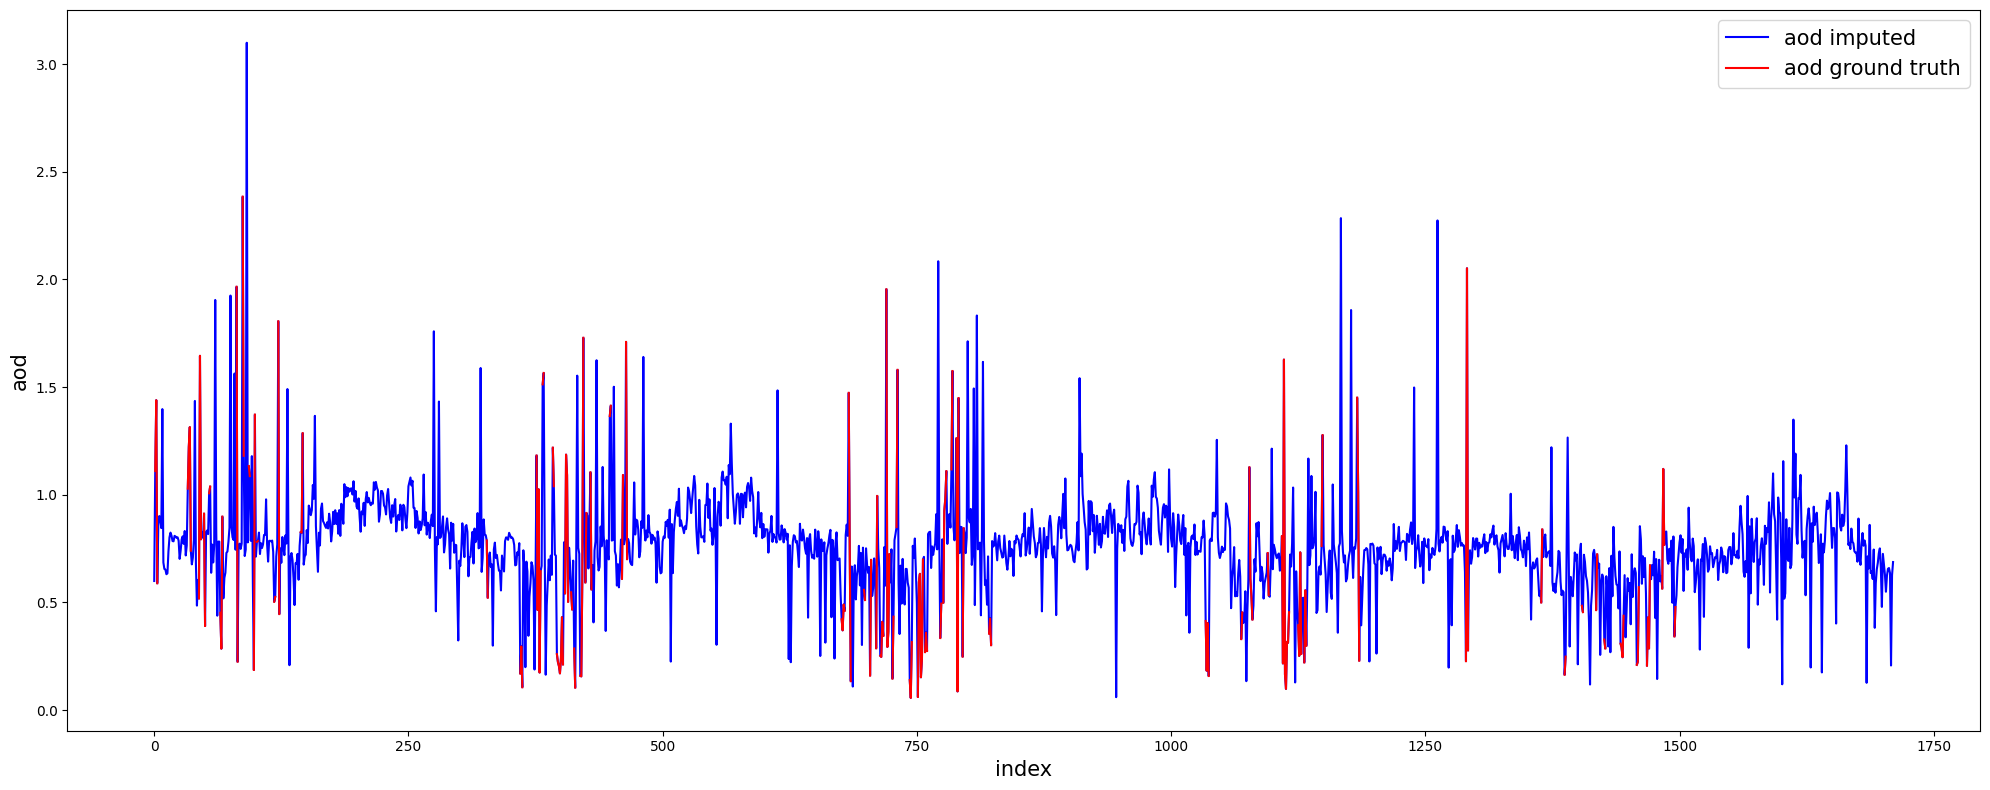


Handling for station 202



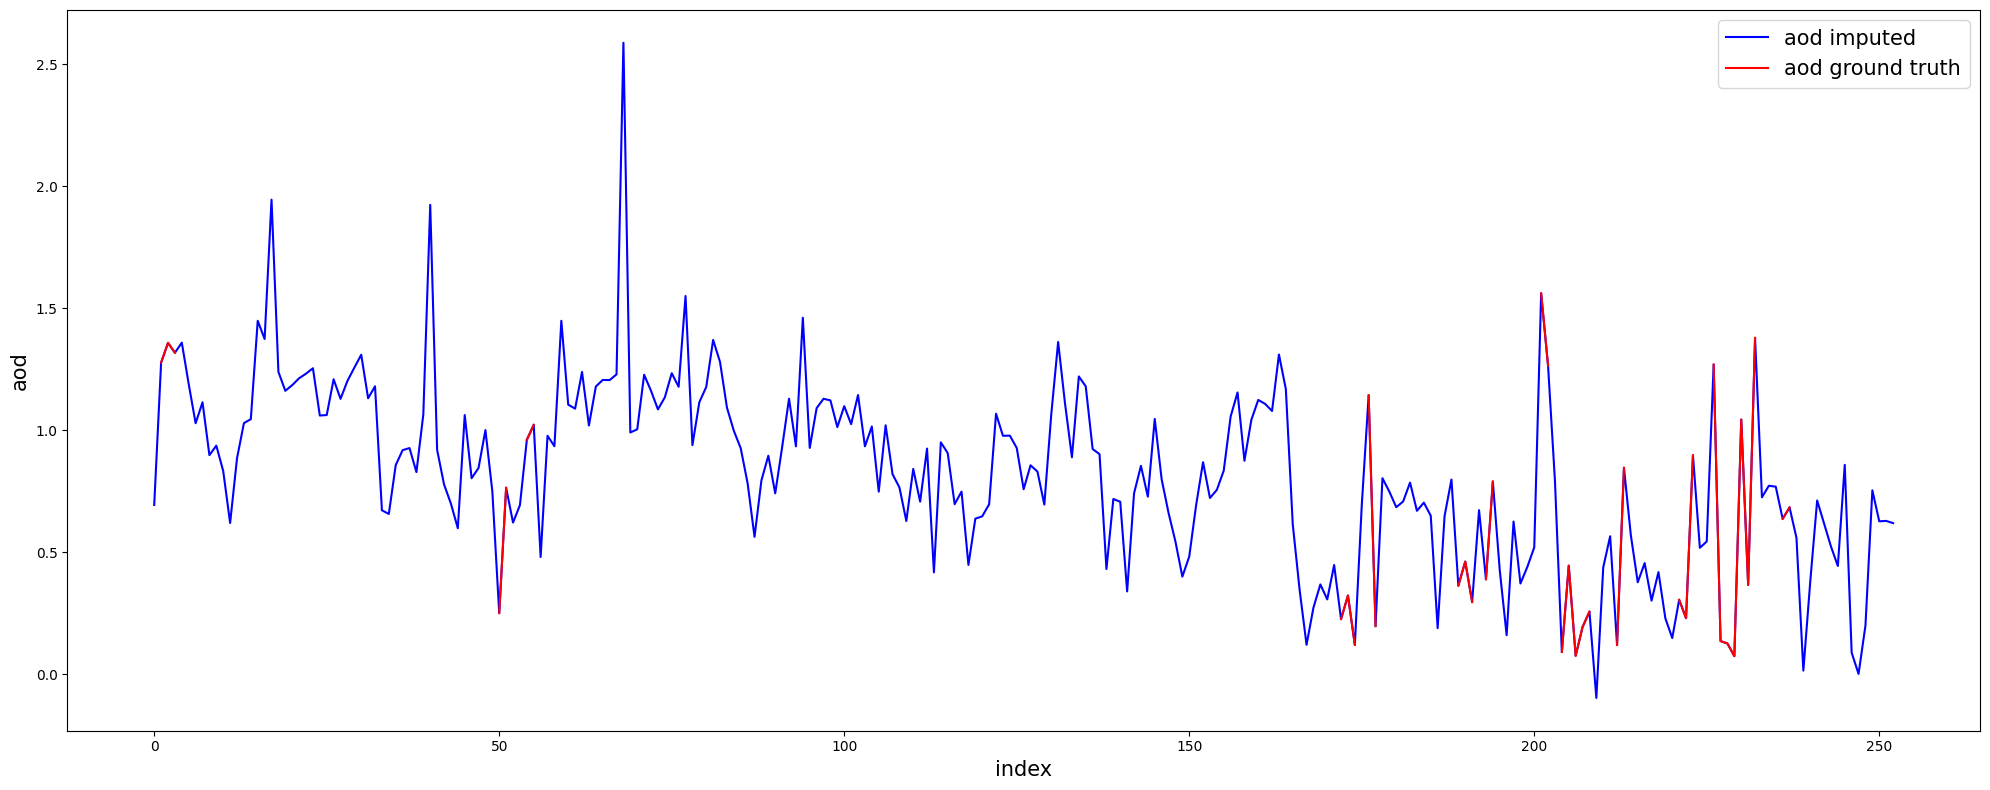


Handling for station 211



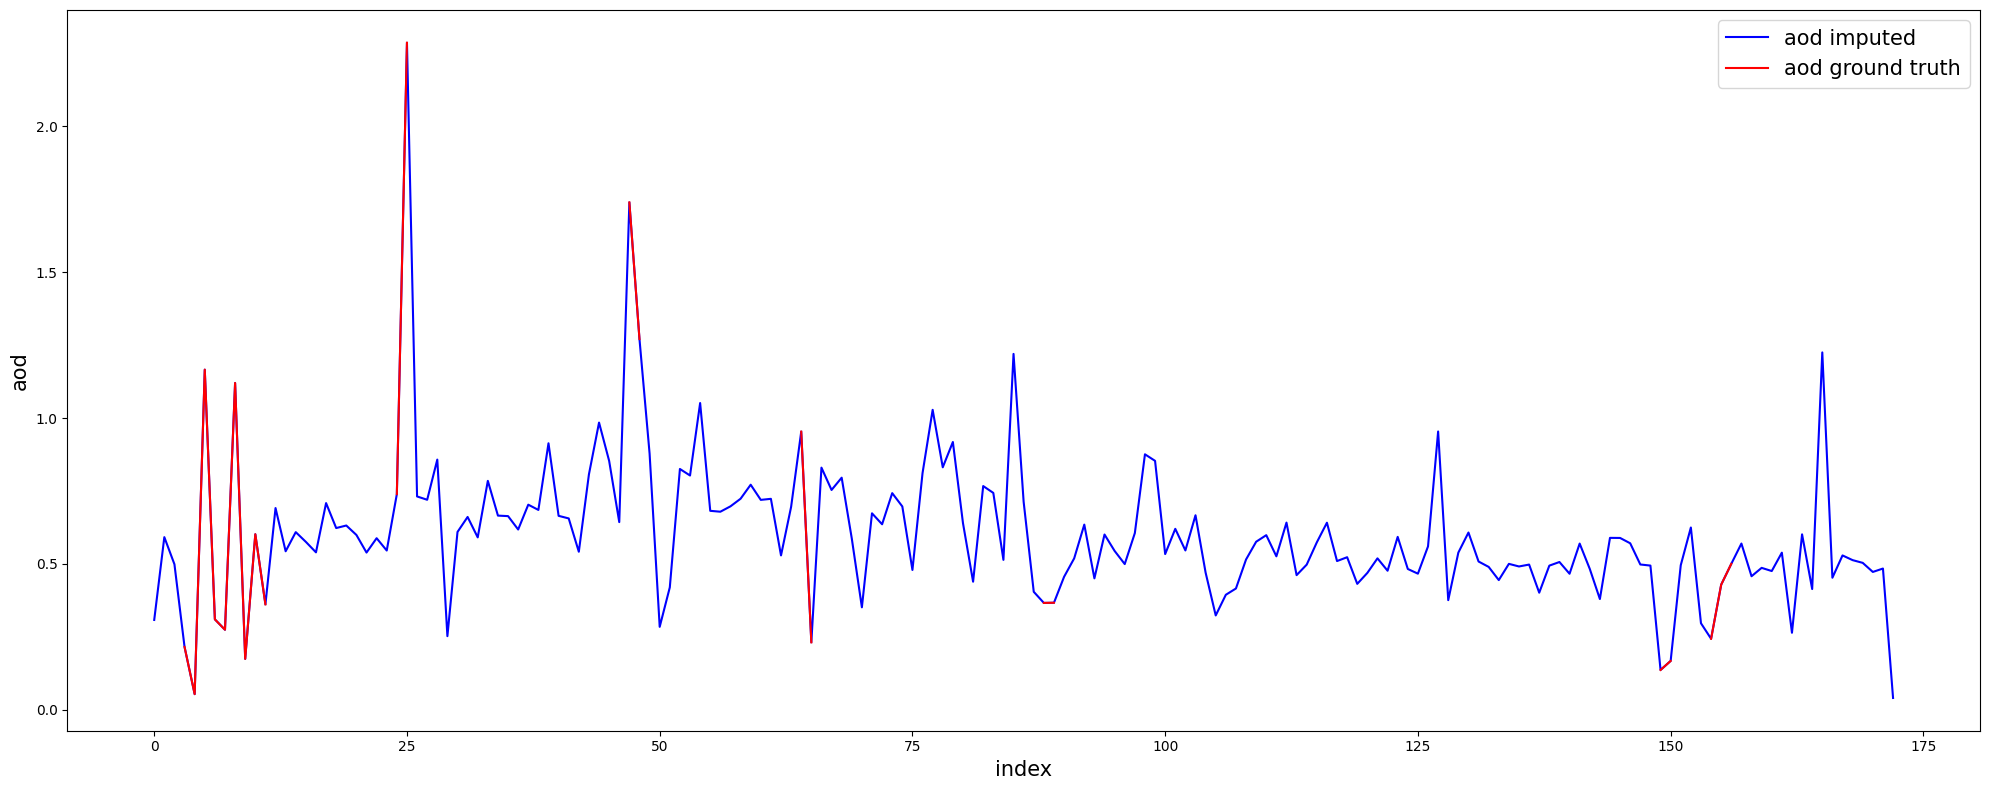


Handling for station 212



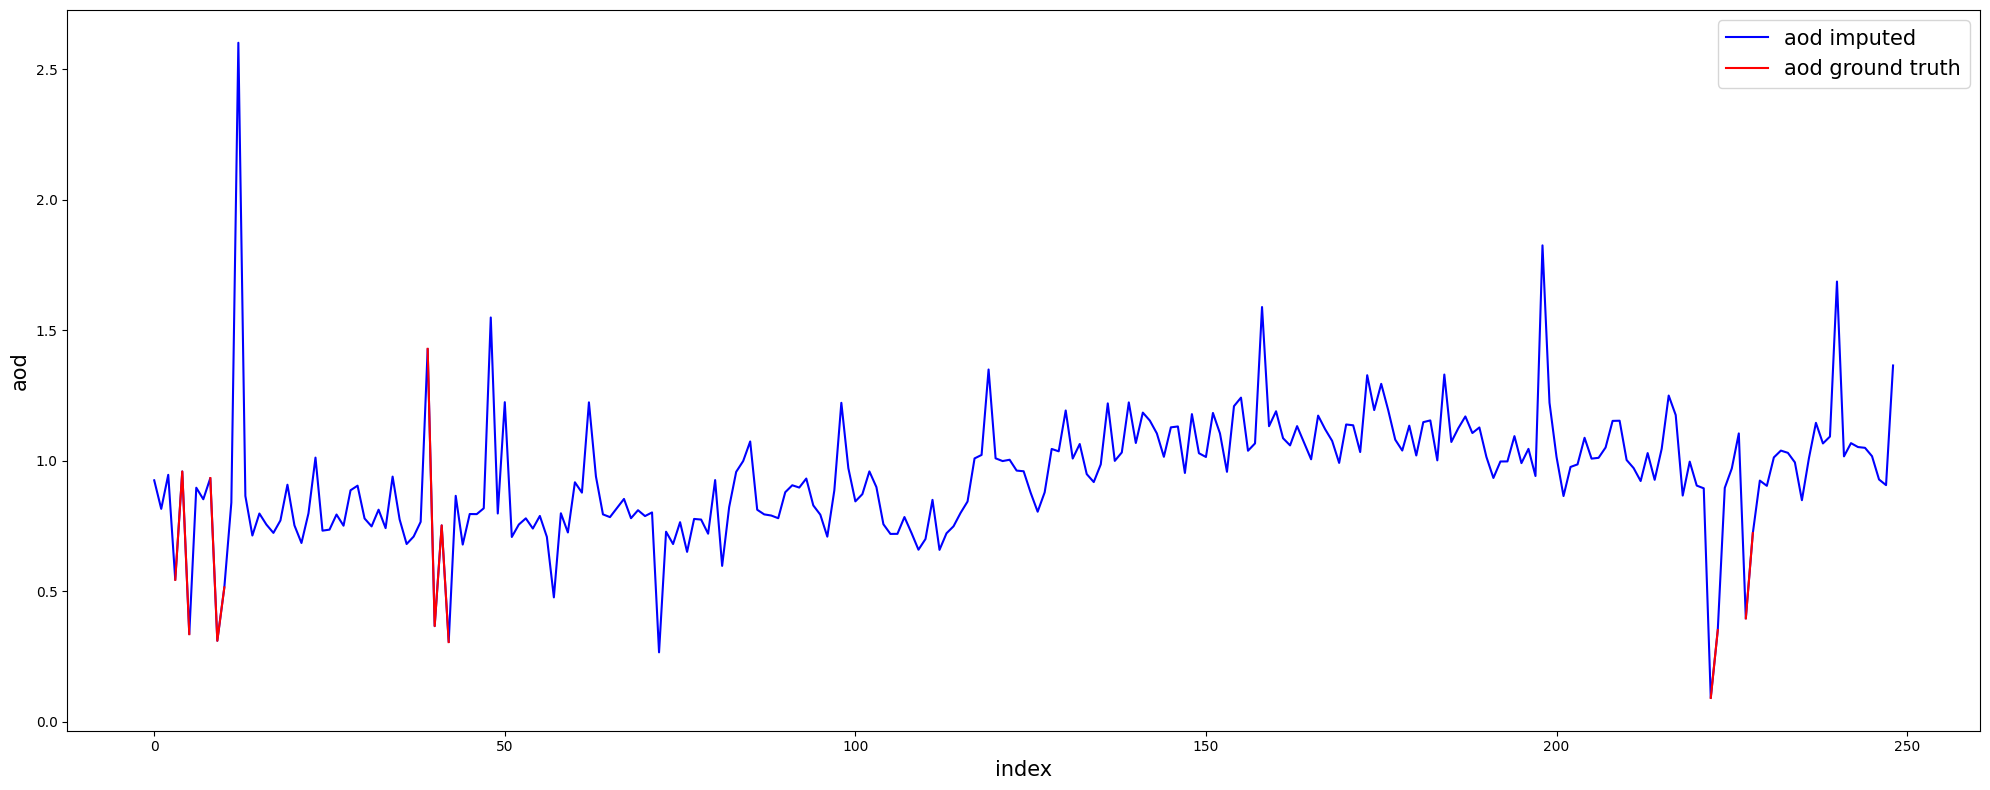


Handling for station 213



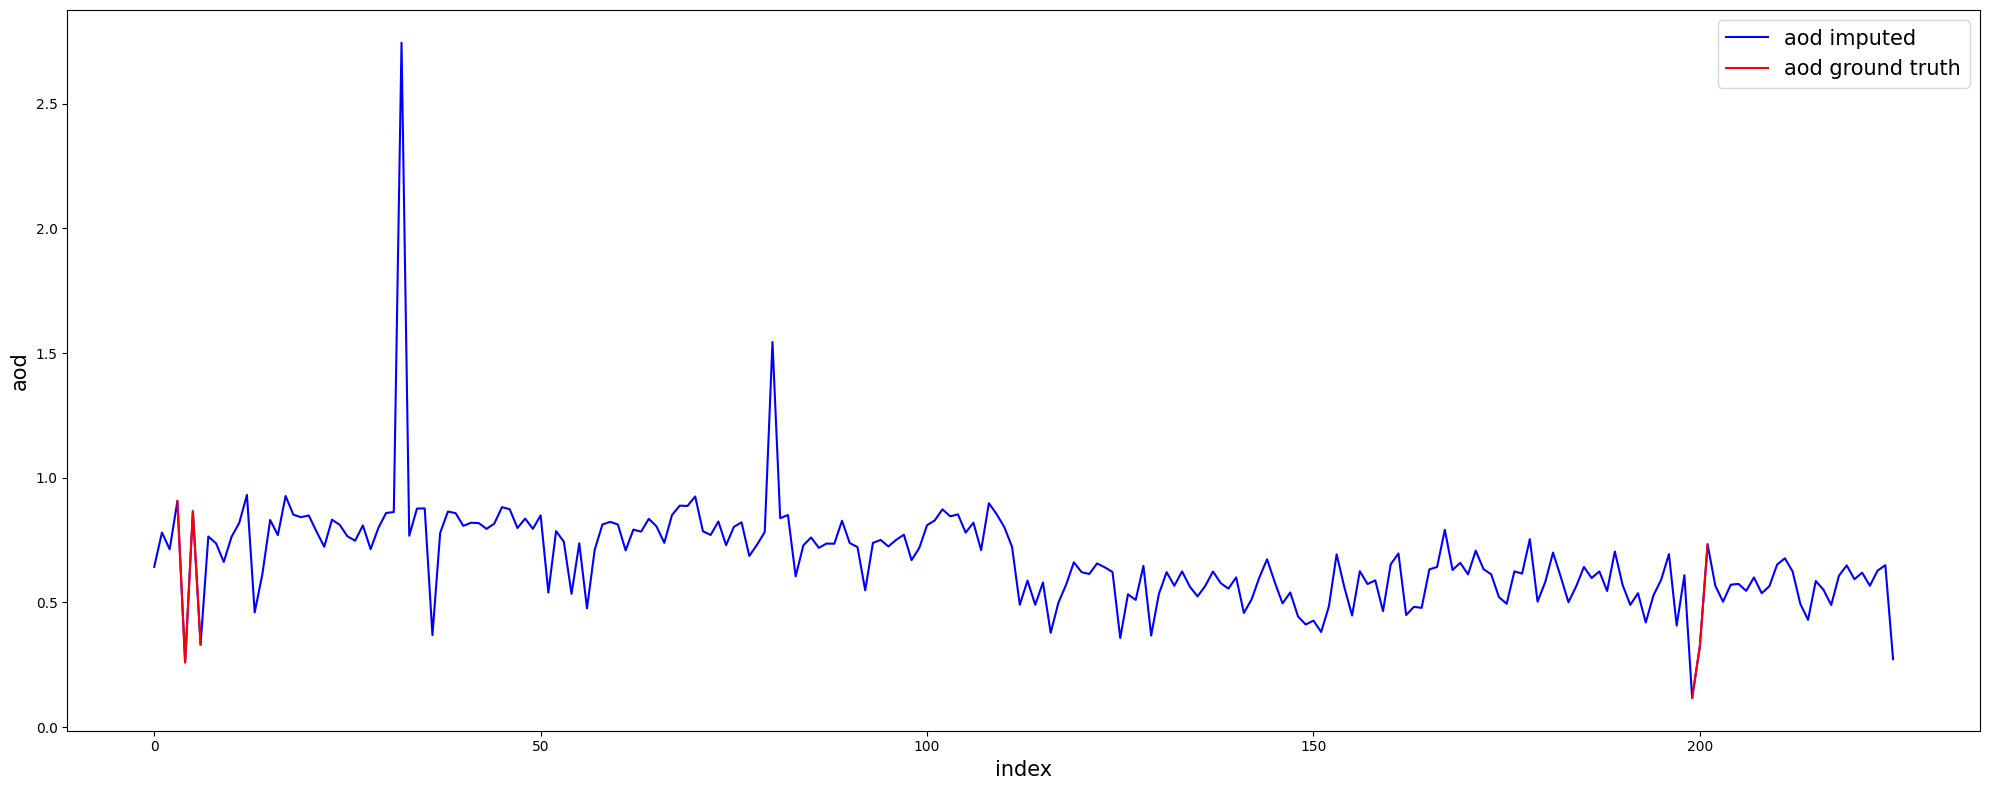


Handling for station 214



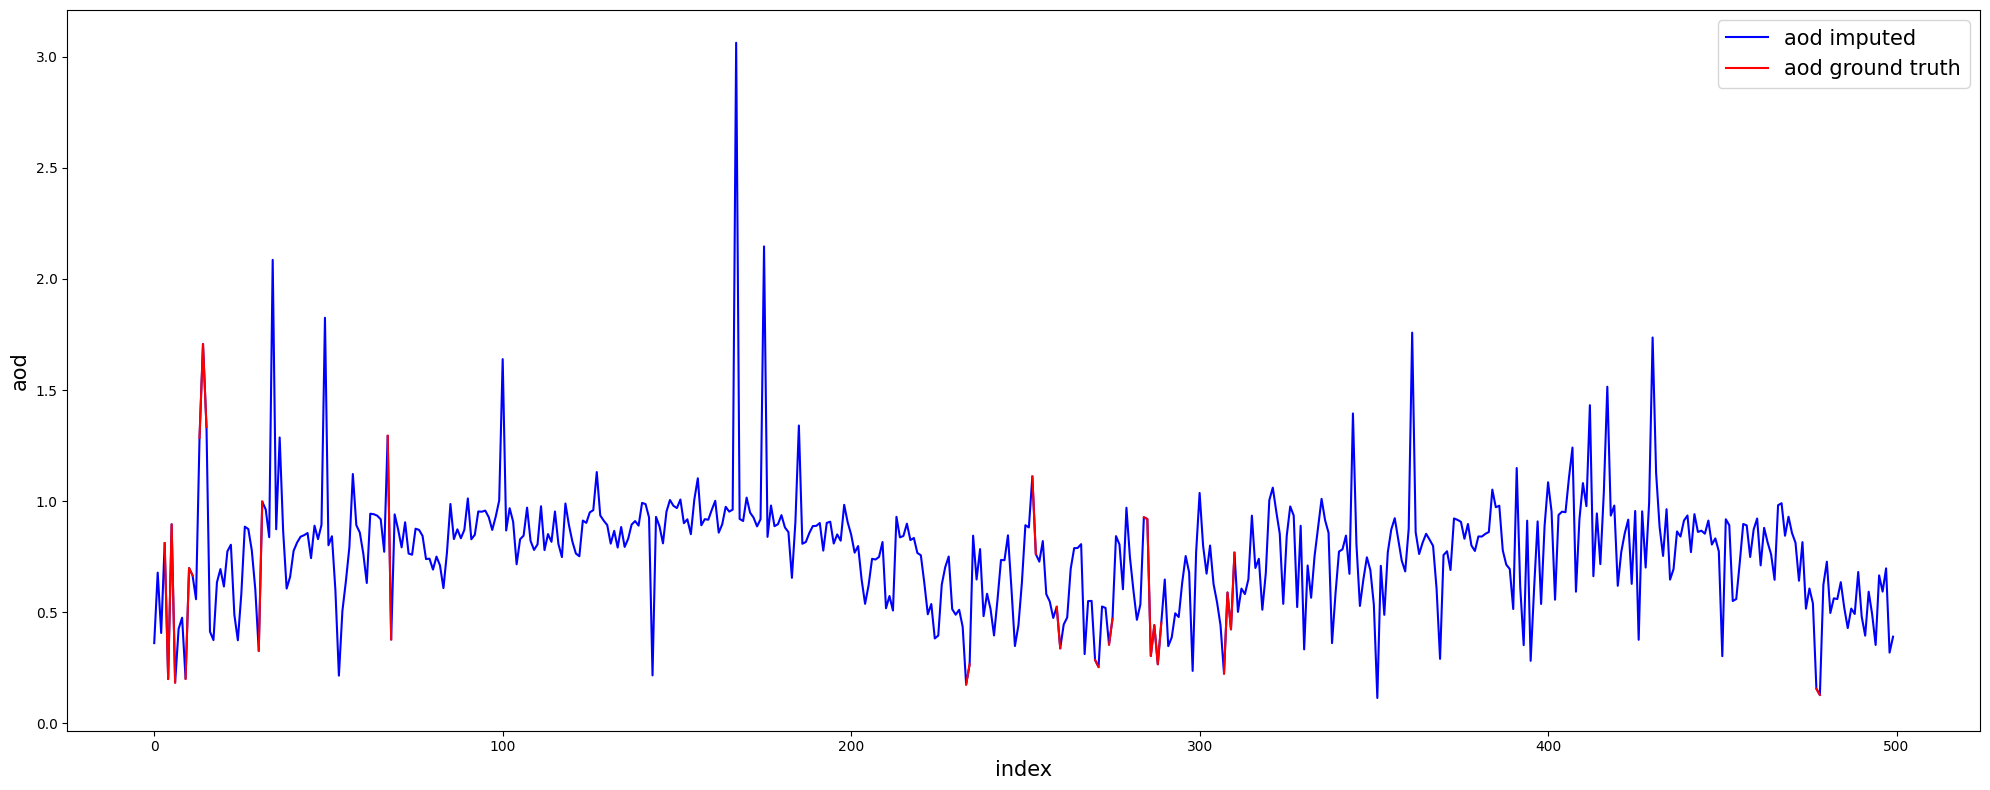


Handling for station 215



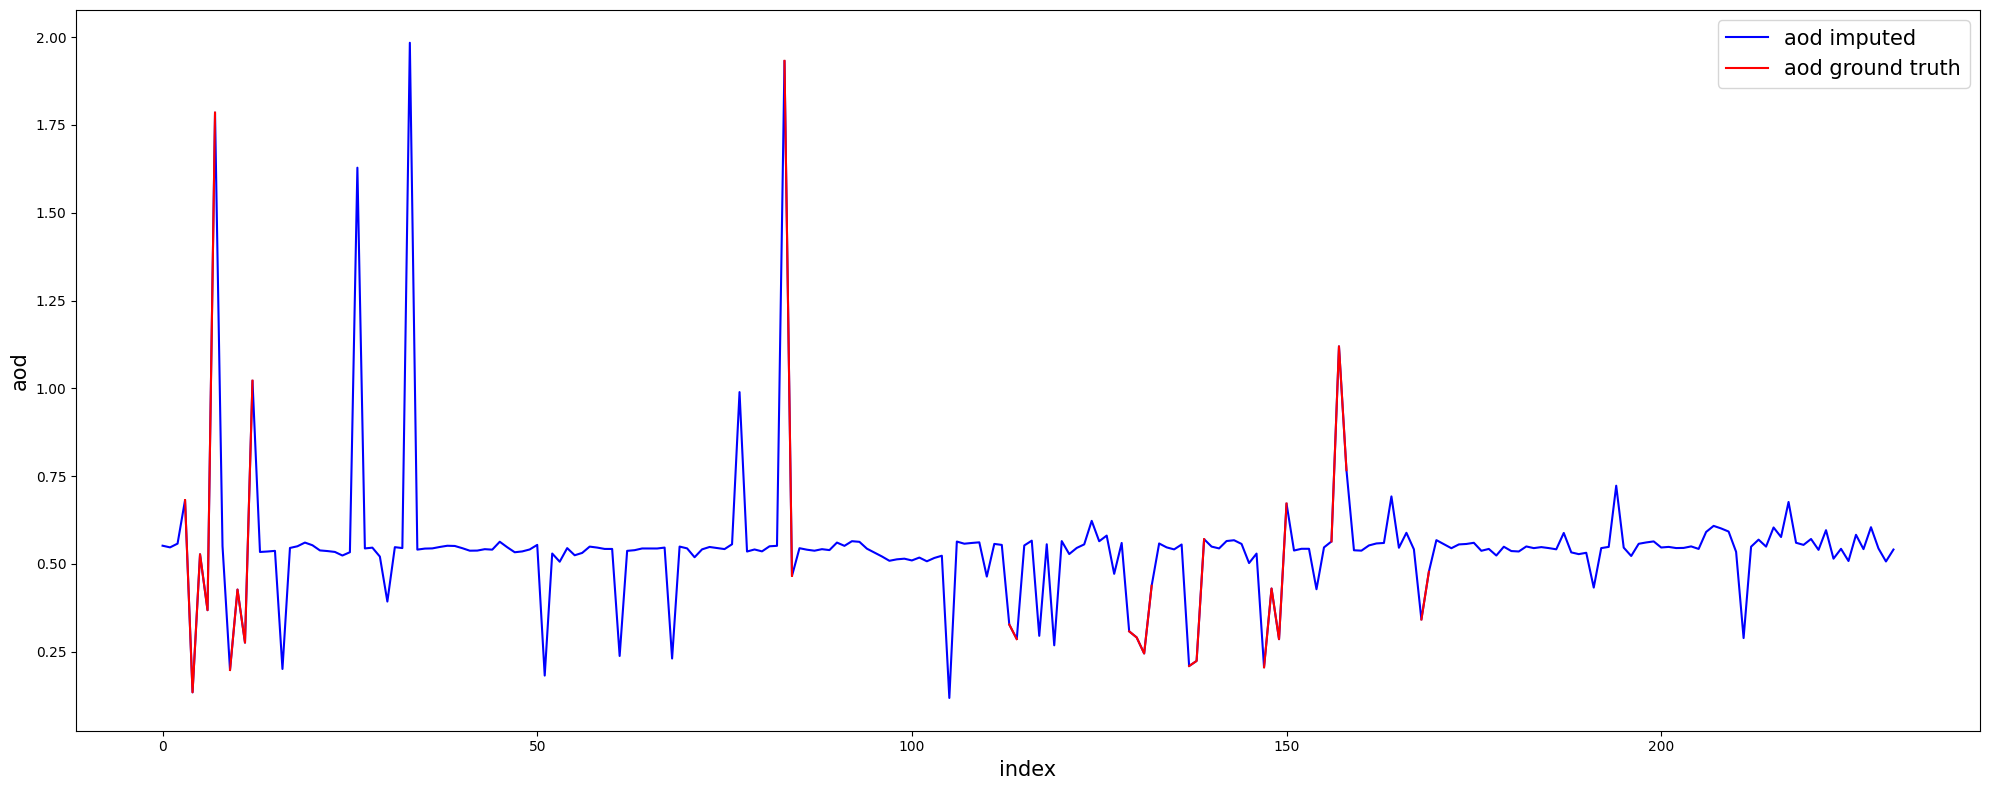


Handling for station 216



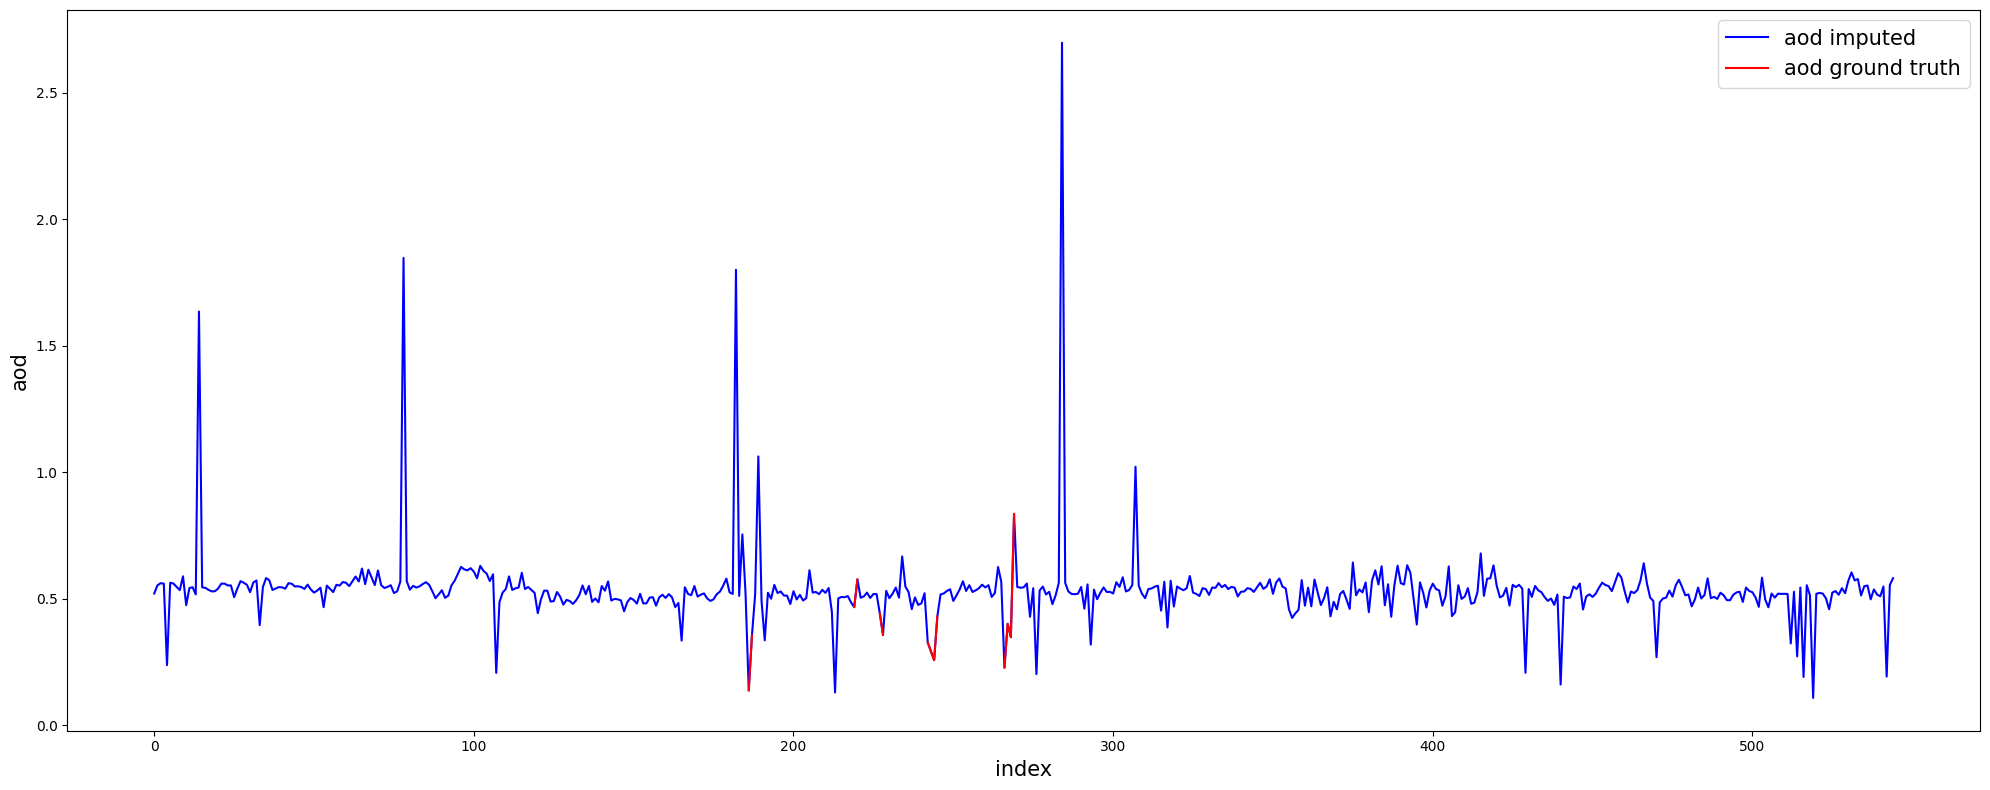

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2018-01-01      201  31.391304  10.783057  106.700606  34.919998  25.204139   
2018-01-02      201  37.458333  10.783057  106.700606  51.830002  24.726431   
2018-01-03      201  68.083333  10.783057  106.700606  38.240002  26.095087   
2018-01-04      201  51.260870  10.783057  106.700606  40.259998  26.514926   
2018-01-05      201  18.909091  10.783057  106.700606  21.690001  25.483535   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2018-01-01  70.056728  455.131335  2.352895  20680.62695  ...   
2018-01-02  73.425826  339.083720  1.903761  20680.62695  ...   
2018-01-03  77.793432  367.190738  1.293329  20680.62695  ...   
2018-01-04  82.982475  462.504210  1.588872  20680.62695  ...   
2018-01-05  93.046504  324.735356  2.505876  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2018-01-01  1876.639945  232011.95950    0.0  2700.122924  0.599173  
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  1.110117  
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  1.439045  
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  0.588595  
2018-01-05  1876.639945  232011.95950    0.0  2700.122924  0.852506  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505  

[3889 rows x 21 columns]

In [15]:
all_stations_df = []

for station in aod_all_stations:
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]

    # Fill "aod" column
    #df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())
    df_aod_current_station_imputed = copy.deepcopy(df_aod_current_station)
    df_aod_current_station_imputed.loc[:, "aod"] = mice(df_aod_current_station_imputed.drop(columns=["station", "pm25"]))["aod"]
    plot_2_data(data1=df_aod_current_station_imputed["aod"],
               datalabel1="aod imputed",
               data2=df_aod_current_station["aod"],
               datalabel2="aod ground truth",
               ylabel="aod",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_aod_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station_imputed)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

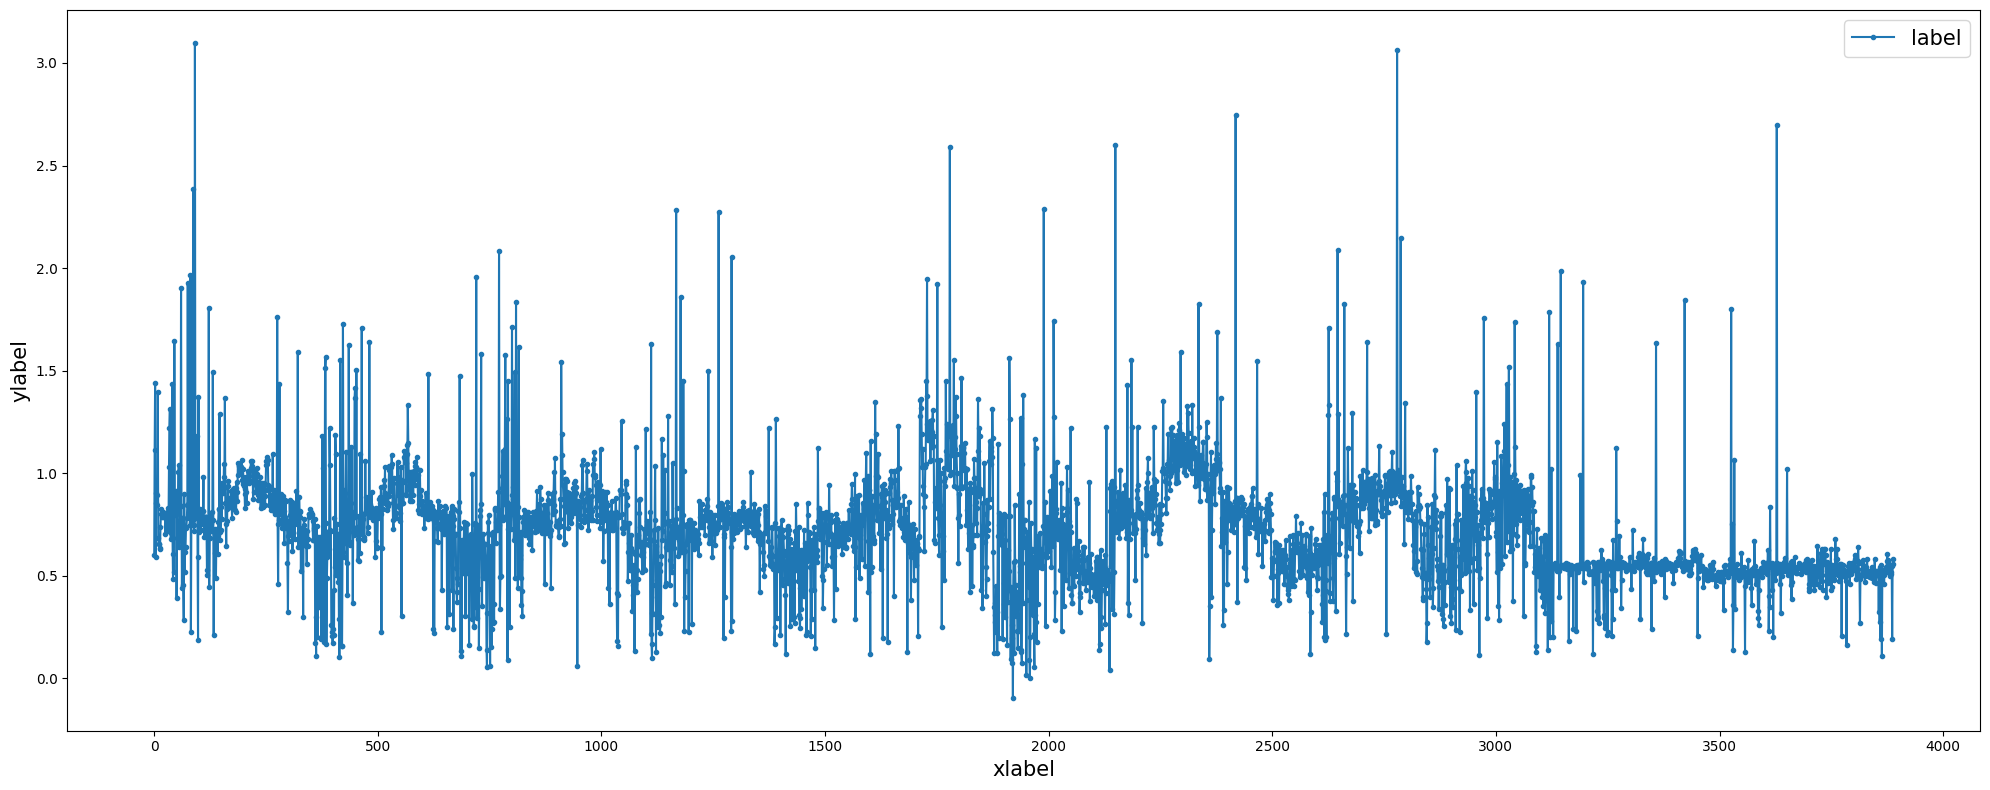

In [16]:
plot_1_data(df_aod["aod"])

In [17]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations, pm25_3km

In [18]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=3889, freq=None)

In [19]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

time
2018-01-01    201
2018-01-02    201
2018-01-03    201
2018-01-04    201
2018-01-05    201
             ... 
2022-12-27    216
2022-12-28    216
2022-12-29    216
2022-12-30    216
2022-12-31    216
Name: station, Length: 3889, dtype: int64

In [20]:
# Get the pm25_3km column
aod_pm25_3km_column = df_aod.loc[:, "pm25_3km"]
aod_pm25_3km_column

time
2018-01-01    34.919998
2018-01-02    51.830002
2018-01-03    38.240002
2018-01-04    40.259998
2018-01-05    21.690001
                ...    
2022-12-27    34.439411
2022-12-28    29.838476
2022-12-29    28.450829
2022-12-30    19.854403
2022-12-31    27.658358
Name: pm25_3km, Length: 3889, dtype: float64

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [21]:
# Features with pm25_3km
aod_feats = aod_stat_feats + aod_dyn_feats

# Predict without "station" as a feature
# Remove "pm25_3km" also
aod_feats.remove("station")
aod_feats.remove("pm25_3km")
X_aod = df_aod.loc[:, aod_feats]

# Label
y_aod = df_aod.loc[:, aod_label]

In [22]:
X_aod

lat         lon          pop  road_den_1km  \
time                                                           
2018-01-01  10.783057  106.700606  20680.62695     27.462461   
2018-01-02  10.783057  106.700606  20680.62695     27.462461   
2018-01-03  10.783057  106.700606  20680.62695     27.462461   
2018-01-04  10.783057  106.700606  20680.62695     27.462461   
2018-01-05  10.783057  106.700606  20680.62695     27.462461   
...               ...         ...          ...           ...   
2022-12-27  10.780482  106.659511  57523.91406     33.629780   
2022-12-28  10.780482  106.659511  57523.91406     33.629780   
2022-12-29  10.780482  106.659511  57523.91406     33.629780   
2022-12-30  10.780482  106.659511  57523.91406     33.629780   
2022-12-31  10.780482  106.659511  57523.91406     33.629780   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2018-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2018-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi         rh  \
time                                                                   
2018-01-01  1876.639945  232011.95950    0.0  2700.122924  70.056728   
2018-01-02  1876.639945  232011.95950    0.0  2700.122924  73.425826   
2018-01-03  1876.639945  232011.95950    0.0  2700.122924  77.793432   
2018-01-04  1876.639945  232011.95950    0.0  2700.122924  82.982475   
2018-01-05  1876.639945  232011.95950    0.0  2700.122924  93.046504   
...                 ...           ...    ...          ...        ...   
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  73.973083   
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  65.530487   
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  67.093735   
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  64.868401   
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  62.377899   

                wspd        hpbl       aod        tmp  
time                                                   
2018-01-01  2.352895  455.131335  0.599173  25.204139  
2018-01-02  1.903761  339.083720  1.110117  24.726431  
2018-01-03  1.293329  367.190738  1.439045  26.095087  
2018-01-04  1.588872  462.504210  0.588595  26.514926  
2018-01-05  2.505876  324.735356  0.852506  25.483535  
...              ...         ...       ...        ...  
2022-12-27  2.002987  457.798645  0.508564  24.136936  
2022-12-28  2.298220  644.974548  0.547594  25.844296  
2022-12-29  2.823764  825.517395  0.191691  25.841156  
2022-12-30  3.893373  680.533081  0.554055  24.979719  
2022-12-31  4.161542  799.122803  0.580505  25.364861  

[3889 rows x 18 columns]

In [23]:
y_aod

pm25
time                 
2018-01-01  31.391304
2018-01-02  37.458333
2018-01-03  68.083333
2018-01-04  51.260870
2018-01-05  18.909091
...               ...
2022-12-27  39.659816
2022-12-28  44.679352
2022-12-29  30.724708
2022-12-30  33.091428
2022-12-31  28.854069

[3889 rows x 1 columns]

### Data normalization

In [24]:
# Scaled features
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

lat       lon       pop  road_den_1km  prim_road_len_1km  \
0     0.326794  0.466551  0.116512      0.471552           0.949821   
1     0.326794  0.466551  0.116512      0.471552           0.949821   
2     0.326794  0.466551  0.116512      0.471552           0.949821   
3     0.326794  0.466551  0.116512      0.471552           0.949821   
4     0.326794  0.466551  0.116512      0.471552           0.949821   
...        ...       ...       ...           ...                ...   
3884  0.306899  0.237227  0.857395      0.785926           0.323578   
3885  0.306899  0.237227  0.857395      0.785926           0.323578   
3886  0.306899  0.237227  0.857395      0.785926           0.323578   
3887  0.306899  0.237227  0.857395      0.785926           0.323578   
3888  0.306899  0.237227  0.857395      0.785926           0.323578   

      near_dist  bareland   builtup  cropland  grassland  treecover  water  \
0      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
1      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
2      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
3      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
4      0.344052   0.00000  0.182582       0.0   0.037975   1.000000    0.0   
...         ...       ...       ...       ...        ...        ...    ...   
3884   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3885   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3886   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3887   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   
3888   0.075528   0.62963  0.720601       0.0   0.170886   0.375453    0.0   

          ndvi        rh      wspd      hpbl       aod       tmp  
0     0.526821  0.468797  0.170694  0.300502  0.217912  0.342735  
1     0.526821  0.543165  0.110646  0.211553  0.377783  0.303640  
2     0.526821  0.639575  0.029033  0.233097  0.480703  0.415649  
3     0.526821  0.754117  0.068546  0.306153  0.214603  0.450008  
4     0.526821  0.976269  0.191147  0.200556  0.297179  0.365600  
...        ...       ...       ...       ...       ...       ...  
3884  0.085003  0.555246  0.123912  0.302546  0.189562  0.255396  
3885  0.085003  0.368885  0.163384  0.446013  0.201774  0.395124  
3886  0.085003  0.403392  0.233647  0.584396  0.090414  0.394867  
3887  0.085003  0.354270  0.376650  0.473268  0.203795  0.324368  
3888  0.085003  0.299295  0.412504  0.564165  0.212071  0.355888  

[3889 rows x 18 columns]

In [25]:
# Scaled label
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

pm25
0     0.325673
1     0.398696
2     0.767302
3     0.564825
4     0.175435
...        ...
3884  0.425193
3885  0.485609
3886  0.317649
3887  0.346136
3888  0.295134

[3889 rows x 1 columns]

## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25 as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [26]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction': []} | {m: [] for m in LSTMPrediction.get_supported_metrics()}
evaluation_board

{'dim_reduction_method': [],
 'dim_after_reduction': [],
 'prediction': [],
 'mae': [],
 'mse': [],
 'rmse': [],
 'r2': [],
 'mape': []}

### Range of dimension

In [27]:
RANGE_OF_DIMENSION = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
#RANGE_OF_DIMENSION = range(2, 5)
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

10 11 12 13 14 15 16 17 

### Prediction without reduction

Model: "aod_LSTMPrediction_no_dim_reduction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 64),      │     21,504 │ input_layer[0][0] │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 1, 64)     │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 64)     │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 1, 1)      │         65 │ dropout[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,593 (213.25 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

None


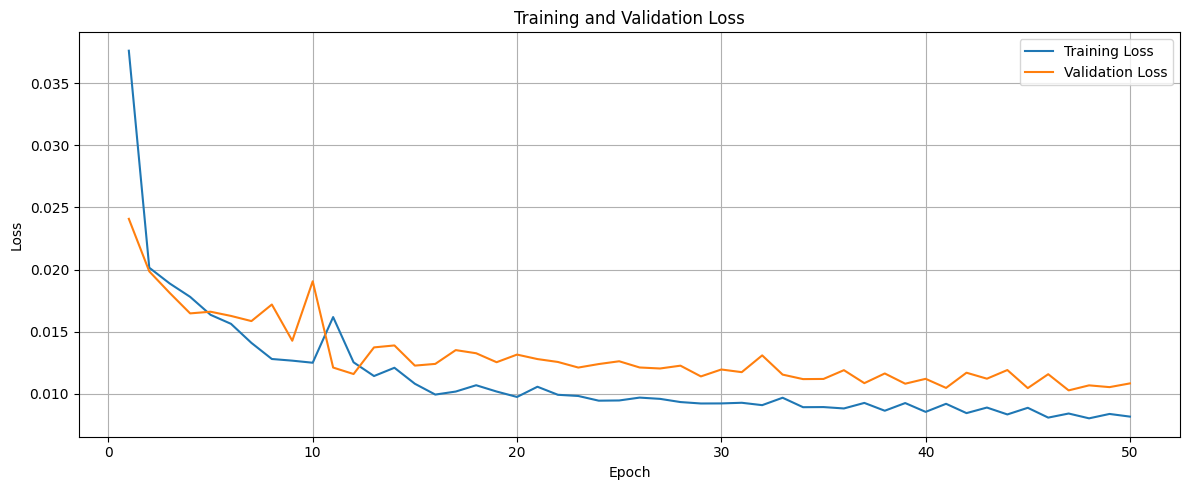

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


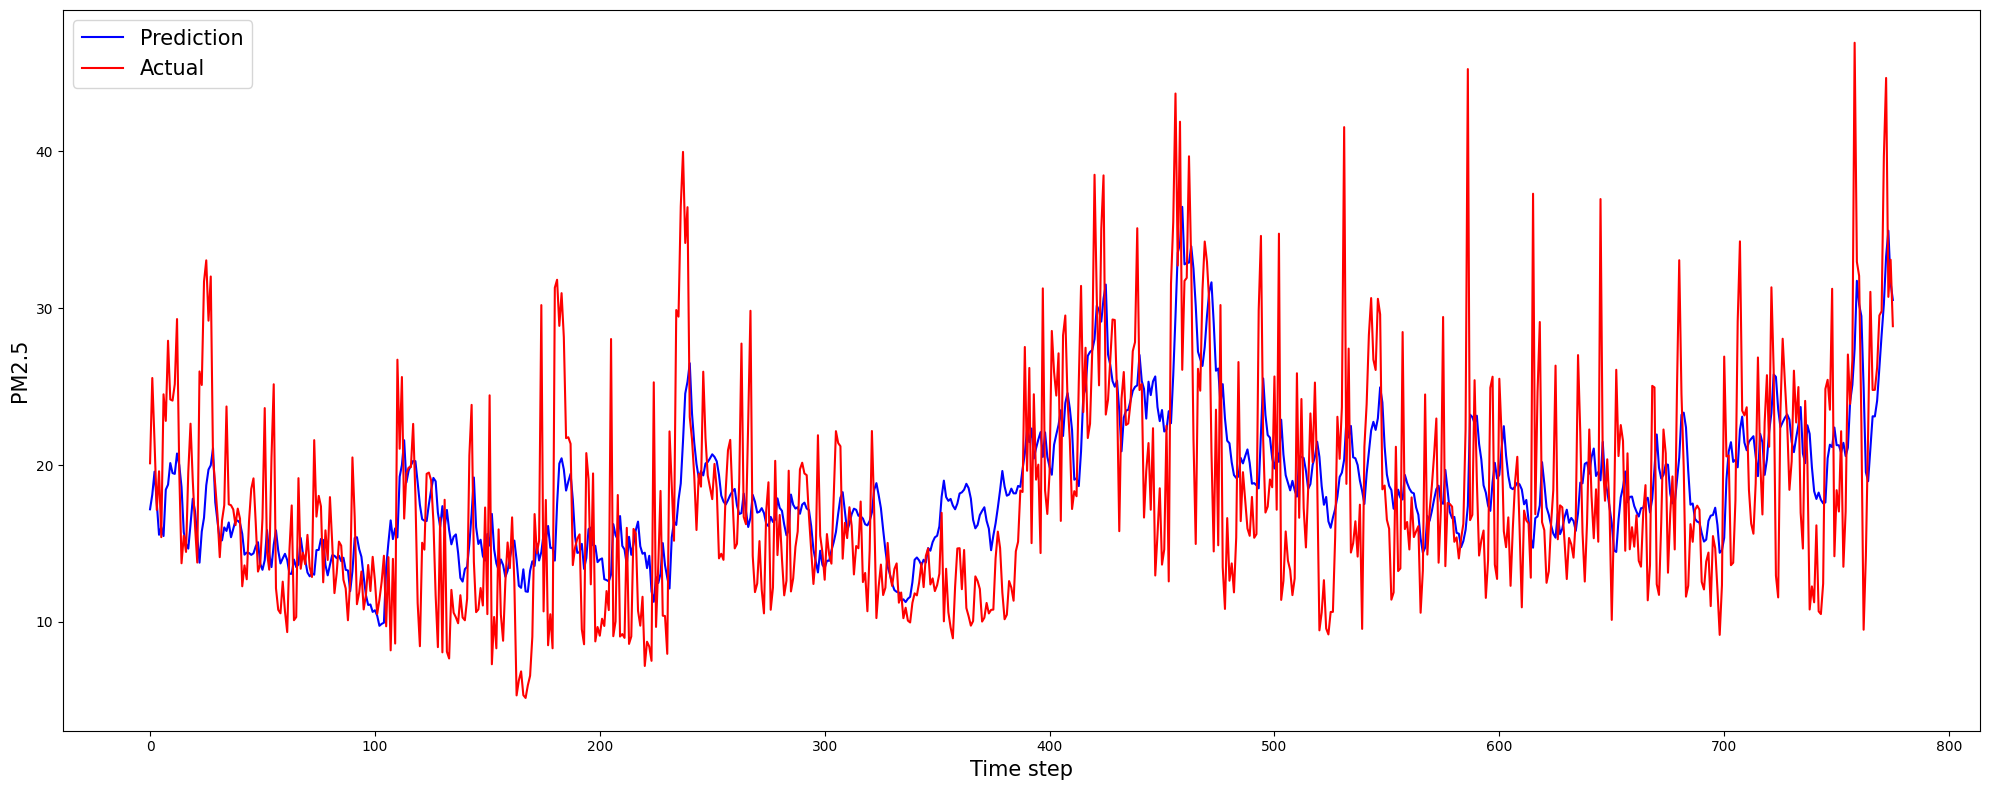

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  4.403112  32.664239   

       rmse        r2      mape  
0  5.715264 -0.778659  0.242072

In [28]:
# Prediction
lstmpred = LSTMPrediction(X_aod_scaled, y_aod_scaled,
                            aod_label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"aod_{LSTMPrediction.class_name}_no_dim_reduction",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, metrics = lstmpred.execute()

# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["None"]
evaluation_board['dim_after_reduction'] += ["N/A"]
evaluation_board['prediction'] += ["LSTM"]
for m in LSTMPrediction.get_supported_metrics():
    evaluation_board[m] += [metrics[m][1]]
pd.DataFrame(evaluation_board)

### Prediction + LSTM-Seq2Seq

#### Doing the loop

Model: "aod_LSTMSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 7, 100)    │     47,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_2[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │        510 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 7, 10)     │          0 │ dense_1[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 7, 50)     │     12,200 │ repeat_vector_1[… │
│                     │                   │            │ lstm_3[0][1],     │
│                     │                   │            │ lstm_3[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 7, 18)     │      1,818 │ lstm_5[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 458,186 (1.75 MB)

 Trainable params: 152,728 (596.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 305,458 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_10_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,310 (305.90 KB)

 Trainable params: 78,310 (305.90 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 64),      │     19,456 │ input_layer_3[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 1, 64)     │          0 │ lstm_6[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector_2[… │
│                     │                   │            │ lstm_6[0][1],     │
│                     │                   │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 64)     │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 1, 1)      │         65 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

None


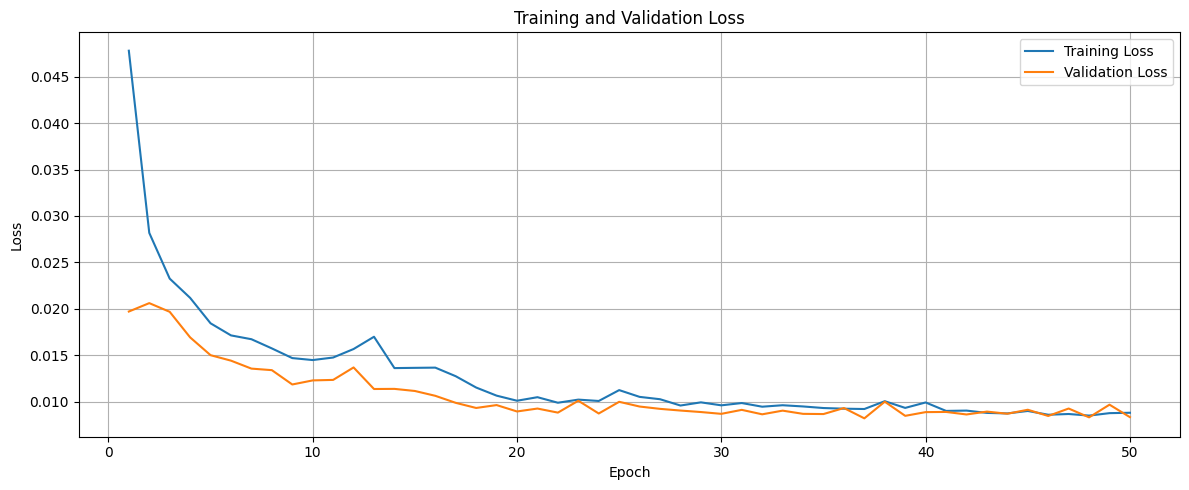

Model: "aod_LSTMSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 7, 100)    │     47,600 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_8[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 11)        │        561 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 7, 11)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 7, 50)     │     12,400 │ repeat_vector_3[… │
│                     │                   │            │ lstm_9[0][1],     │
│                     │                   │            │ lstm_9[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 7, 18)     │      1,818 │ lstm_11[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 458,939 (1.75 MB)

 Trainable params: 152,979 (597.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 305,960 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_11_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,361 (306.10 KB)

 Trainable params: 78,361 (306.10 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ [(None, 64),      │     19,712 │ input_layer_6[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 1, 64)     │          0 │ lstm_12[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_4[… │
│                     │                   │            │ lstm_12[0][1],    │
│                     │                   │            │ lstm_12[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 64)     │          0 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 1, 1)      │         65 │ dropout_2[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

None


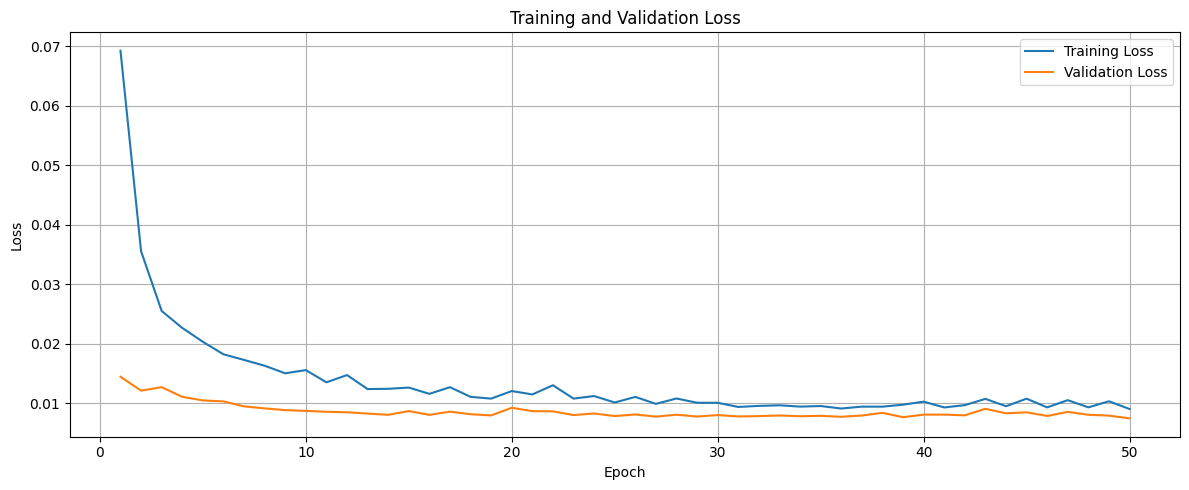

Model: "aod_LSTMSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_14[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 12)        │        612 │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 7, 12)     │          0 │ dense_7[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 7, 50)     │     12,600 │ repeat_vector_5[… │
│                     │                   │            │ lstm_15[0][1],    │
│                     │                   │            │ lstm_15[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 7, 18)     │      1,818 │ lstm_17[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 459,692 (1.75 MB)

 Trainable params: 153,230 (598.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,462 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_12_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,412 (306.30 KB)

 Trainable params: 78,412 (306.30 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ [(None, 64),      │     19,968 │ input_layer_9[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 1, 64)     │          0 │ lstm_18[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_6[… │
│                     │                   │            │ lstm_18[0][1],    │
│                     │                   │            │ lstm_18[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 64)     │          0 │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 1, 1)      │         65 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

None


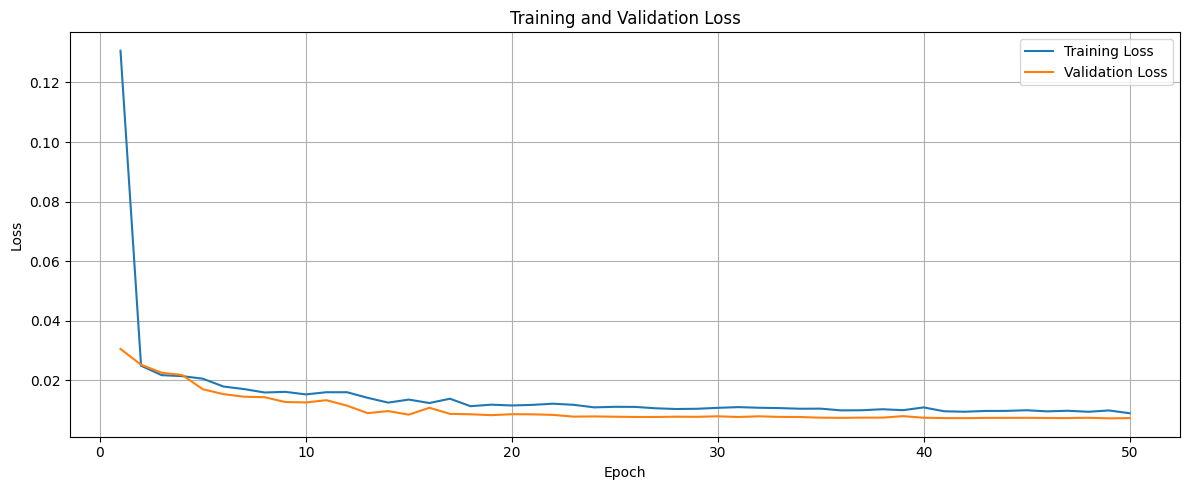

Model: "aod_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_20[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 13)        │        663 │ lstm_21[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 7, 13)     │          0 │ dense_10[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ (None, 7, 50)     │     12,800 │ repeat_vector_7[… │
│                     │                   │            │ lstm_21[0][1],    │
│                     │                   │            │ lstm_21[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_22[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 7, 18)     │      1,818 │ lstm_23[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 460,445 (1.76 MB)

 Trainable params: 153,481 (599.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,964 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,463 (306.50 KB)

 Trainable params: 78,463 (306.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_12[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 1, 64)     │          0 │ lstm_24[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_8[… │
│                     │                   │            │ lstm_24[0][1],    │
│                     │                   │            │ lstm_24[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1, 64)     │          0 │ lstm_25[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 1, 1)      │         65 │ dropout_4[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

None


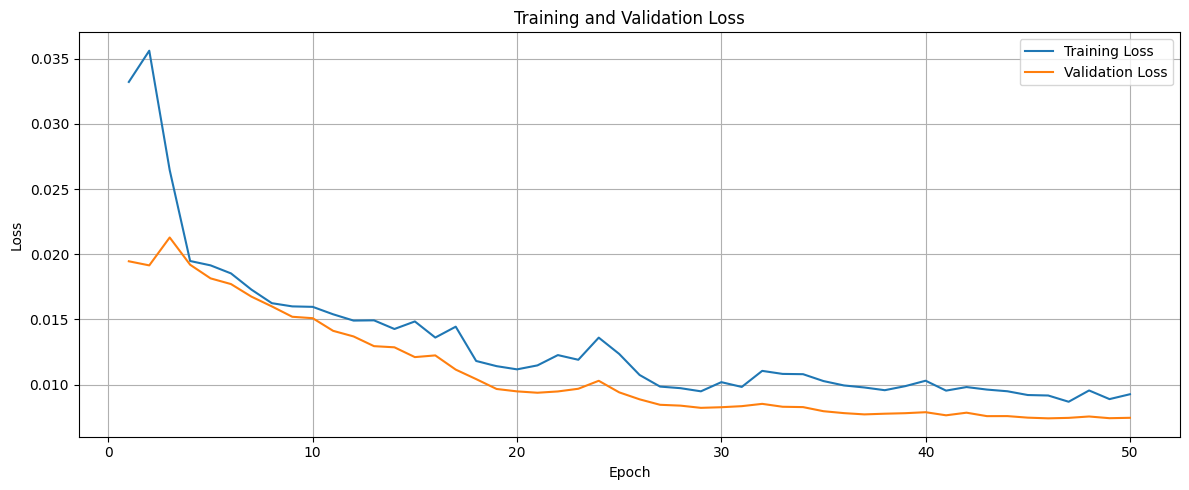

Model: "aod_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_26[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 14)        │        714 │ lstm_27[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_9     │ (None, 7, 14)     │          0 │ dense_13[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_9[… │
│                     │                   │            │ lstm_27[0][1],    │
│                     │                   │            │ lstm_27[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_28[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 7, 18)     │      1,818 │ lstm_29[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,198 (1.76 MB)

 Trainable params: 153,732 (600.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,466 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,514 (306.70 KB)

 Trainable params: 78,514 (306.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_15[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_10    │ (None, 1, 64)     │          0 │ lstm_30[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_10… │
│                     │                   │            │ lstm_30[0][1],    │
│                     │                   │            │ lstm_30[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 64)     │          0 │ lstm_31[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 1, 1)      │         65 │ dropout_5[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

None


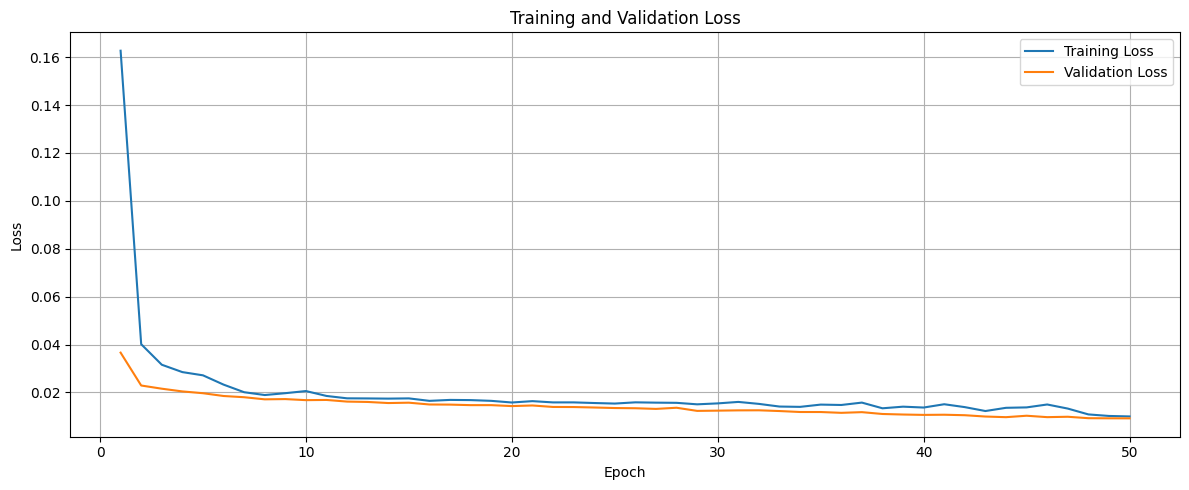

Model: "aod_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_32[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 15)        │        765 │ lstm_33[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_11    │ (None, 7, 15)     │          0 │ dense_16[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_11… │
│                     │                   │            │ lstm_33[0][1],    │
│                     │                   │            │ lstm_33[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_34[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 7, 18)     │      1,818 │ lstm_35[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,951 (1.76 MB)

 Trainable params: 153,983 (601.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,968 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,565 (306.89 KB)

 Trainable params: 78,565 (306.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_18[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_12    │ (None, 1, 64)     │          0 │ lstm_36[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_12… │
│                     │                   │            │ lstm_36[0][1],    │
│                     │                   │            │ lstm_36[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1, 64)     │          0 │ lstm_37[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 1, 1)      │         65 │ dropout_6[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

None


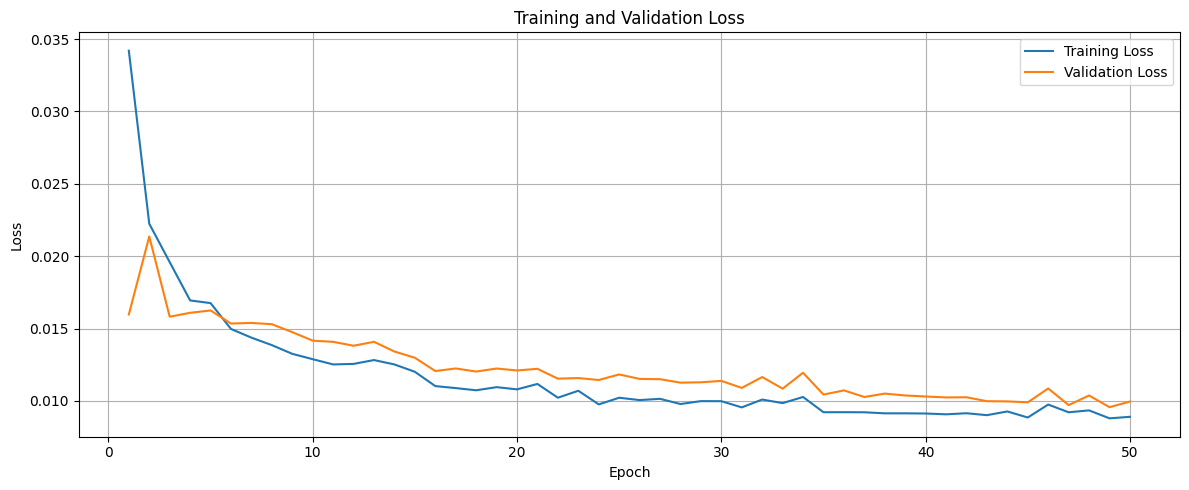

Model: "aod_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_38[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │        816 │ lstm_39[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_13    │ (None, 7, 16)     │          0 │ dense_19[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_13… │
│                     │                   │            │ lstm_39[0][1],    │
│                     │                   │            │ lstm_39[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_40[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 7, 18)     │      1,818 │ lstm_41[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,704 (1.77 MB)

 Trainable params: 154,234 (602.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,470 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,616 (307.09 KB)

 Trainable params: 78,616 (307.09 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_21[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 1, 64)     │          0 │ lstm_42[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_14… │
│                     │                   │            │ lstm_42[0][1],    │
│                     │                   │            │ lstm_42[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1, 64)     │          0 │ lstm_43[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 1, 1)      │         65 │ dropout_7[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,081 (211.25 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

None


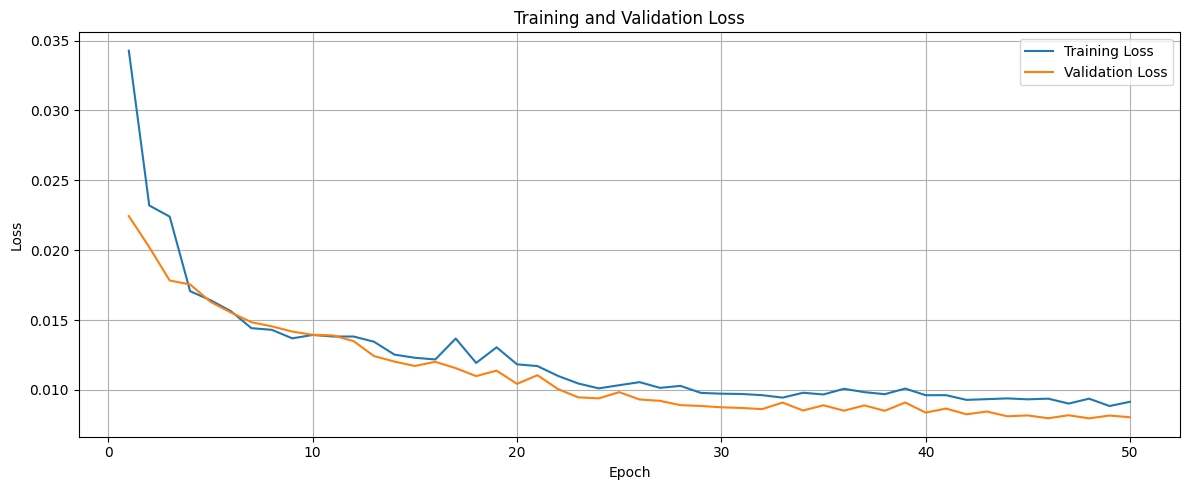

Model: "aod_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_44 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_45 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_44[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 17)        │        867 │ lstm_45[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_15    │ (None, 7, 17)     │          0 │ dense_22[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_46 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_15… │
│                     │                   │            │ lstm_45[0][1],    │
│                     │                   │            │ lstm_45[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_46[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 7, 18)     │      1,818 │ lstm_47[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,457 (1.77 MB)

 Trainable params: 154,485 (603.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,972 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,667 (307.29 KB)

 Trainable params: 78,667 (307.29 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_48 (LSTM)      │ [(None, 64),      │     21,248 │ input_layer_24[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_16    │ (None, 1, 64)     │          0 │ lstm_48[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_49 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_16… │
│                     │                   │            │ lstm_48[0][1],    │
│                     │                   │            │ lstm_48[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1, 64)     │          0 │ lstm_49[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_16 │ (None, 1, 1)      │         65 │ dropout_8[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,337 (212.25 KB)

 Non-trainable params: 0 (0.00 B)

None


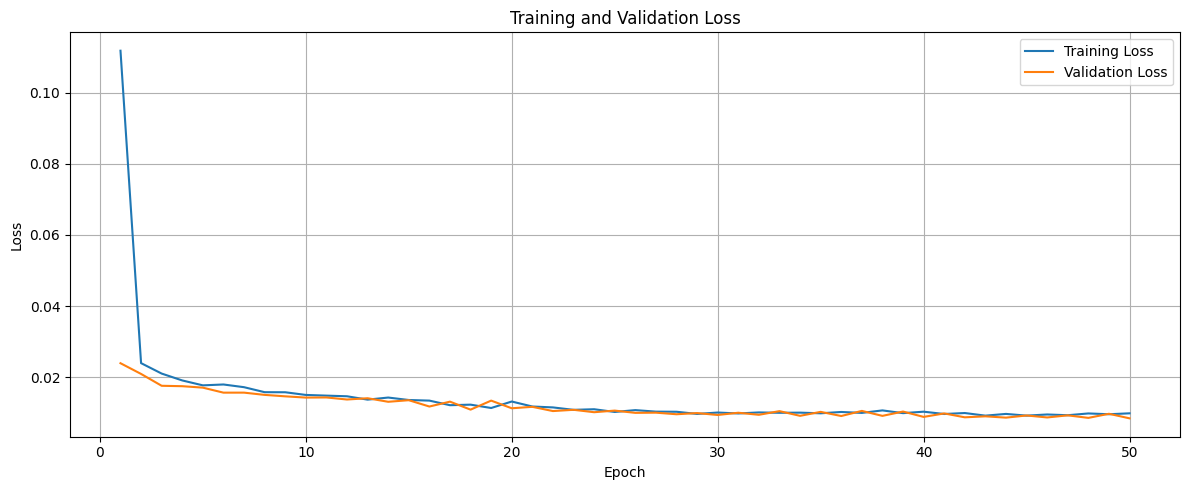

Choosing the best result

dict_keys([10, 11, 12, 13, 14, 15, 16, 17])
N = 10
mae = 5.416017646593373
mse = 40.77271166244892
rmse = 6.385351334300167
r2 = -2.267349517031359
mape = 0.2646340907440408
N = 11
mae = 4.645651447513458
mse = 33.92865660436902
rmse = 5.824831036551105
r2 = -2.550173470030009
mape = 0.249628556322158
N = 12
mae = 4.166519850502159
mse = 31.095105488865126
rmse = 5.576298547321971
r2 = -1.058265525869829
mape = 0.2388403692919402
N = 13
mae = 4.496955806299521
mse = 32.09708704494436
rmse = 5.66542911392812
r2 = -2.0547415298175937
mape = 0.2441335228007171
N = 14
mae = 6.233671328621504
mse = 53.46259008616348
rmse = 7.311811682897986
r2 = -6.860929549778558
mape = 0.29011803687595905
N = 15
mae = 4.297669601662223
mse = 34.06094679059903
rmse = 5.836175699085749
r2 = -2.9736764423078093
mape = 0.253317785533559
N = 16
mae = 4.286312496596154
mse = 31.87979461433685
rmse = 5.646219497534332
r2 = -1.4358706820295657
mape = 0.24504304386657175
N = 17
mae = 4.48

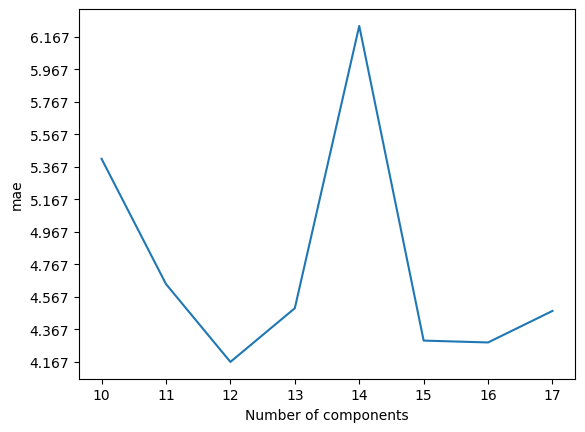

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


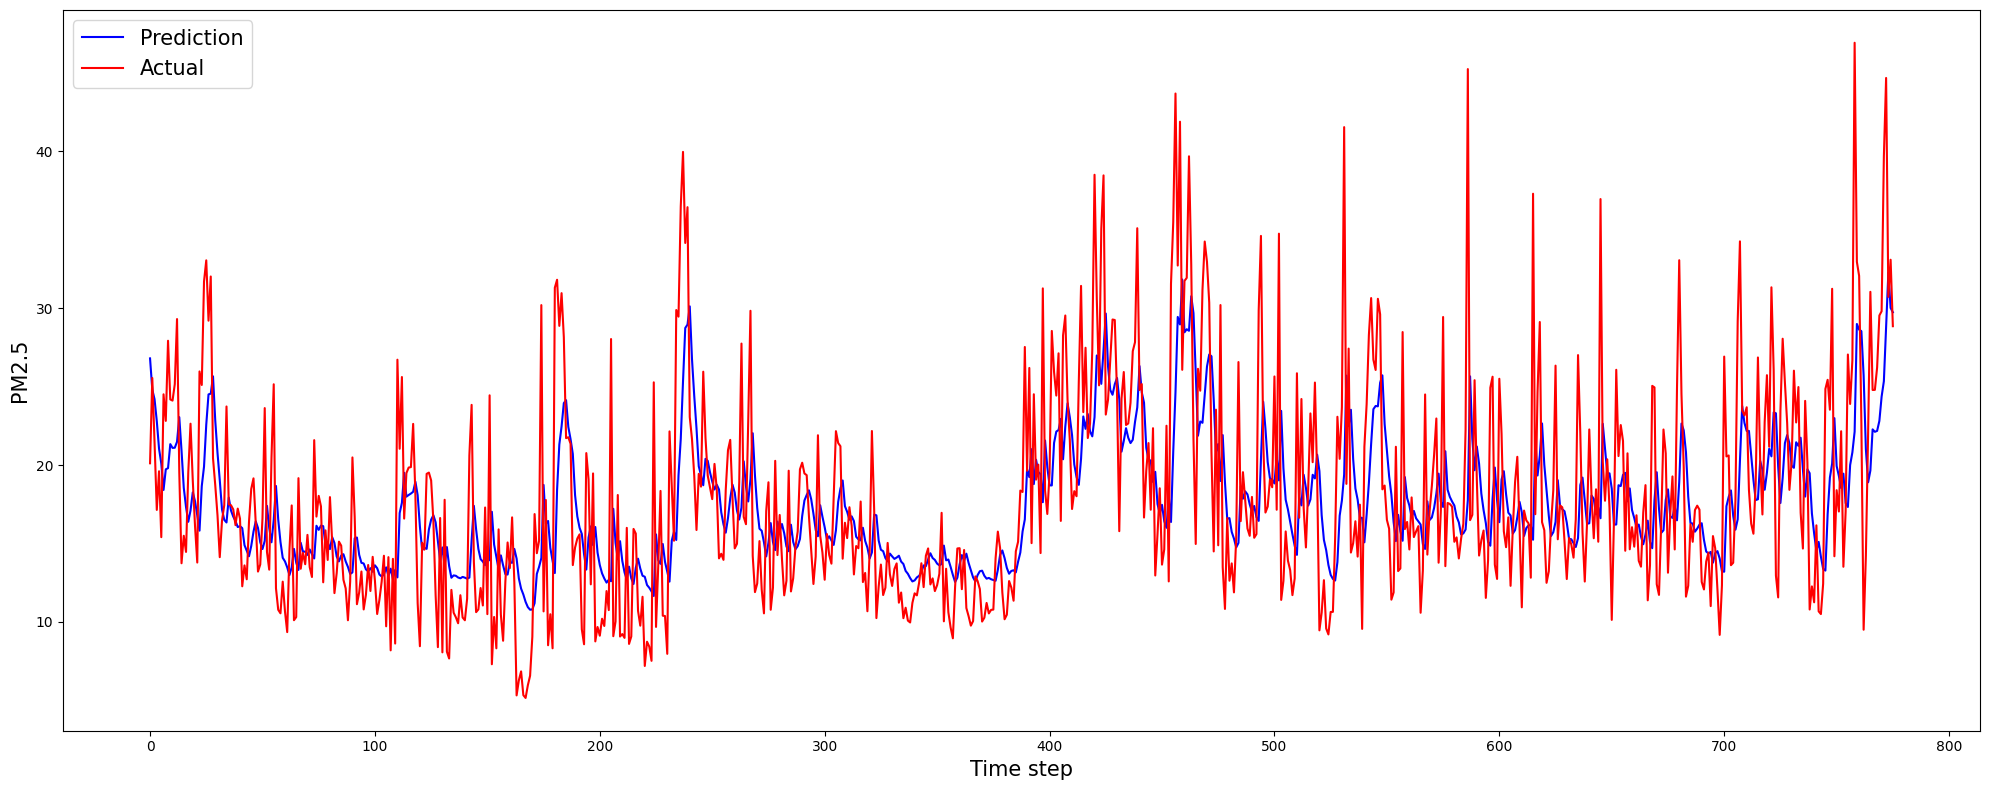

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  4.403112  32.664239   
1         LSTM-Seq2Seq                  12       LSTM  4.166520  31.095105   

       rmse        r2      mape  
0  5.715264 -0.778659  0.242072  
1  5.576299 -1.058266  0.238840

In [29]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, LSTMSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [30]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022.csv"))
df_lstms2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.306810      -0.458068      -0.119822      -1.640606   
2018-01-02       0.306810      -0.458068      -0.119822      -1.640606   
2018-01-03       0.307577      -0.458092      -0.119238      -1.643616   
2018-01-04       0.309959      -0.458072      -0.120550      -1.650503   
2018-01-05       0.312340      -0.458608      -0.124270      -1.659657   
...                   ...            ...            ...            ...   
2022-12-27       0.170996       0.186273      -0.146399      -1.259638   
2022-12-28       0.171017       0.181644      -0.144009      -1.254325   
2022-12-29       0.171267       0.180386      -0.140846      -1.241962   
2022-12-30       0.172856       0.180346      -0.141254      -1.238306   
2022-12-31       0.173207       0.178961      -0.142971      -1.240075   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01      -0.274004      -1.739825       2.054661       0.339134   
2018-01-02      -0.274004      -1.739825       2.054661       0.339134   
2018-01-03      -0.273472      -1.741391       2.055274       0.338497   
2018-01-04      -0.271399      -1.747939       2.061314       0.338568   
2018-01-05      -0.271339      -1.759606       2.072983       0.340941   
...                   ...            ...            ...            ...   
2022-12-27       0.171248      -0.926890       1.546237       0.290888   
2022-12-28       0.166554      -0.925096       1.539759       0.288799   
2022-12-29       0.163995      -0.913265       1.524472       0.283392   
2022-12-30       0.164090      -0.911412       1.520676       0.281727   
2022-12-31       0.164063      -0.917865       1.526633       0.284574   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01      -2.344035       -0.698337        0.225343        1.045705   
2018-01-02      -2.344035       -0.698337        0.225343        1.045705   
2018-01-03      -2.343814       -0.697836        0.225732        1.046810   
2018-01-04      -2.348012       -0.698136        0.227233        1.051367   
2018-01-05      -2.359690       -0.701716        0.229634        1.059355   
...                   ...             ...             ...             ...   
2022-12-27      -1.221504       -0.175257        0.045907        0.830835   
2022-12-28      -1.218269       -0.176198        0.046890        0.825589   
2022-12-29      -1.204045       -0.174275        0.047193        0.814352   
2022-12-30      -1.202870       -0.174837        0.046938        0.812731   
2022-12-31      -1.209926       -0.178258        0.048016        0.816909   

            station  
time                 
2018-01-01      201  
2018-01-02      201  
2018-01-03      201  
2018-01-04      201  
2018-01-05      201  
...             ...  
2022-12-27      216  
2022-12-28      216  
2022-12-29      216  
2022-12-30      216  
2022-12-31      216  

[3889 rows x 13 columns]

In [31]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_lstms2s_reduced_augmented = augmentReducedData(df_lstms2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_lstms2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_lstms2s_reduced_augmented

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.306810      -0.458068      -0.119822      -1.640606   
2018-01-02       0.306810      -0.458068      -0.119822      -1.640606   
2018-01-03       0.307577      -0.458092      -0.119238      -1.643616   
2018-01-04       0.309959      -0.458072      -0.120550      -1.650503   
2018-01-05       0.312340      -0.458608      -0.124270      -1.659657   
...                   ...            ...            ...            ...   
2022-12-27       0.170996       0.186273      -0.146399      -1.259638   
2022-12-28       0.171017       0.181644      -0.144009      -1.254325   
2022-12-29       0.171267       0.180386      -0.140846      -1.241962   
2022-12-30       0.172856       0.180346      -0.141254      -1.238306   
2022-12-31       0.173207       0.178961      -0.142971      -1.240075   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01      -0.274004      -1.739825       2.054661       0.339134   
2018-01-02      -0.274004      -1.739825       2.054661       0.339134   
2018-01-03      -0.273472      -1.741391       2.055274       0.338497   
2018-01-04      -0.271399      -1.747939       2.061314       0.338568   
2018-01-05      -0.271339      -1.759606       2.072983       0.340941   
...                   ...            ...            ...            ...   
2022-12-27       0.171248      -0.926890       1.546237       0.290888   
2022-12-28       0.166554      -0.925096       1.539759       0.288799   
2022-12-29       0.163995      -0.913265       1.524472       0.283392   
2022-12-30       0.164090      -0.911412       1.520676       0.281727   
2022-12-31       0.164063      -0.917865       1.526633       0.284574   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01      -2.344035       -0.698337        0.225343        1.045705   
2018-01-02      -2.344035       -0.698337        0.225343        1.045705   
2018-01-03      -2.343814       -0.697836        0.225732        1.046810   
2018-01-04      -2.348012       -0.698136        0.227233        1.051367   
2018-01-05      -2.359690       -0.701716        0.229634        1.059355   
...                   ...             ...             ...             ...   
2022-12-27      -1.221504       -0.175257        0.045907        0.830835   
2022-12-28      -1.218269       -0.176198        0.046890        0.825589   
2022-12-29      -1.204045       -0.174275        0.047193        0.814352   
2022-12-30      -1.202870       -0.174837        0.046938        0.812731   
2022-12-31      -1.209926       -0.178258        0.048016        0.816909   

            station   pm25_3km  hiep_predicted_pm25  
time                                                 
2018-01-01      201  34.919998            21.189934  
2018-01-02      201  51.830002            21.189934  
2018-01-03      201  38.240002            22.987810  
2018-01-04      201  40.259998            33.431004  
2018-01-05      201  21.690001            33.620670  
...             ...        ...                  ...  
2022-12-27      216  34.439411            23.055664  
2022-12-28      216  29.838476            26.176718  
2022-12-29      216  28.450829            29.405142  
2022-12-30      216  19.854403            27.332176  
2022-12-31      216  27.658358            26.943167  

[3889 rows x 15 columns]

#### Compare MAE with pm25_3km

On test data:
MAE between actual and pm25_3km: 6.785086281801943
MAE between actual and predicted pm25: 4.166519850502159
MSE between actual and pm25_3km: 87.2793385941348
MSE between actual and predicted pm25: 31.095105488865126


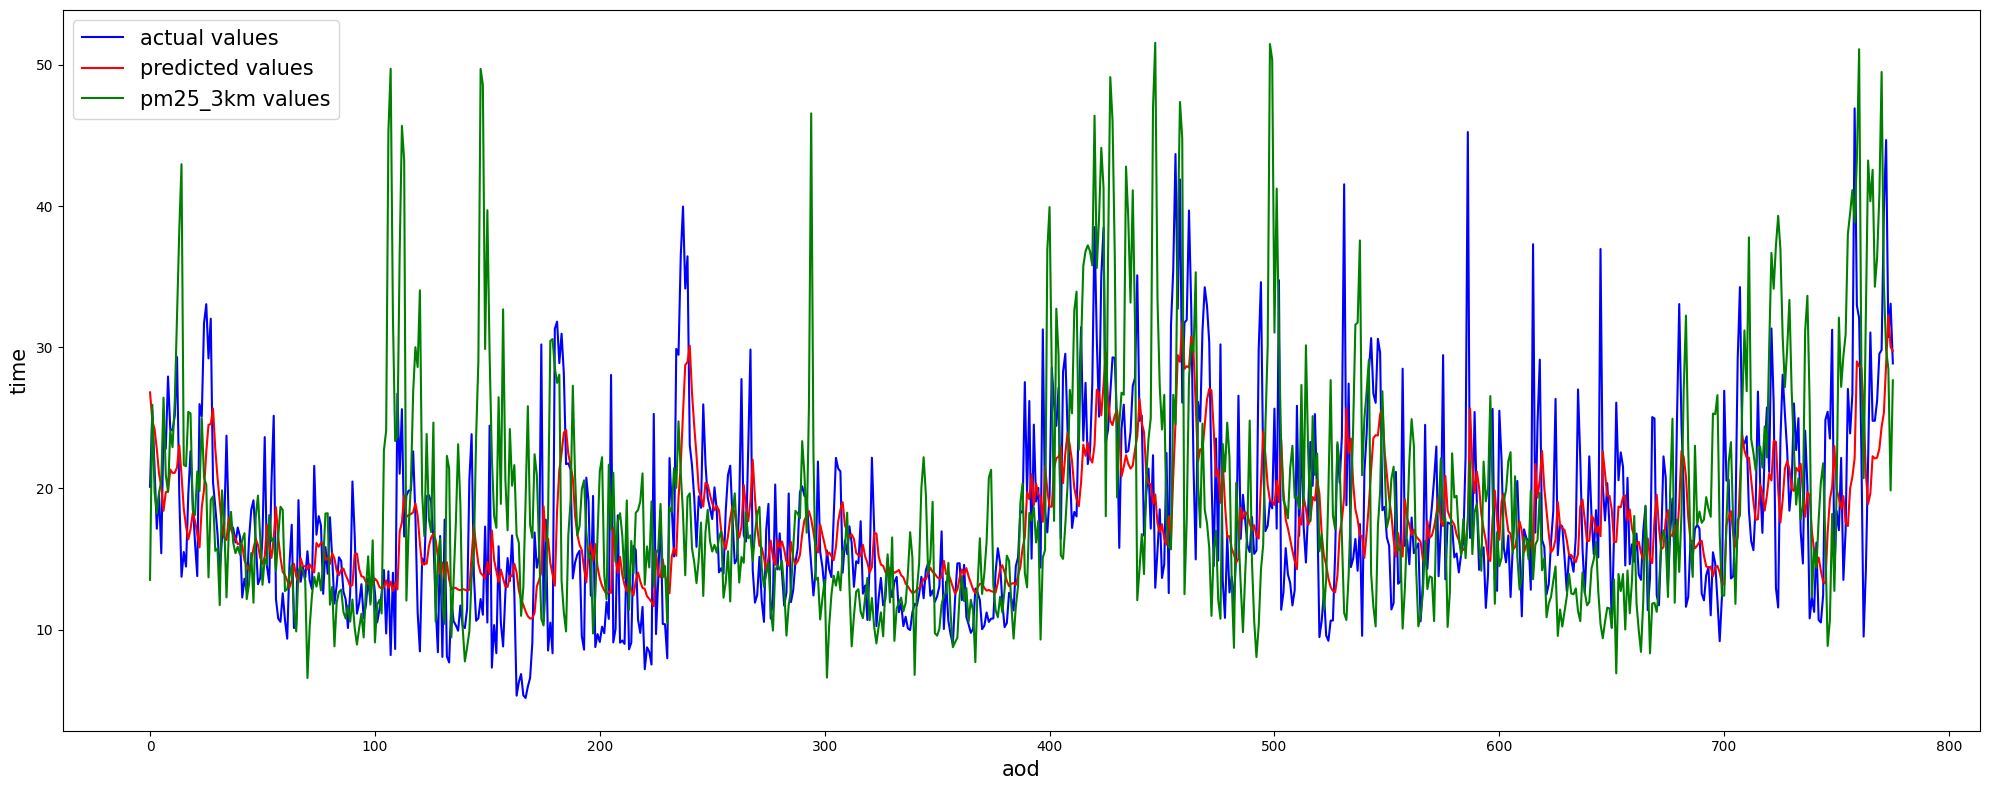

On entire data:
MAE between actual and pm25_3km: 7.875957292759844
MAE between actual and predicted pm25: 6.525796890258789


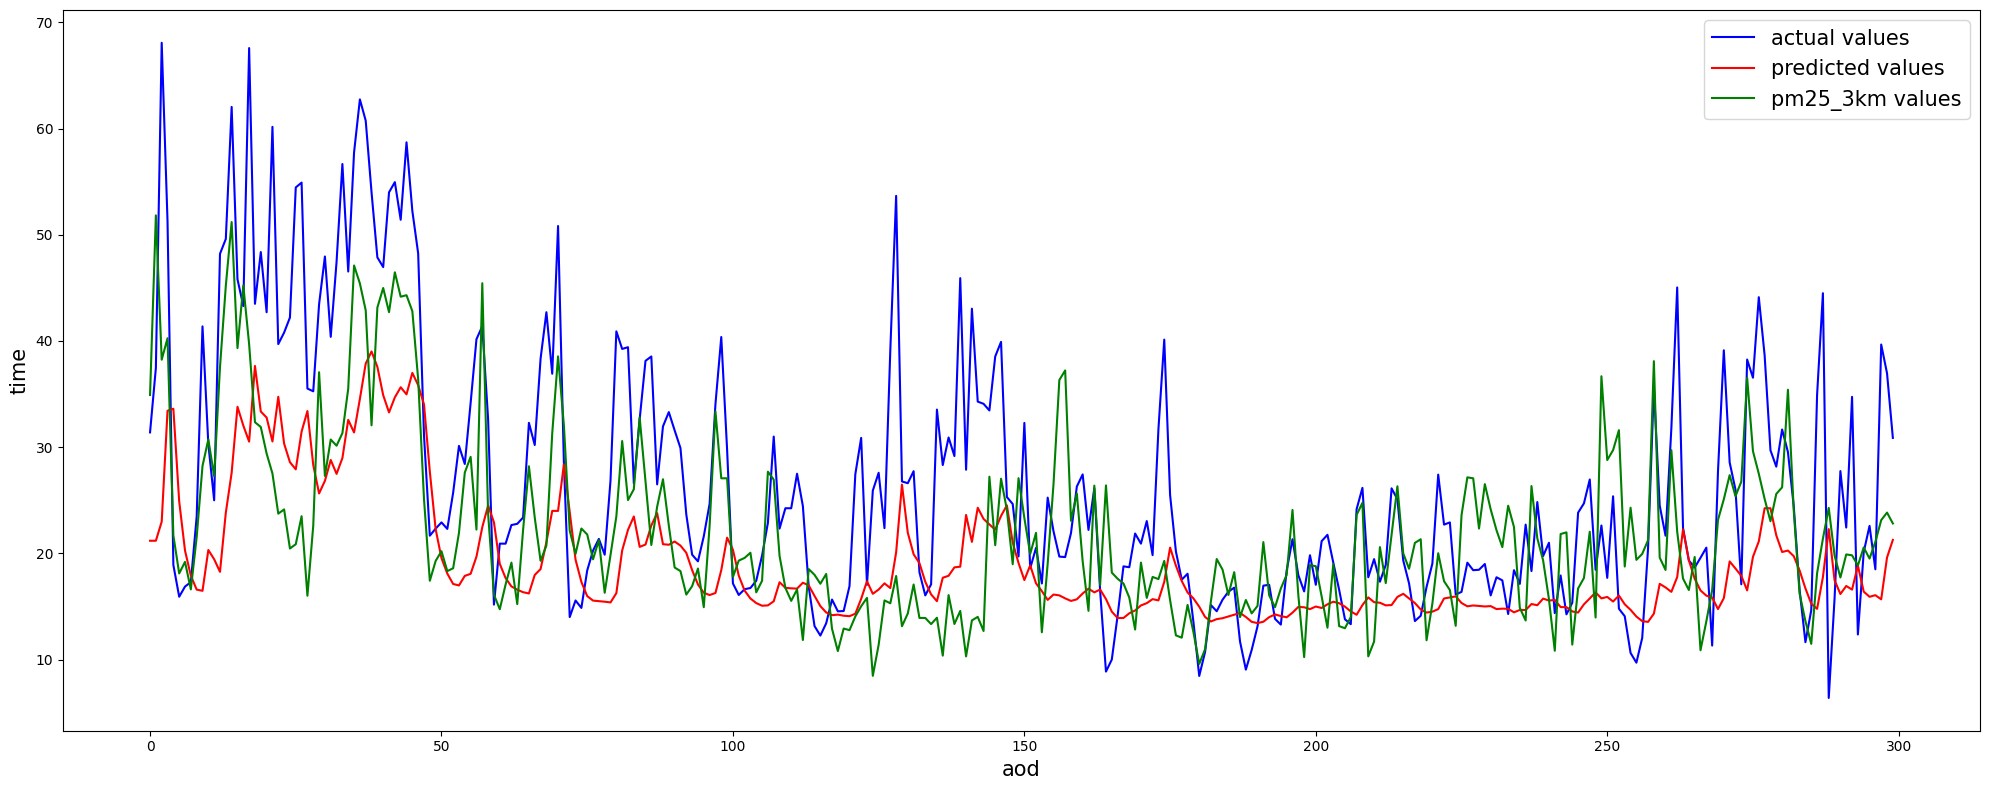

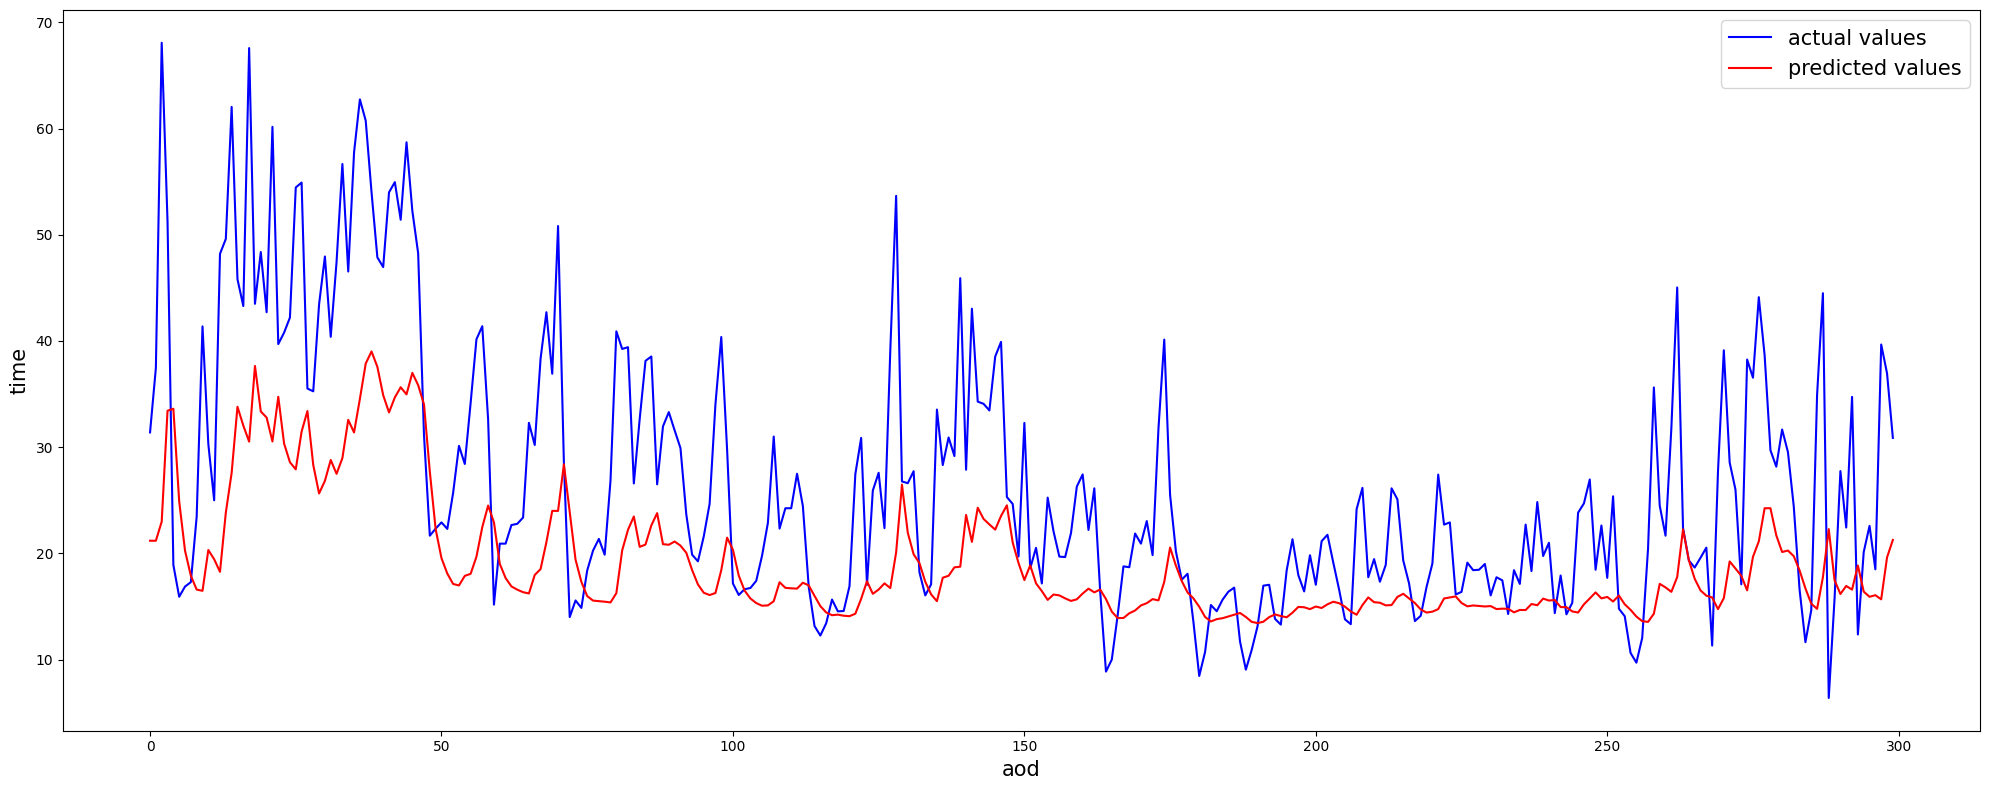

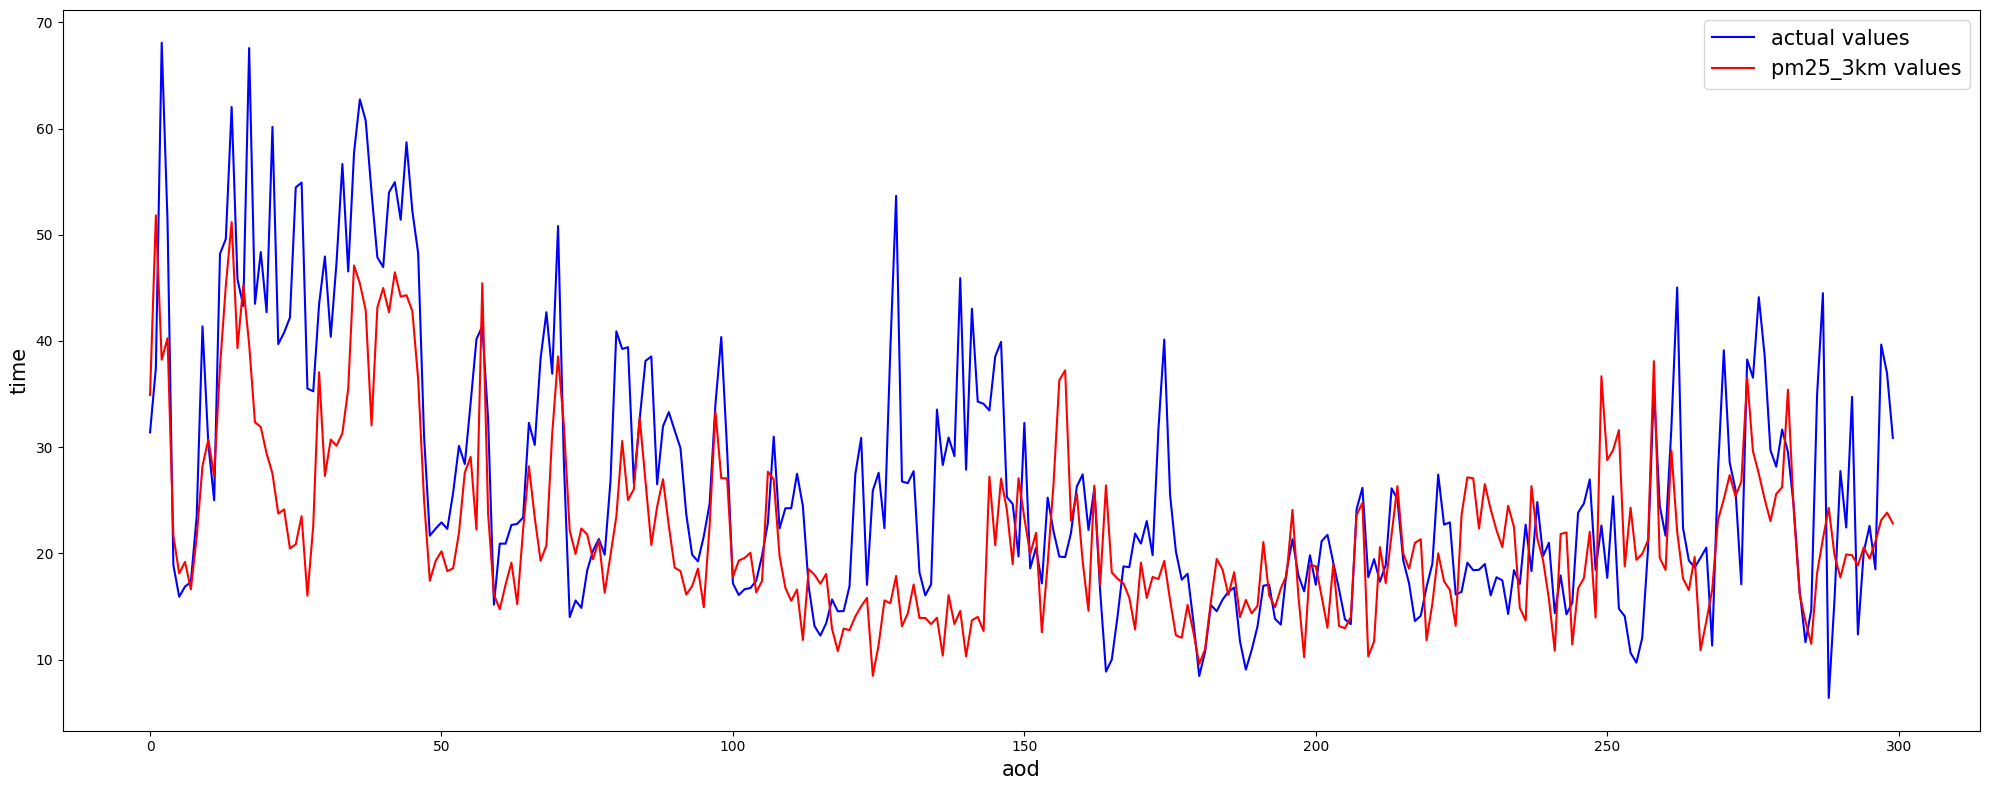

In [32]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
y_pred_all = df_lstms2s_reduced_augmented["hiep_predicted_pm25"]
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, y_pred_all)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")

### Prediction + GRU-Seq2Seq

#### Doing the loop

Model: "aod_GRUSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 7, 100)    │     36,000 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 50),      │     22,800 │ gru[0][0]         │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 10)        │        510 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_18    │ (None, 7, 10)     │          0 │ dense_26[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 7, 50)     │      9,300 │ repeat_vector_18… │
│                     │                   │            │ gru_1[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, 7, 18)     │      1,818 │ gru_3[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 348,086 (1.33 MB)

 Trainable params: 116,028 (453.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,058 (906.48 KB)

None


Model: "aod_GRUSeq2SeqReduction_10_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,310 (231.68 KB)

 Trainable params: 59,310 (231.68 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_52 (LSTM)      │ [(None, 64),      │     19,456 │ input_layer_28[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_19    │ (None, 1, 64)     │          0 │ lstm_52[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_53 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_19… │
│                     │                   │            │ lstm_52[0][1],    │
│                     │                   │            │ lstm_52[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1, 64)     │          0 │ lstm_53[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, 1, 1)      │         65 │ dropout_10[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

None


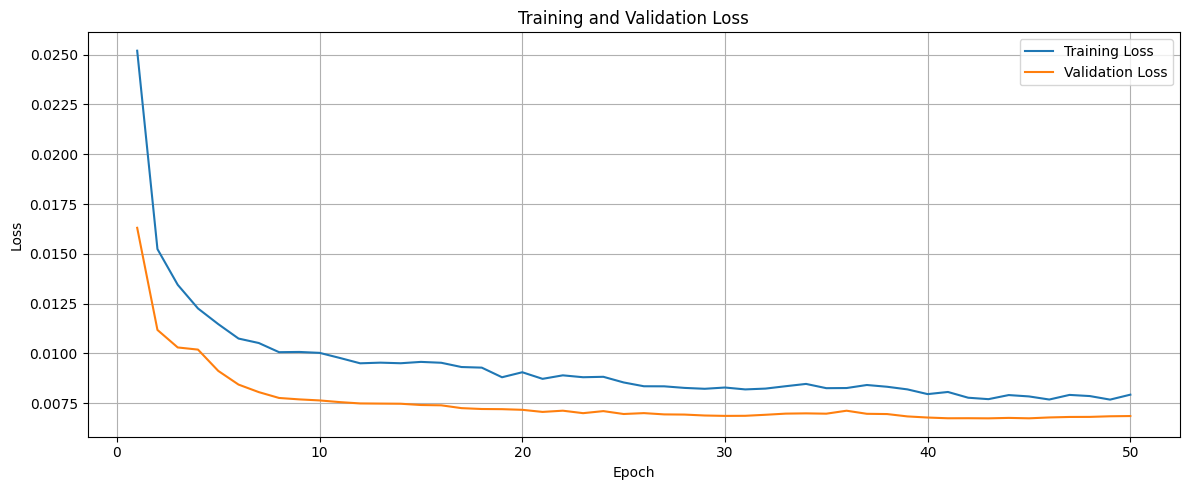

Model: "aod_GRUSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 7, 100)    │     36,000 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 50),      │     22,800 │ gru_4[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 11)        │        561 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_20    │ (None, 7, 11)     │          0 │ dense_29[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 7, 50)     │      9,450 │ repeat_vector_20… │
│                     │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, 7, 18)     │      1,818 │ gru_7[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 348,689 (1.33 MB)

 Trainable params: 116,229 (454.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,460 (908.05 KB)

None


Model: "aod_GRUSeq2SeqReduction_11_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,361 (231.88 KB)

 Trainable params: 59,361 (231.88 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_54 (LSTM)      │ [(None, 64),      │     19,712 │ input_layer_31[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_21    │ (None, 1, 64)     │          0 │ lstm_54[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_55 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_21… │
│                     │                   │            │ lstm_54[0][1],    │
│                     │                   │            │ lstm_54[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 1, 64)     │          0 │ lstm_55[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, 1, 1)      │         65 │ dropout_11[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

None


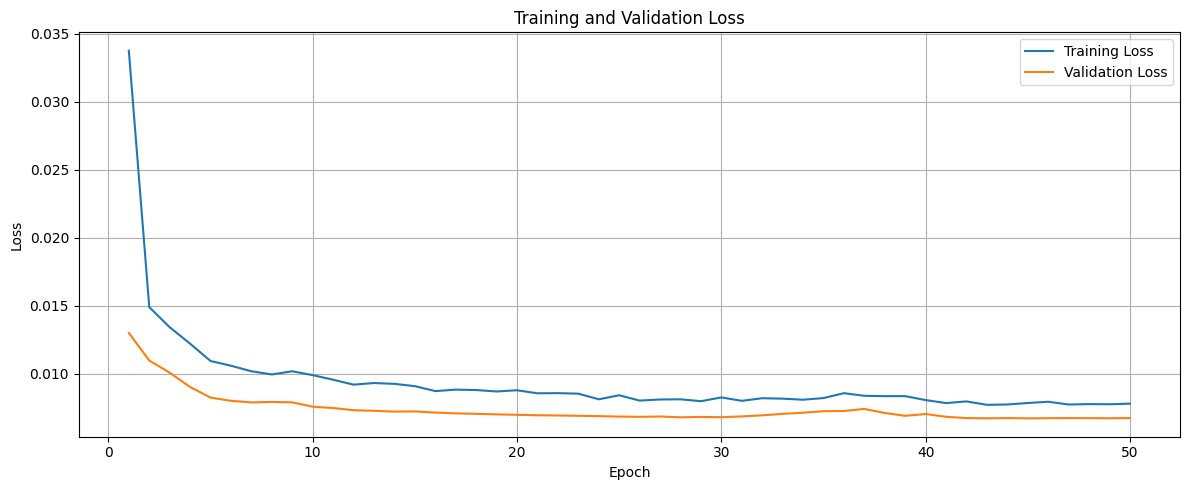

Model: "aod_GRUSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 7, 100)    │     36,000 │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ [(None, 50),      │     22,800 │ gru_8[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 12)        │        612 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_22    │ (None, 7, 12)     │          0 │ dense_32[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 7, 50)     │      9,600 │ repeat_vector_22… │
│                     │                   │            │ gru_9[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, 7, 18)     │      1,818 │ gru_11[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,292 (1.33 MB)

 Trainable params: 116,430 (454.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,862 (909.62 KB)

None


Model: "aod_GRUSeq2SeqReduction_12_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,412 (232.08 KB)

 Trainable params: 59,412 (232.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_56 (LSTM)      │ [(None, 64),      │     19,968 │ input_layer_34[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_23    │ (None, 1, 64)     │          0 │ lstm_56[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_57 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_23… │
│                     │                   │            │ lstm_56[0][1],    │
│                     │                   │            │ lstm_56[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 1, 64)     │          0 │ lstm_57[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, 1, 1)      │         65 │ dropout_12[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

None


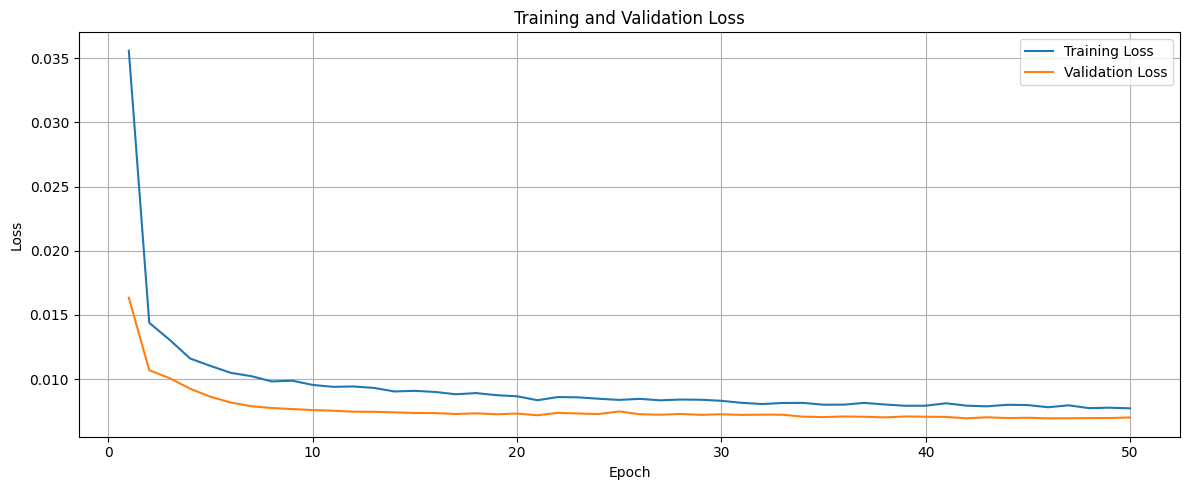

Model: "aod_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_35[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, 50),      │     22,800 │ gru_12[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 13)        │        663 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_24    │ (None, 7, 13)     │          0 │ dense_35[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 7, 50)     │      9,750 │ repeat_vector_24… │
│                     │                   │            │ gru_13[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 7, 18)     │      1,818 │ gru_15[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,895 (1.33 MB)

 Trainable params: 116,631 (455.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,264 (911.19 KB)

None


Model: "aod_GRUSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,463 (232.28 KB)

 Trainable params: 59,463 (232.28 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_58 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_37[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_25    │ (None, 1, 64)     │          0 │ lstm_58[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_59 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_25… │
│                     │                   │            │ lstm_58[0][1],    │
│                     │                   │            │ lstm_58[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 1, 64)     │          0 │ lstm_59[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, 1, 1)      │         65 │ dropout_13[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

None


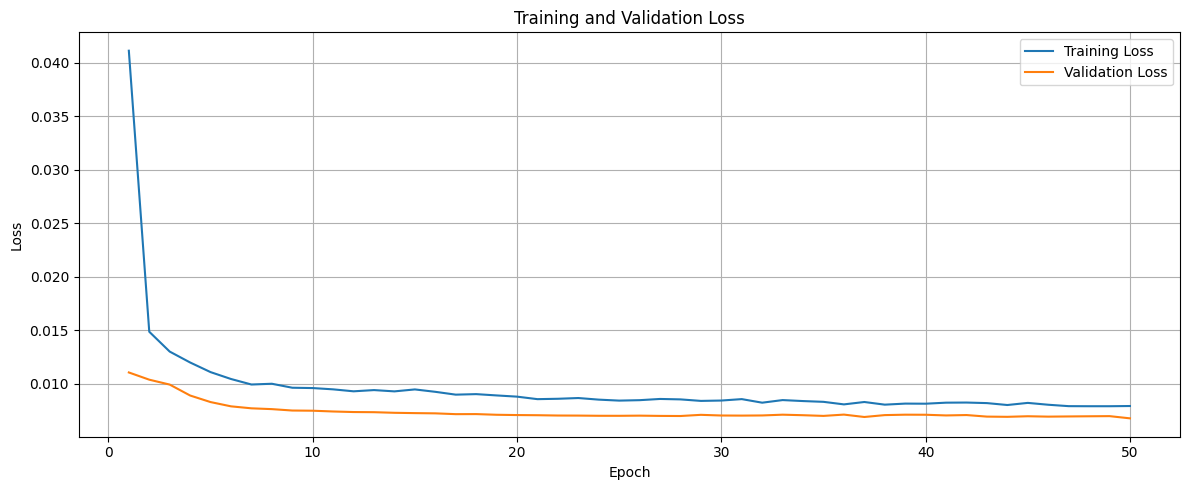

Model: "aod_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ [(None, 50),      │     22,800 │ gru_16[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 14)        │        714 │ gru_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_26    │ (None, 7, 14)     │          0 │ dense_38[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 7, 50)     │      9,900 │ repeat_vector_26… │
│                     │                   │            │ gru_17[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, 7, 18)     │      1,818 │ gru_19[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 350,498 (1.34 MB)

 Trainable params: 116,832 (456.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,666 (912.76 KB)

None


Model: "aod_GRUSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,514 (232.48 KB)

 Trainable params: 59,514 (232.48 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_60 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_40[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_27    │ (None, 1, 64)     │          0 │ lstm_60[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_61 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_27… │
│                     │                   │            │ lstm_60[0][1],    │
│                     │                   │            │ lstm_60[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 1, 64)     │          0 │ lstm_61[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 1, 1)      │         65 │ dropout_14[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

None


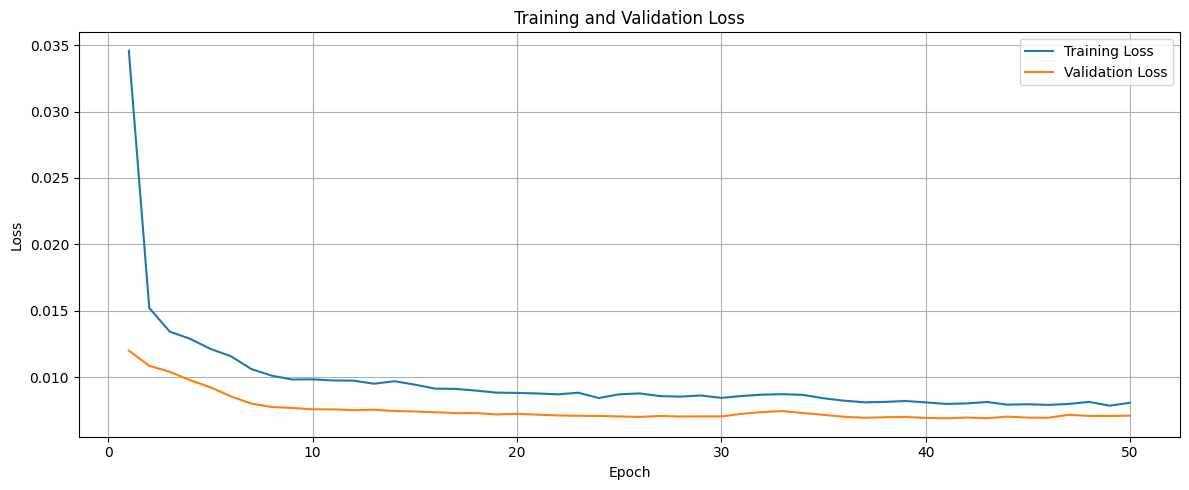

Model: "aod_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_20 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_41[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_21 (GRU)        │ [(None, 50),      │     22,800 │ gru_20[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 15)        │        765 │ gru_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_28    │ (None, 7, 15)     │          0 │ dense_41[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_22 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_28… │
│                     │                   │            │ gru_21[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_23 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, 7, 18)     │      1,818 │ gru_23[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,101 (1.34 MB)

 Trainable params: 117,033 (457.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,068 (914.33 KB)

None


Model: "aod_GRUSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,565 (232.68 KB)

 Trainable params: 59,565 (232.68 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_62 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_43[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_29    │ (None, 1, 64)     │          0 │ lstm_62[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_63 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_29… │
│                     │                   │            │ lstm_62[0][1],    │
│                     │                   │            │ lstm_62[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 1, 64)     │          0 │ lstm_63[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, 1, 1)      │         65 │ dropout_15[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

None


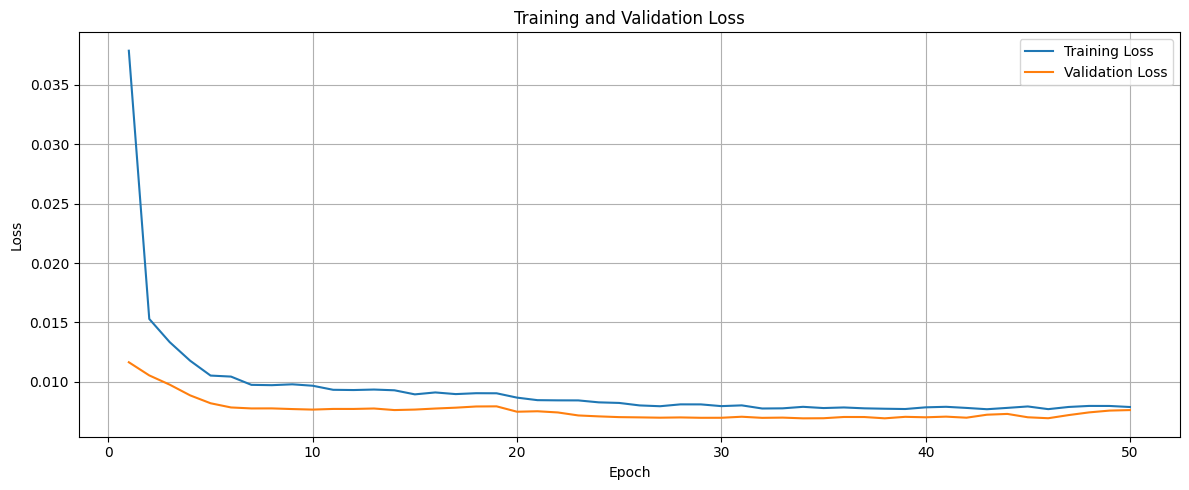

Model: "aod_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_24 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_44[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_25 (GRU)        │ [(None, 50),      │     22,800 │ gru_24[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 16)        │        816 │ gru_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_30    │ (None, 7, 16)     │          0 │ dense_44[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_26 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_30… │
│                     │                   │            │ gru_25[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_27 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, 7, 18)     │      1,818 │ gru_27[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,704 (1.34 MB)

 Trainable params: 117,234 (457.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,470 (915.90 KB)

None


Model: "aod_GRUSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,616 (232.88 KB)

 Trainable params: 59,616 (232.88 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_64 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_46[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_31    │ (None, 1, 64)     │          0 │ lstm_64[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_65 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_31… │
│                     │                   │            │ lstm_64[0][1],    │
│                     │                   │            │ lstm_64[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 1, 64)     │          0 │ lstm_65[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_31 │ (None, 1, 1)      │         65 │ dropout_16[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,081 (211.25 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

None


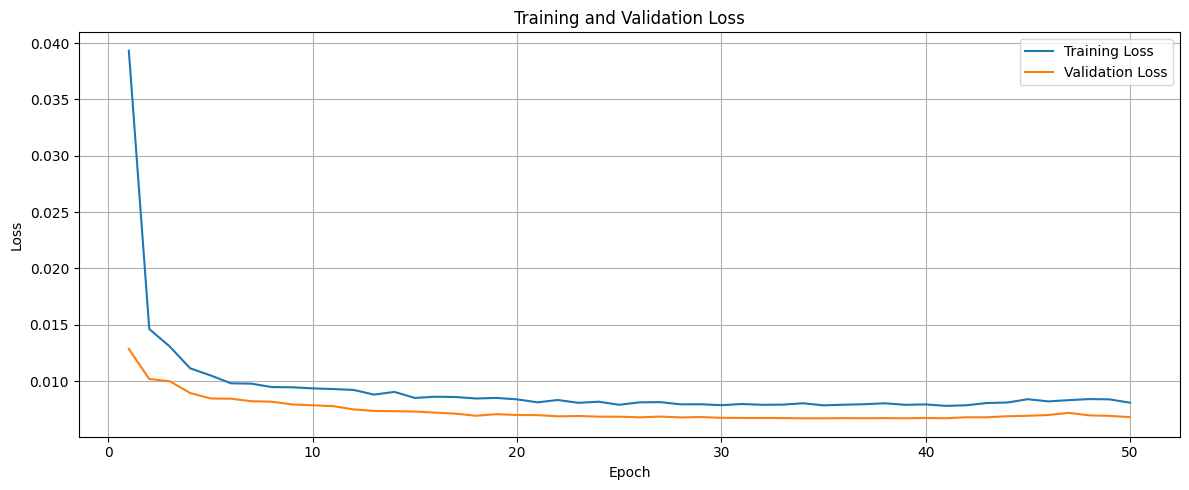

Model: "aod_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_47      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_28 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_47[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_29 (GRU)        │ [(None, 50),      │     22,800 │ gru_28[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 17)        │        867 │ gru_29[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_32    │ (None, 7, 17)     │          0 │ dense_47[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_30 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_32… │
│                     │                   │            │ gru_29[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_31 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_32 │ (None, 7, 18)     │      1,818 │ gru_31[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,307 (1.34 MB)

 Trainable params: 117,435 (458.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,872 (917.47 KB)

None


Model: "aod_GRUSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_28 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,667 (233.07 KB)

 Trainable params: 59,667 (233.07 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_49      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_66 (LSTM)      │ [(None, 64),      │     21,248 │ input_layer_49[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_33    │ (None, 1, 64)     │          0 │ lstm_66[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_67 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_33… │
│                     │                   │            │ lstm_66[0][1],    │
│                     │                   │            │ lstm_66[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 1, 64)     │          0 │ lstm_67[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_33 │ (None, 1, 1)      │         65 │ dropout_17[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,337 (212.25 KB)

 Non-trainable params: 0 (0.00 B)

None


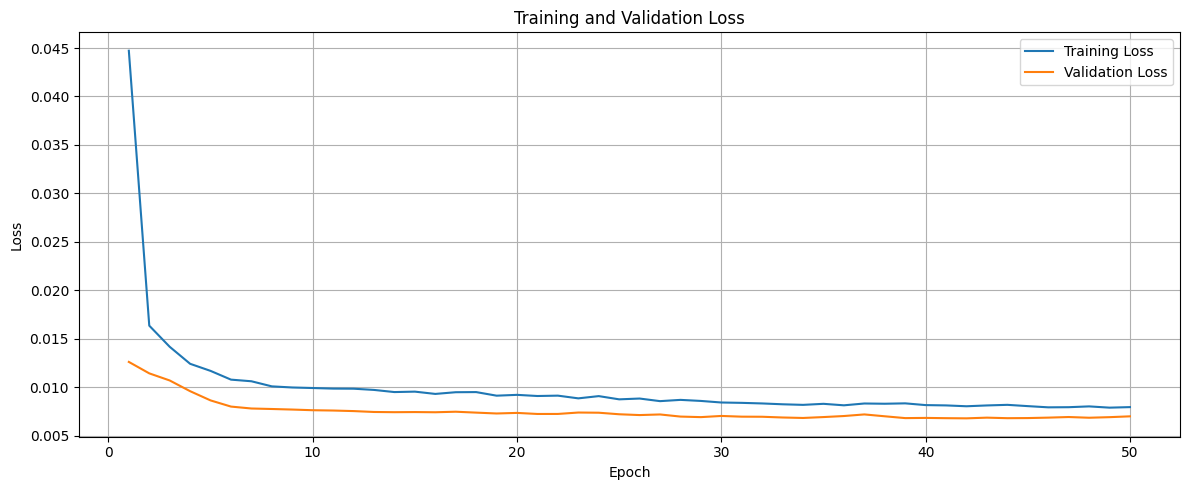

Choosing the best result

dict_keys([10, 11, 12, 13, 14, 15, 16, 17])
N = 10
mae = 4.08372906914977
mse = 29.377622685514943
rmse = 5.420112792693058
r2 = -0.5945320058865655
mape = 0.22839383574725056
N = 11
mae = 4.322831005538316
mse = 30.630363103961134
rmse = 5.5344704447635396
r2 = -0.5399241576720986
mape = 0.23067128097866113
N = 12
mae = 4.521564912562996
mse = 32.01256449362709
rmse = 5.657964695332332
r2 = -0.727197273335298
mape = 0.23676673379535196
N = 13
mae = 4.125585687351978
mse = 29.600407898372385
rmse = 5.440625689970997
r2 = -0.640872980905574
mape = 0.2291509266085101
N = 14
mae = 4.081654894228868
mse = 29.985601798041955
rmse = 5.47591104730911
r2 = -0.7290480957354071
mape = 0.2320879385147844
N = 15
mae = 4.006453388108727
mse = 30.004036599542598
rmse = 5.477594052094642
r2 = -0.7776652235366959
mape = 0.23468279099185643
N = 16
mae = 4.042656375641142
mse = 29.36336821062397
rmse = 5.418797672050874
r2 = -0.48743605171923776
mape = 0.22880823931583438
N = 1

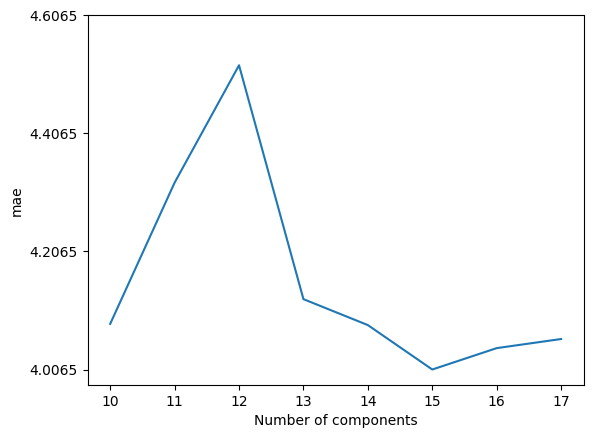

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


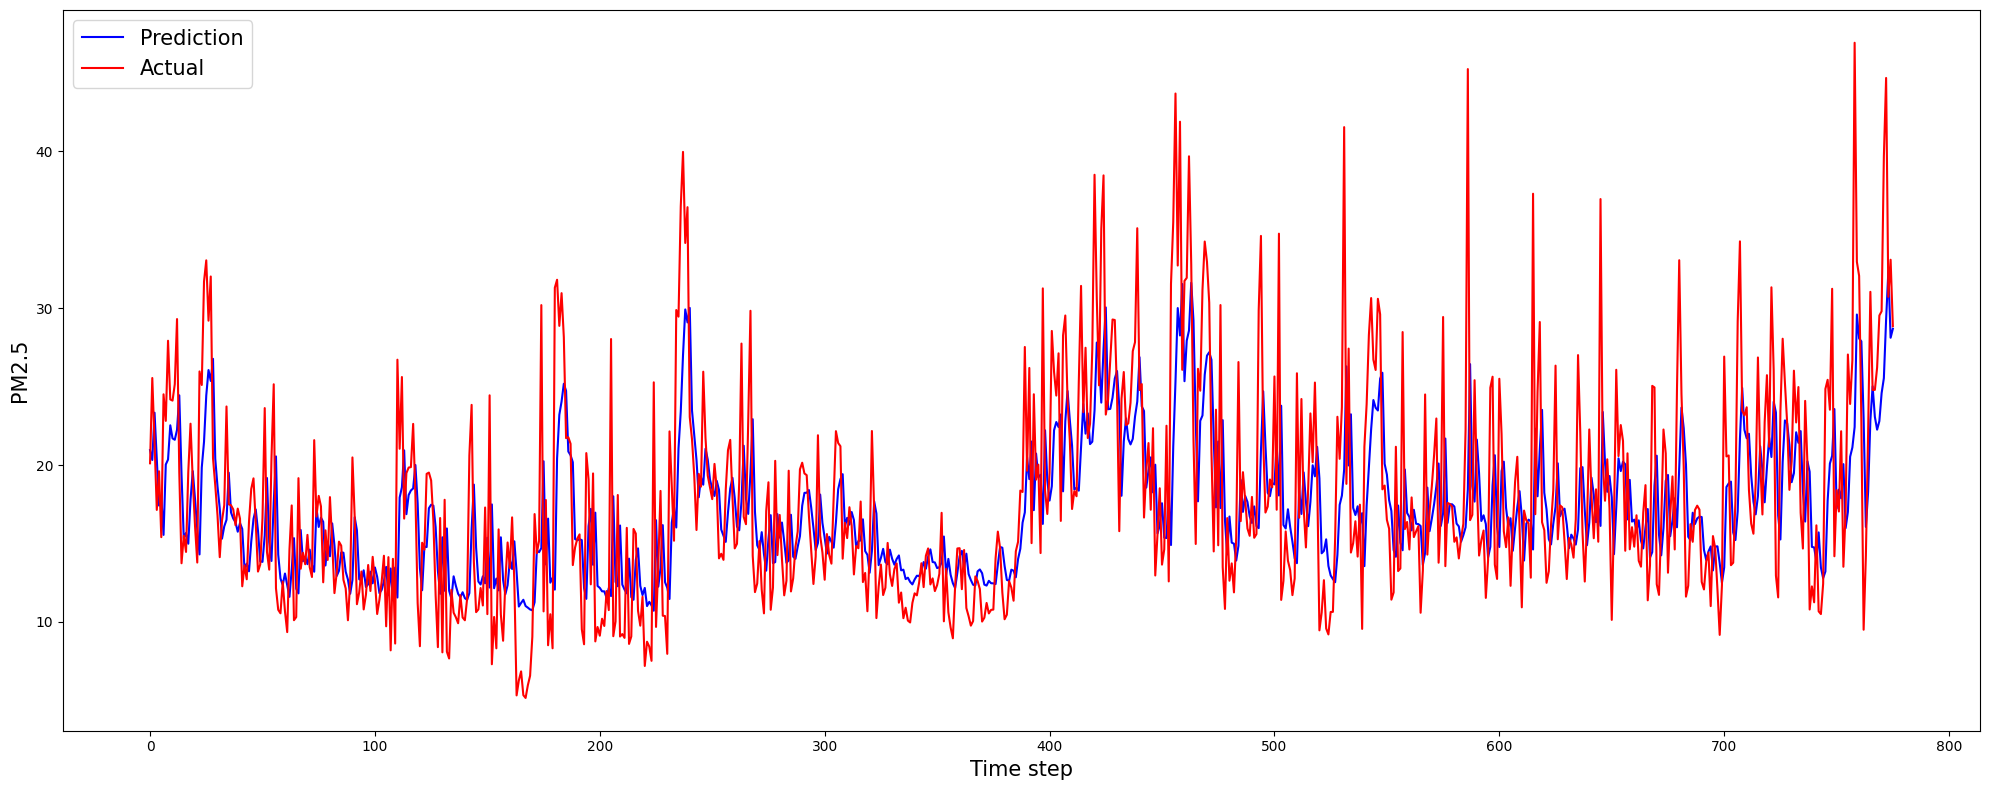

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  4.403112  32.664239   
1         LSTM-Seq2Seq                  12       LSTM  4.166520  31.095105   
2          GRU-Seq2Seq                  15       LSTM  4.006453  30.004037   

       rmse        r2      mape  
0  5.715264 -0.778659  0.242072  
1  5.576299 -1.058266  0.238840  
2  5.477594 -0.777665  0.234683

In [33]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, GRUSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [34]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022.csv"))
df_grus2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.013685       0.009156       0.158953       0.052635   
2018-01-02       0.013685       0.009156       0.158953       0.052635   
2018-01-03       0.013504       0.009064       0.158810       0.052242   
2018-01-04       0.012937       0.008792       0.160128       0.051551   
2018-01-05       0.012666       0.008593       0.160832       0.051342   
...                   ...            ...            ...            ...   
2022-12-27       0.024884       0.046121       0.068872       0.050939   
2022-12-28       0.024800       0.046071       0.069134       0.051114   
2022-12-29       0.024937       0.046207       0.069137       0.050919   
2022-12-30       0.025026       0.046352       0.069301       0.050740   
2022-12-31       0.024863       0.046130       0.069211       0.050614   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.044192       0.042328       0.018305       0.045563   
2018-01-02       0.044192       0.042328       0.018305       0.045563   
2018-01-03       0.044119       0.041941       0.018193       0.045479   
2018-01-04       0.043215       0.041080       0.017617       0.044960   
2018-01-05       0.043017       0.040558       0.017307       0.044449   
...                   ...            ...            ...            ...   
2022-12-27       0.115772       0.019885       0.064278       0.059044   
2022-12-28       0.115823       0.019854       0.064281       0.059284   
2022-12-29       0.115496       0.019890       0.064327       0.059165   
2022-12-30       0.115132       0.019892       0.064398       0.058973   
2022-12-31       0.115122       0.019809       0.064253       0.058699   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.108458        0.038883        0.101688        0.018714   
2018-01-02       0.108458        0.038883        0.101688        0.018714   
2018-01-03       0.108314        0.038597        0.101471        0.018601   
2018-01-04       0.107572        0.038021        0.101507        0.018064   
2018-01-05       0.107900        0.037800        0.101617        0.017741   
...                   ...             ...             ...             ...   
2022-12-27       0.090868        0.120308        0.084663        0.054712   
2022-12-28       0.090630        0.119577        0.084634        0.054646   
2022-12-29       0.090487        0.120203        0.084614        0.054532   
2022-12-30       0.090218        0.121126        0.084923        0.054342   
2022-12-31       0.090578        0.121726        0.085216        0.054225   

            aod_feature_13  aod_feature_14  aod_feature_15  station  
time                                                                 
2018-01-01        0.257939        0.067628        0.021873      201  
2018-01-02        0.257939        0.067628        0.021873      201  
2018-01-03        0.260656        0.067285        0.021726      201  
2018-01-04        0.266408        0.066840        0.021308      201  
2018-01-05        0.268876        0.066309        0.020993      201  
...                    ...             ...             ...      ...  
2022-12-27        0.120214        0.055527        0.023913      216  
2022-12-28        0.120899        0.055368        0.023885      216  
2022-12-29        0.120464        0.055659        0.023961      216  
2022-12-30        0.119533        0.056121        0.023923      216  
2022-12-31        0.119441        0.056256        0.023856      216  

[3889 rows x 16 columns]

In [35]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_grus2s_reduced_augmented = augmentReducedData(df_grus2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_grus2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_grus2s_reduced_augmented

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.013685       0.009156       0.158953       0.052635   
2018-01-02       0.013685       0.009156       0.158953       0.052635   
2018-01-03       0.013504       0.009064       0.158810       0.052242   
2018-01-04       0.012937       0.008792       0.160128       0.051551   
2018-01-05       0.012666       0.008593       0.160832       0.051342   
...                   ...            ...            ...            ...   
2022-12-27       0.024884       0.046121       0.068872       0.050939   
2022-12-28       0.024800       0.046071       0.069134       0.051114   
2022-12-29       0.024937       0.046207       0.069137       0.050919   
2022-12-30       0.025026       0.046352       0.069301       0.050740   
2022-12-31       0.024863       0.046130       0.069211       0.050614   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01       0.044192       0.042328       0.018305       0.045563   
2018-01-02       0.044192       0.042328       0.018305       0.045563   
2018-01-03       0.044119       0.041941       0.018193       0.045479   
2018-01-04       0.043215       0.041080       0.017617       0.044960   
2018-01-05       0.043017       0.040558       0.017307       0.044449   
...                   ...            ...            ...            ...   
2022-12-27       0.115772       0.019885       0.064278       0.059044   
2022-12-28       0.115823       0.019854       0.064281       0.059284   
2022-12-29       0.115496       0.019890       0.064327       0.059165   
2022-12-30       0.115132       0.019892       0.064398       0.058973   
2022-12-31       0.115122       0.019809       0.064253       0.058699   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2018-01-01       0.108458        0.038883        0.101688        0.018714   
2018-01-02       0.108458        0.038883        0.101688        0.018714   
2018-01-03       0.108314        0.038597        0.101471        0.018601   
2018-01-04       0.107572        0.038021        0.101507        0.018064   
2018-01-05       0.107900        0.037800        0.101617        0.017741   
...                   ...             ...             ...             ...   
2022-12-27       0.090868        0.120308        0.084663        0.054712   
2022-12-28       0.090630        0.119577        0.084634        0.054646   
2022-12-29       0.090487        0.120203        0.084614        0.054532   
2022-12-30       0.090218        0.121126        0.084923        0.054342   
2022-12-31       0.090578        0.121726        0.085216        0.054225   

            aod_feature_13  aod_feature_14  aod_feature_15  station  \
time                                                                  
2018-01-01        0.257939        0.067628        0.021873      201   
2018-01-02        0.257939        0.067628        0.021873      201   
2018-01-03        0.260656        0.067285        0.021726      201   
2018-01-04        0.266408        0.066840        0.021308      201   
2018-01-05        0.268876        0.066309        0.020993      201   
...                    ...             ...             ...      ...   
2022-12-27        0.120214        0.055527        0.023913      216   
2022-12-28        0.120899        0.055368        0.023885      216   
2022-12-29        0.120464        0.055659        0.023961      216   
2022-12-30        0.119533        0.056121        0.023923      216   
2022-12-31        0.119441        0.056256        0.023856      216   

             pm25_3km  hiep_predicted_pm25  
time                                        
2018-01-01  34.919998            26.259359  
2018-01-02  51.830002    

#### Compare MAE with pm25_3km

On test data:
MAE between actual and pm25_3km: 6.785086281801943
MAE between actual and predicted pm25: 4.006453388108727
MSE between actual and pm25_3km: 87.2793385941348
MSE between actual and predicted pm25: 30.004036599542598


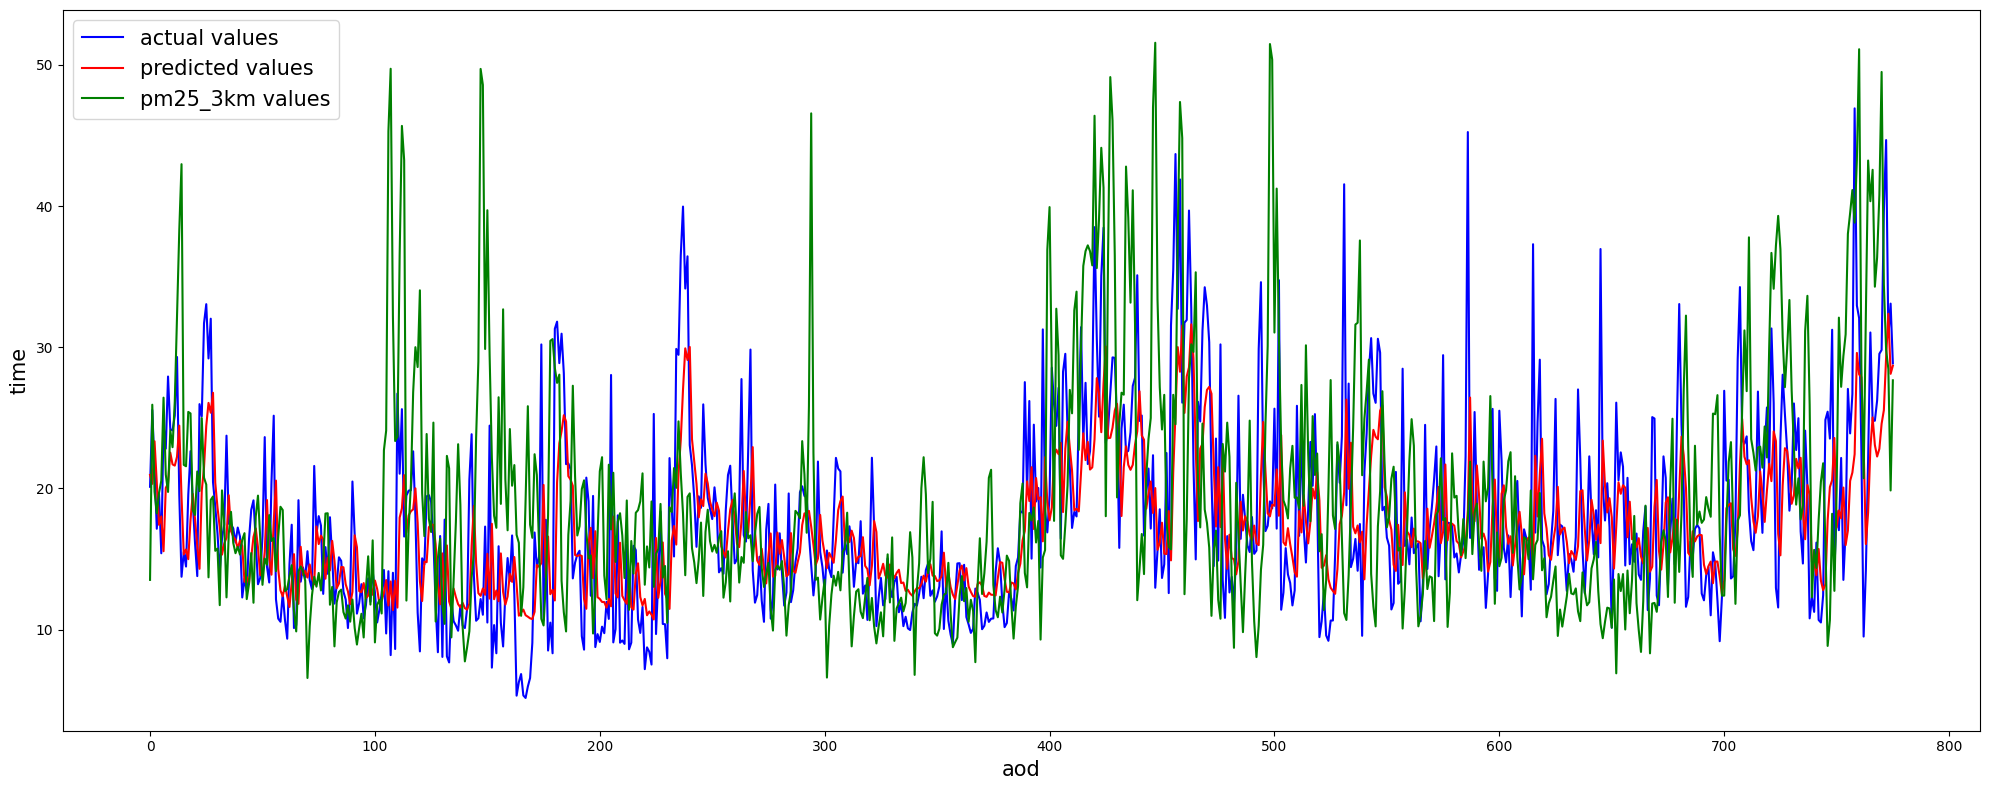

On entire data:
MAE between actual and pm25_3km: 7.875957292759844
MAE between actual and predicted pm25: 5.43709135055542


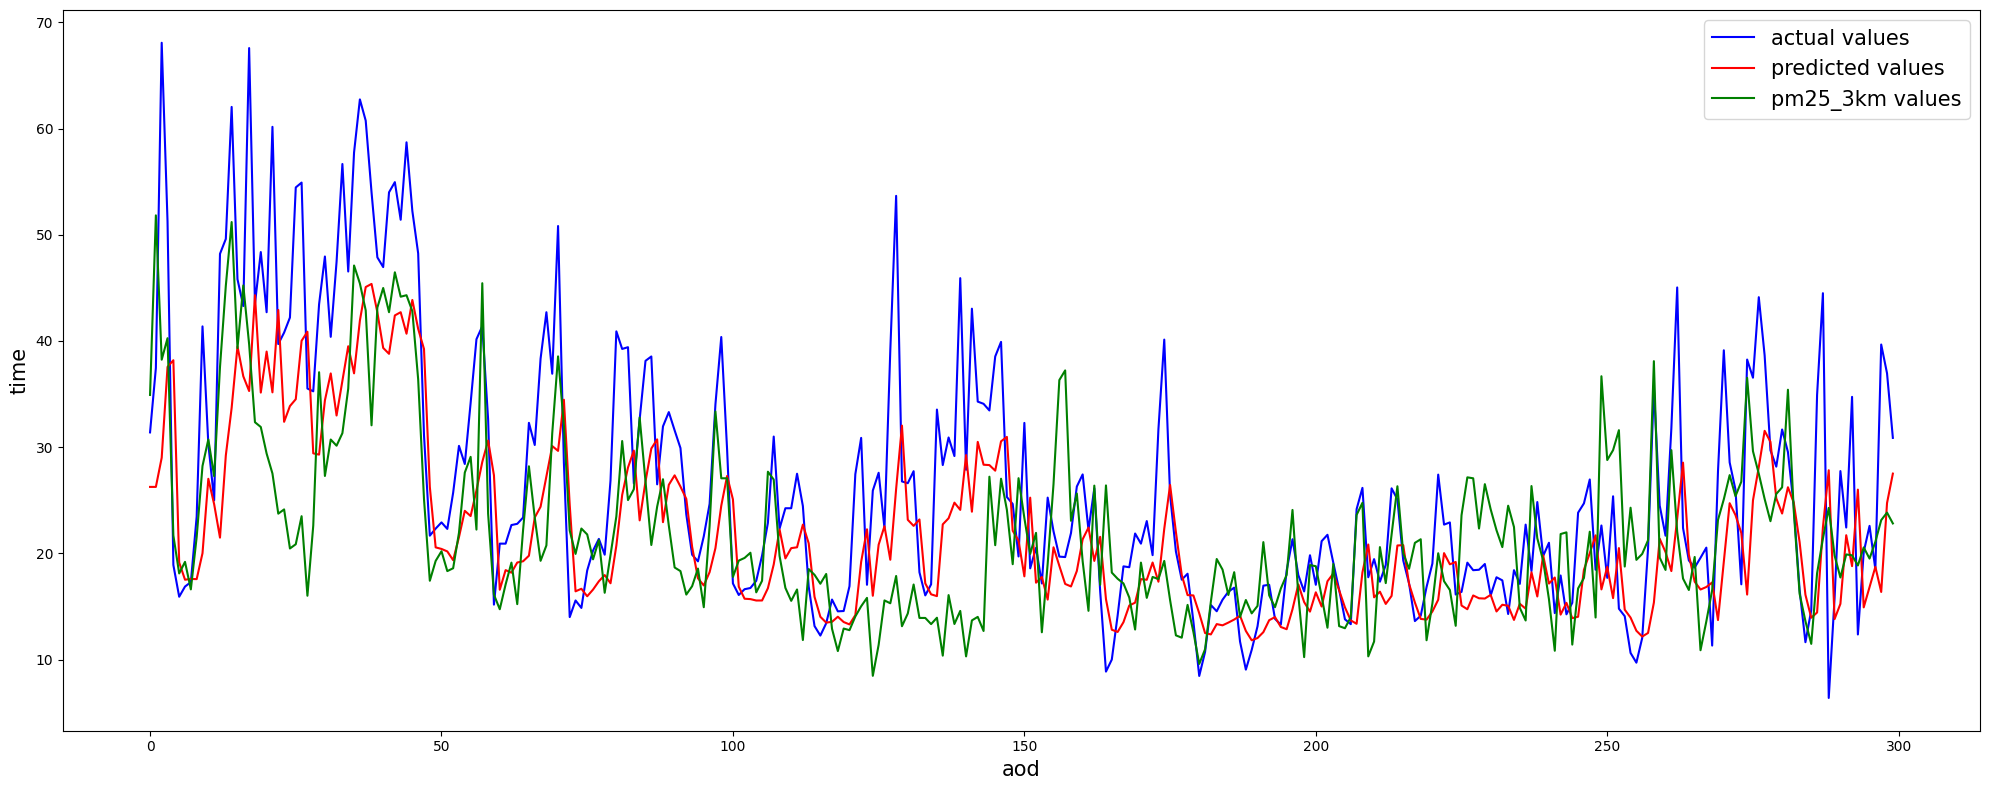

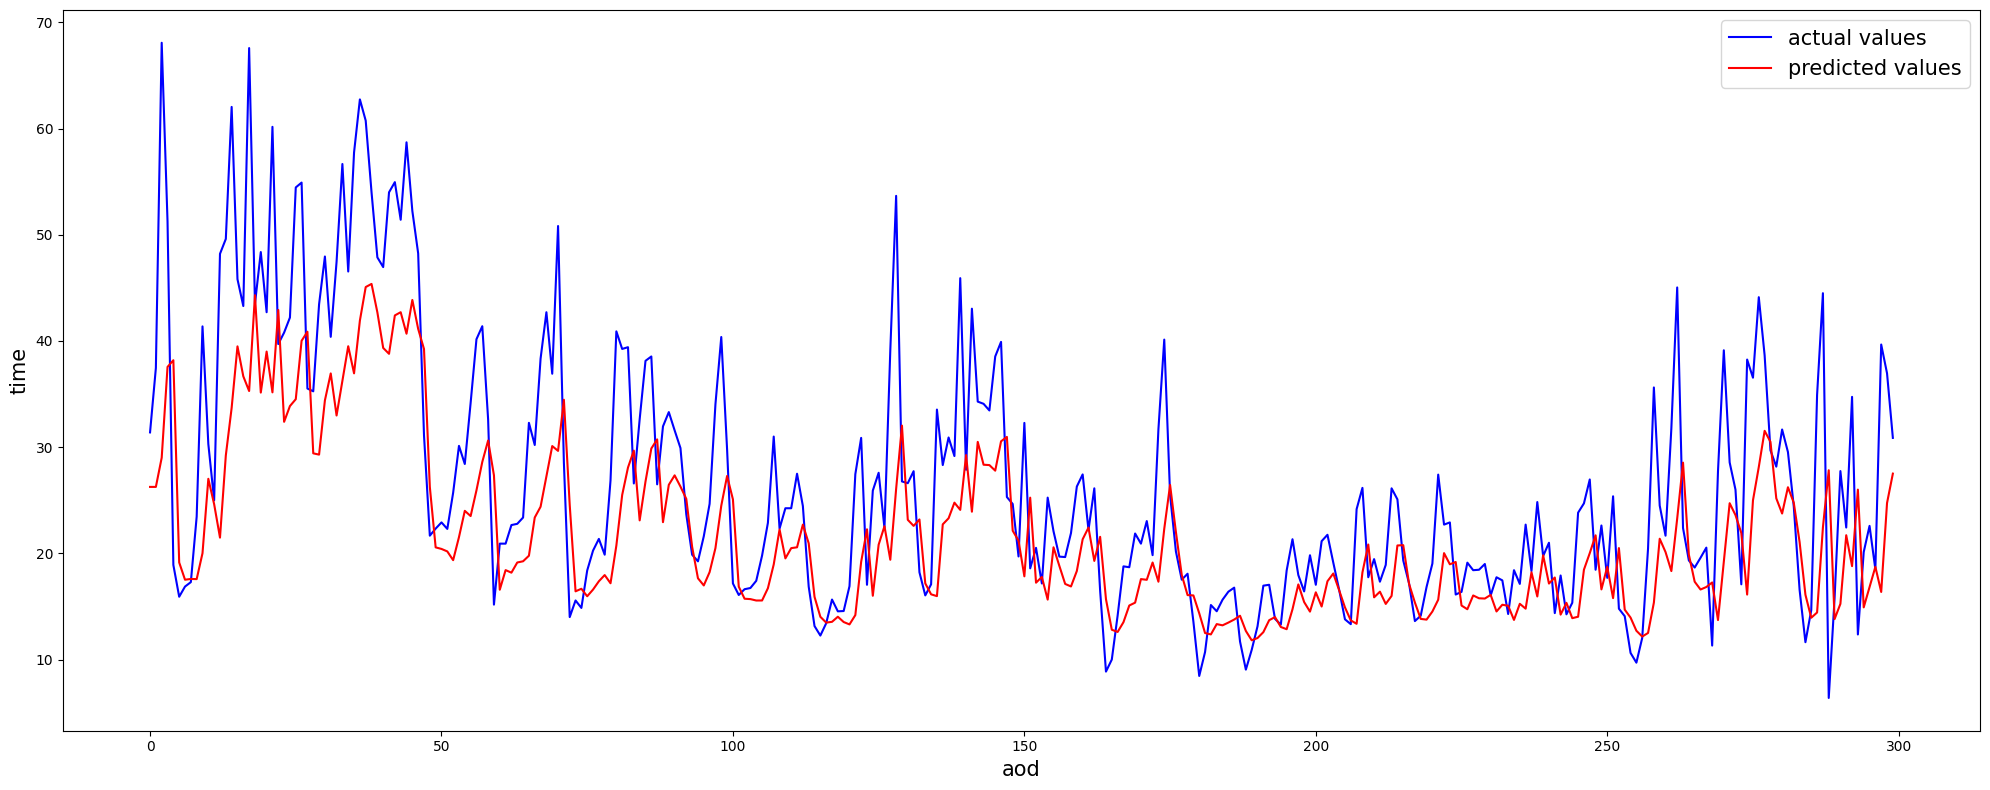

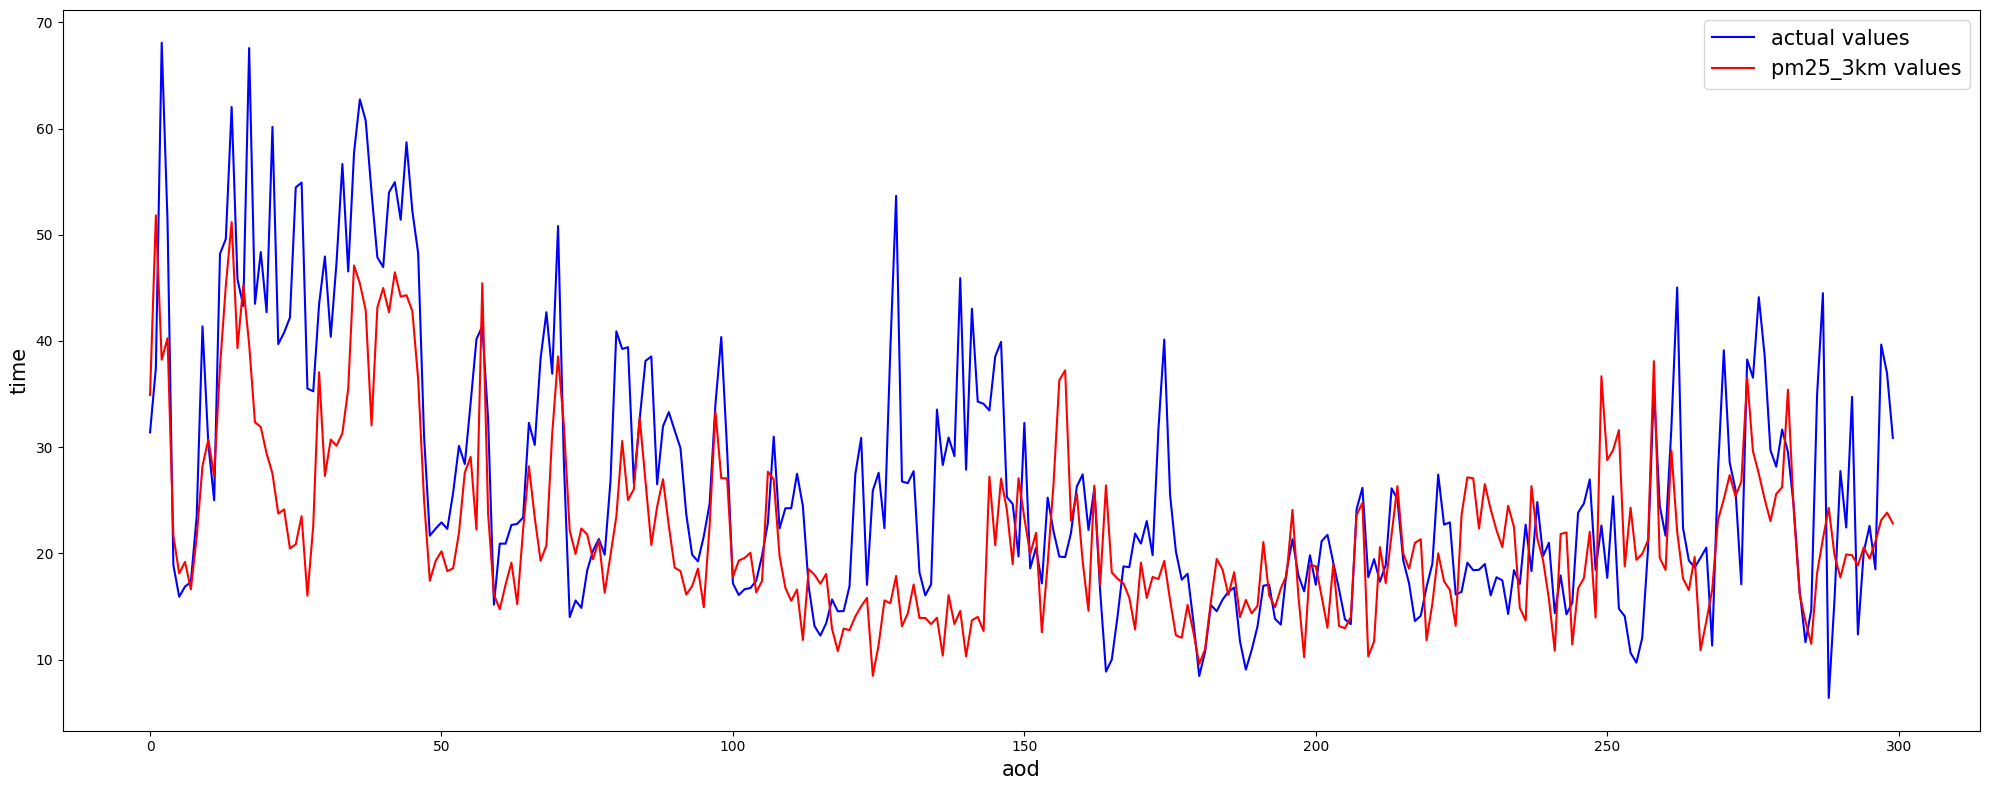

In [36]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
y_pred_all = df_grus2s_reduced_augmented["hiep_predicted_pm25"]
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, y_pred_all)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

Model: "aod_CNNLSTMSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 24)     │      1,320 │ input_layer_51[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1, 12)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12)        │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_35    │ (None, 7, 12)     │          0 │ flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_70 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_35… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 10)        │        510 │ lstm_70[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_36    │ (None, 7, 10)     │          0 │ dense_51[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_71 (LSTM)      │ (None, 7, 50)     │     12,200 │ repeat_vector_36… │
│                     │                   │            │ lstm_70[0][1],    │
│                     │                   │            │ lstm_70[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_35 │ (None, 7, 24)     │      1,224 │ lstm_71[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_36 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,542 (341.96 KB)

 Trainable params: 29,180 (113.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,362 (227.98 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_10_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_52 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_35 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_70 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,306 (59.79 KB)

 Trainable params: 15,306 (59.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_10_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_53      │ (None, 7, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_72 (LSTM)      │ [(None, 64),      │     19,456 │ input_layer_53[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_37    │ (None, 1, 64)     │          0 │ lstm_72[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_73 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_37… │
│                     │                   │            │ lstm_72[0][1],    │
│                     │                   │            │ lstm_72[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 1, 64)     │          0 │ lstm_73[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_37 │ (None, 1, 1)      │         65 │ dropout_19[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

None


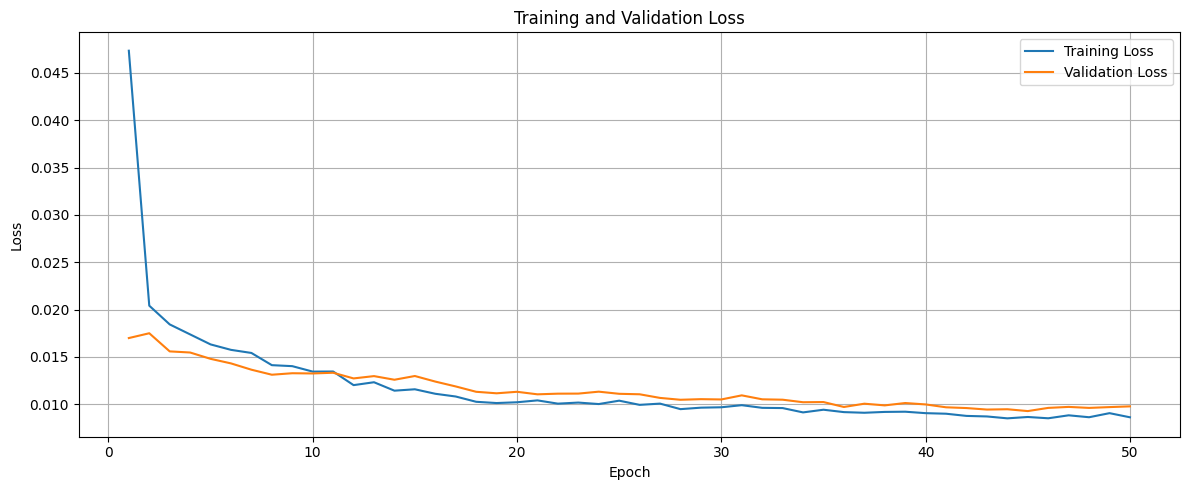

Model: "aod_CNNLSTMSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_54      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5, 24)     │      1,320 │ input_layer_54[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1, 12)     │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_38    │ (None, 7, 12)     │          0 │ flatten_1[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_74 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_38… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 11)        │        561 │ lstm_74[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_39    │ (None, 7, 11)     │          0 │ dense_55[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_75 (LSTM)      │ (None, 7, 50)     │     12,400 │ repeat_vector_39… │
│                     │                   │            │ lstm_74[0][1],    │
│                     │                   │            │ lstm_74[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_38 │ (None, 7, 24)     │      1,224 │ lstm_75[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_39 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 88,295 (344.91 KB)

 Trainable params: 29,431 (114.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,864 (229.94 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_11_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_55 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_38 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 11)             │           561 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,357 (59.99 KB)

 Trainable params: 15,357 (59.99 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_11_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_56      │ (None, 7, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_76 (LSTM)      │ [(None, 64),      │     19,712 │ input_layer_56[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_40    │ (None, 1, 64)     │          0 │ lstm_76[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_77 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_40… │
│                     │                   │            │ lstm_76[0][1],    │
│                     │                   │            │ lstm_76[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 1, 64)     │          0 │ lstm_77[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_40 │ (None, 1, 1)      │         65 │ dropout_20[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

None


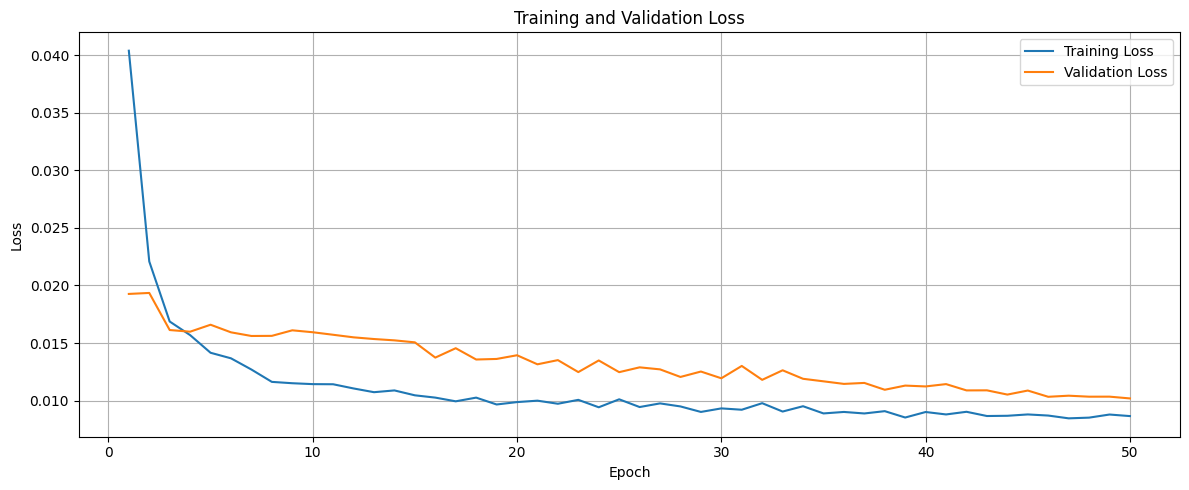

Model: "aod_CNNLSTMSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_57      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5, 24)     │      1,320 │ input_layer_57[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1, 12)     │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_41    │ (None, 7, 12)     │          0 │ flatten_2[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_78 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_41… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 12)        │        612 │ lstm_78[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_42    │ (None, 7, 12)     │          0 │ dense_59[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_79 (LSTM)      │ (None, 7, 50)     │     12,600 │ repeat_vector_42… │
│                     │                   │            │ lstm_78[0][1],    │
│                     │                   │            │ lstm_78[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_41 │ (None, 7, 24)     │      1,224 │ lstm_79[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_42 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,048 (347.85 KB)

 Trainable params: 29,682 (115.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,366 (231.90 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_12_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_58 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_41 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_78 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,408 (60.19 KB)

 Trainable params: 15,408 (60.19 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_12_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_59      │ (None, 7, 13)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_80 (LSTM)      │ [(None, 64),      │     19,968 │ input_layer_59[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_43    │ (None, 1, 64)     │          0 │ lstm_80[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_81 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_43… │
│                     │                   │            │ lstm_80[0][1],    │
│                     │                   │            │ lstm_80[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 1, 64)     │          0 │ lstm_81[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_43 │ (None, 1, 1)      │         65 │ dropout_21[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

None


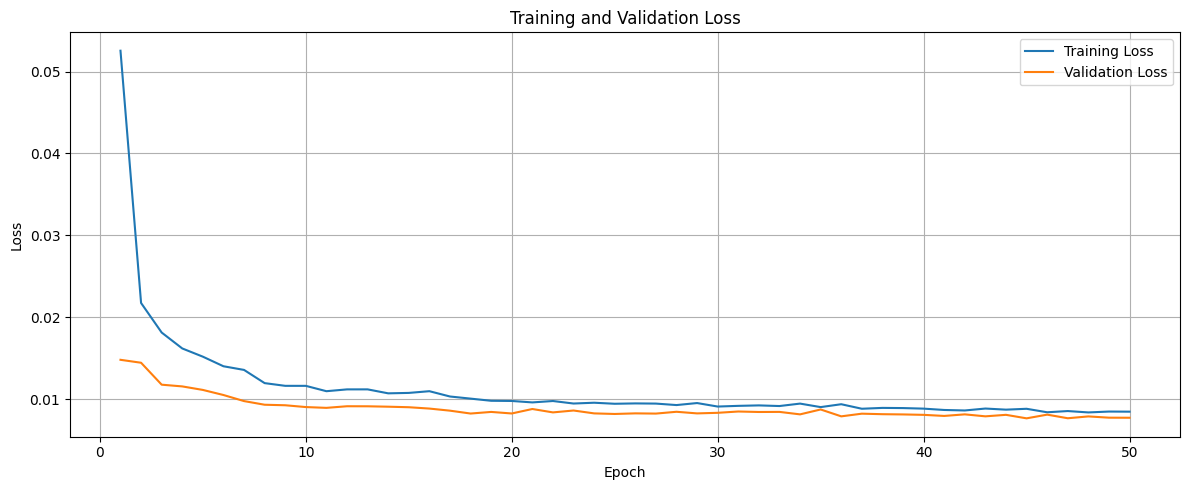

Model: "aod_CNNLSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_60      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5, 24)     │      1,320 │ input_layer_60[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 1, 12)     │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_44    │ (None, 7, 12)     │          0 │ flatten_3[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_82 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_44… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 13)        │        663 │ lstm_82[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_45    │ (None, 7, 13)     │          0 │ dense_63[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_83 (LSTM)      │ (None, 7, 50)     │     12,800 │ repeat_vector_45… │
│                     │                   │            │ lstm_82[0][1],    │
│                     │                   │            │ lstm_82[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_44 │ (None, 7, 24)     │      1,224 │ lstm_83[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_45 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,801 (350.79 KB)

 Trainable params: 29,933 (116.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,868 (233.86 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_61 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_44 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_82 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,459 (60.39 KB)

 Trainable params: 15,459 (60.39 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_62      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_84 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_62[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_46    │ (None, 1, 64)     │          0 │ lstm_84[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_85 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_46… │
│                     │                   │            │ lstm_84[0][1],    │
│                     │                   │            │ lstm_84[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 1, 64)     │          0 │ lstm_85[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_46 │ (None, 1, 1)      │         65 │ dropout_22[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

None


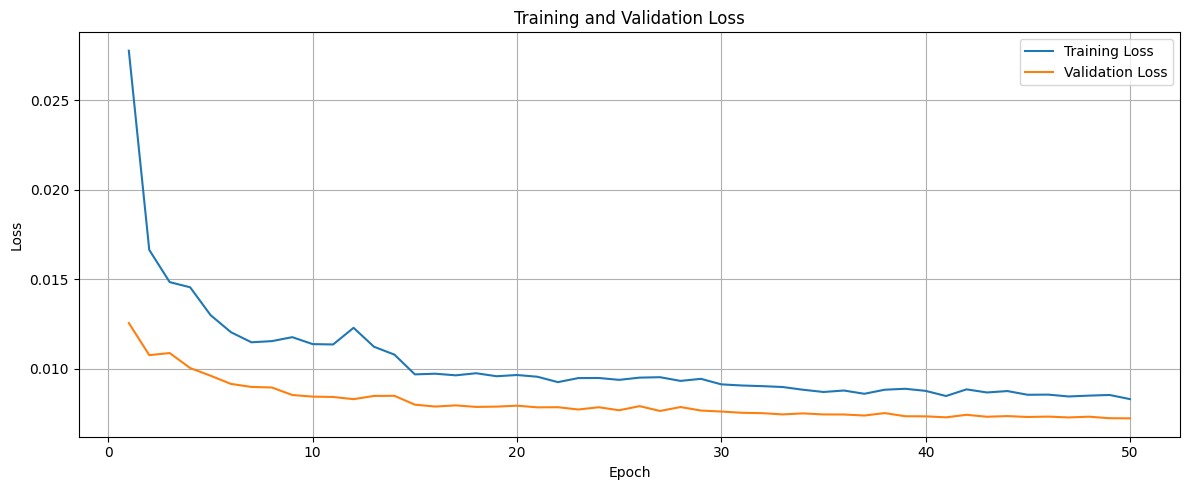

Model: "aod_CNNLSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_63      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 5, 24)     │      1,320 │ input_layer_63[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 3, 12)     │        876 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 1, 12)     │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_47    │ (None, 7, 12)     │          0 │ flatten_4[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_86 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_47… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 14)        │        714 │ lstm_86[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_48    │ (None, 7, 14)     │          0 │ dense_67[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_87 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_48… │
│                     │                   │            │ lstm_86[0][1],    │
│                     │                   │            │ lstm_86[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_47 │ (None, 7, 24)     │      1,224 │ lstm_87[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_48 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 90,554 (353.73 KB)

 Trainable params: 30,184 (117.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,370 (235.82 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_64 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_47 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_86 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,510 (60.59 KB)

 Trainable params: 15,510 (60.59 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_65      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_88 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_65[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_49    │ (None, 1, 64)     │          0 │ lstm_88[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_89 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_49… │
│                     │                   │            │ lstm_88[0][1],    │
│                     │                   │            │ lstm_88[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 1, 64)     │          0 │ lstm_89[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_49 │ (None, 1, 1)      │         65 │ dropout_23[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,569 (209.25 KB)

 Trainable params: 53,569 (209.25 KB)

 Non-trainable params: 0 (0.00 B)

None


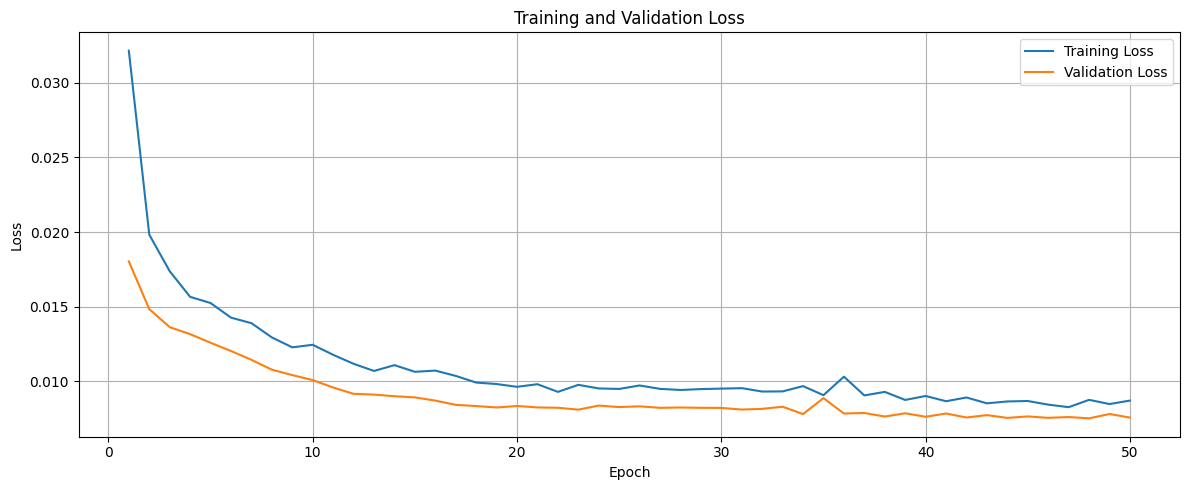

Model: "aod_CNNLSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_66      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_66[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 1, 12)     │          0 │ conv1d_11[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_50    │ (None, 7, 12)     │          0 │ flatten_5[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_90 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_50… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 15)        │        765 │ lstm_90[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_51    │ (None, 7, 15)     │          0 │ dense_71[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_91 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_51… │
│                     │                   │            │ lstm_90[0][1],    │
│                     │                   │            │ lstm_90[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_50 │ (None, 7, 24)     │      1,224 │ lstm_91[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_51 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,307 (356.67 KB)

 Trainable params: 30,435 (118.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,872 (237.79 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_67 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_50 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_90 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,561 (60.79 KB)

 Trainable params: 15,561 (60.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_68      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_92 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_68[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_52    │ (None, 1, 64)     │          0 │ lstm_92[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_93 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_52… │
│                     │                   │            │ lstm_92[0][1],    │
│                     │                   │            │ lstm_92[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 1, 64)     │          0 │ lstm_93[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_52 │ (None, 1, 1)      │         65 │ dropout_24[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,825 (210.25 KB)

 Trainable params: 53,825 (210.25 KB)

 Non-trainable params: 0 (0.00 B)

None


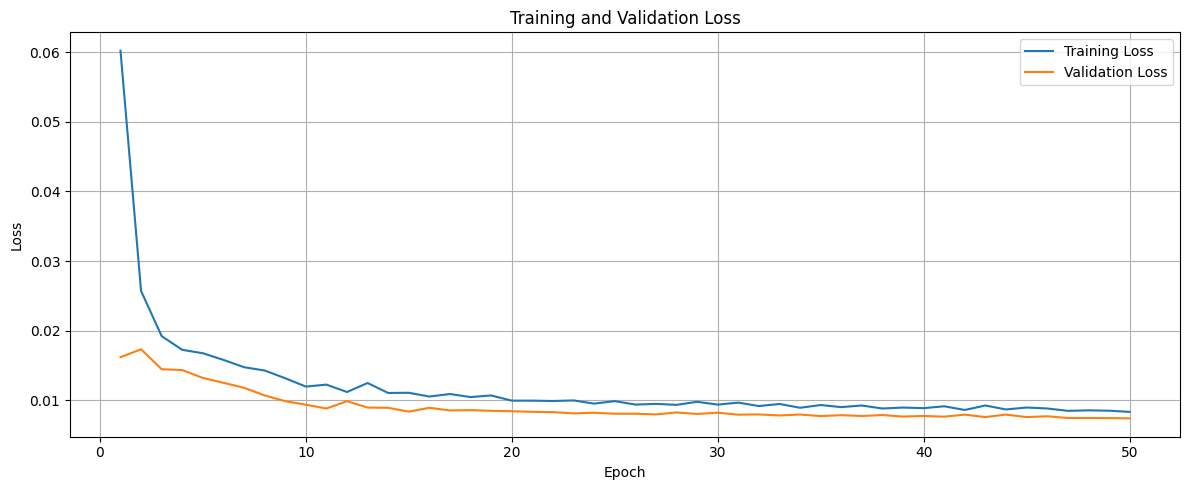

Model: "aod_CNNLSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_69      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_69[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1, 12)     │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_53    │ (None, 7, 12)     │          0 │ flatten_6[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_94 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_53… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 16)        │        816 │ lstm_94[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_54    │ (None, 7, 16)     │          0 │ dense_75[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_95 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_54… │
│                     │                   │            │ lstm_94[0][1],    │
│                     │                   │            │ lstm_94[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_53 │ (None, 7, 24)     │      1,224 │ lstm_95[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_54 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,060 (359.61 KB)

 Trainable params: 30,686 (119.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,374 (239.75 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_70 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_53 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_94 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,612 (60.98 KB)

 Trainable params: 15,612 (60.98 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_71      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_96 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_71[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_55    │ (None, 1, 64)     │          0 │ lstm_96[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_97 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_55… │
│                     │                   │            │ lstm_96[0][1],    │
│                     │                   │            │ lstm_96[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 1, 64)     │          0 │ lstm_97[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_55 │ (None, 1, 1)      │         65 │ dropout_25[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,081 (211.25 KB)

 Trainable params: 54,081 (211.25 KB)

 Non-trainable params: 0 (0.00 B)

None


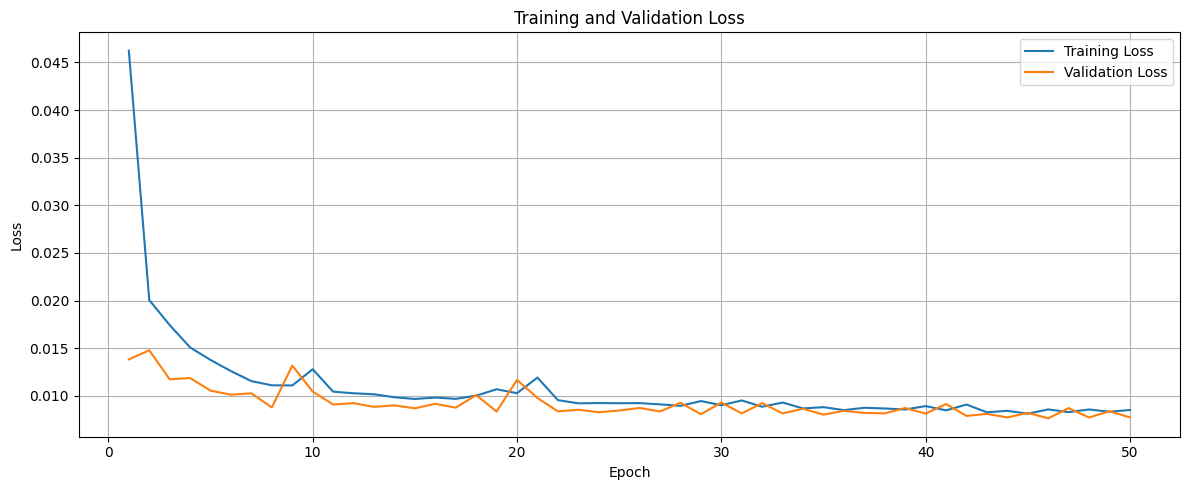

Model: "aod_CNNLSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_72      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 5, 24)     │      1,320 │ input_layer_72[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 3, 12)     │        876 │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 1, 12)     │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 12)        │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_56    │ (None, 7, 12)     │          0 │ flatten_7[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_98 (LSTM)      │ [(None, 50),      │     12,600 │ repeat_vector_56… │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 17)        │        867 │ lstm_98[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_57    │ (None, 7, 17)     │          0 │ dense_79[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_99 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_57… │
│                     │                   │            │ lstm_98[0][1],    │
│                     │                   │            │ lstm_98[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_56 │ (None, 7, 24)     │      1,224 │ lstm_99[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_57 │ (None, 7, 18)     │        450 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,813 (362.55 KB)

 Trainable params: 30,937 (120.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,876 (241.71 KB)

None


Model: "aod_CNNLSTMSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_73 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 5, 24)          │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 3, 12)          │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_56 (RepeatVector) │ (None, 7, 12)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_98 (LSTM)                  │ [(None, 50), (None,    │        12,600 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,663 (61.18 KB)

 Trainable params: 15,663 (61.18 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_CNNLSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_74      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_100 (LSTM)     │ [(None, 64),      │     21,248 │ input_layer_74[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_58    │ (None, 1, 64)     │          0 │ lstm_100[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_101 (LSTM)     │ (None, 1, 64)     │     33,024 │ repeat_vector_58… │
│                     │                   │            │ lstm_100[0][1],   │
│                     │                   │            │ lstm_100[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 1, 64)     │          0 │ lstm_101[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_58 │ (None, 1, 1)      │         65 │ dropout_26[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,337 (212.25 KB)

 Trainable params: 54,337 (212.25 KB)

 Non-trainable params: 0 (0.00 B)

None


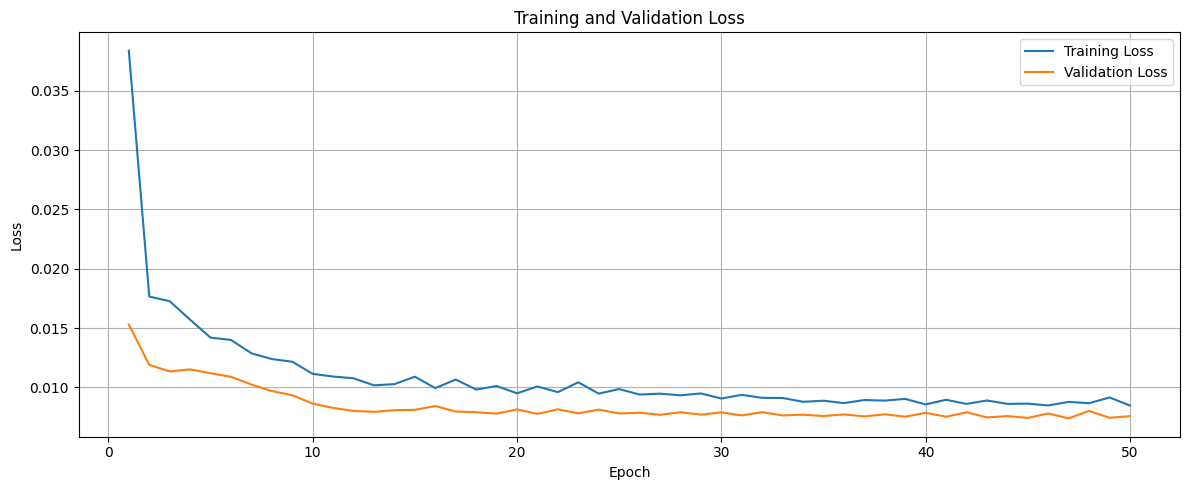

Choosing the best result

dict_keys([10, 11, 12, 13, 14, 15, 16, 17])
N = 10
mae = 4.30054518099569
mse = 32.62615280618084
rmse = 5.711930742418087
r2 = -2.4826965197628774
mape = 0.24548087541870736
N = 11
mae = 4.250362332957493
mse = 34.925667036015106
rmse = 5.909794161898966
r2 = -2.4298720189622434
mape = 0.25872572278508843
N = 12
mae = 4.267051895554456
mse = 32.18396406185607
rmse = 5.6730912262941855
r2 = -2.0528776929732375
mape = 0.2427180726856538
N = 13
mae = 4.501022317570632
mse = 32.0963536081153
rmse = 5.665364384407706
r2 = -1.701068015587091
mape = 0.2434476359652744
N = 14
mae = 4.474221469563103
mse = 31.92519498985599
rmse = 5.6502384896441304
r2 = -1.7130588804180205
mape = 0.2424781789560612
N = 15
mae = 4.432087408309244
mse = 31.795964508531345
rmse = 5.638791050263465
r2 = -1.4731967193597275
mape = 0.2409772607986711
N = 16
mae = 4.276158009257841
mse = 32.33759414231317
rmse = 5.686615350304008
r2 = -1.7388950056986587
mape = 0.24389142731264762
N = 17
ma

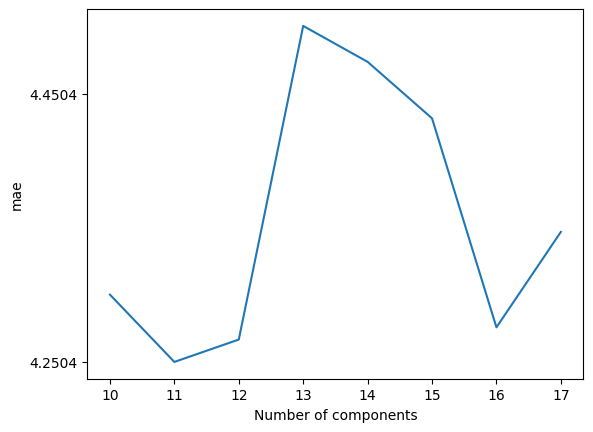

inv_y_pred.shape = (776, 1)
inv_y_test.shape = (776, 1)


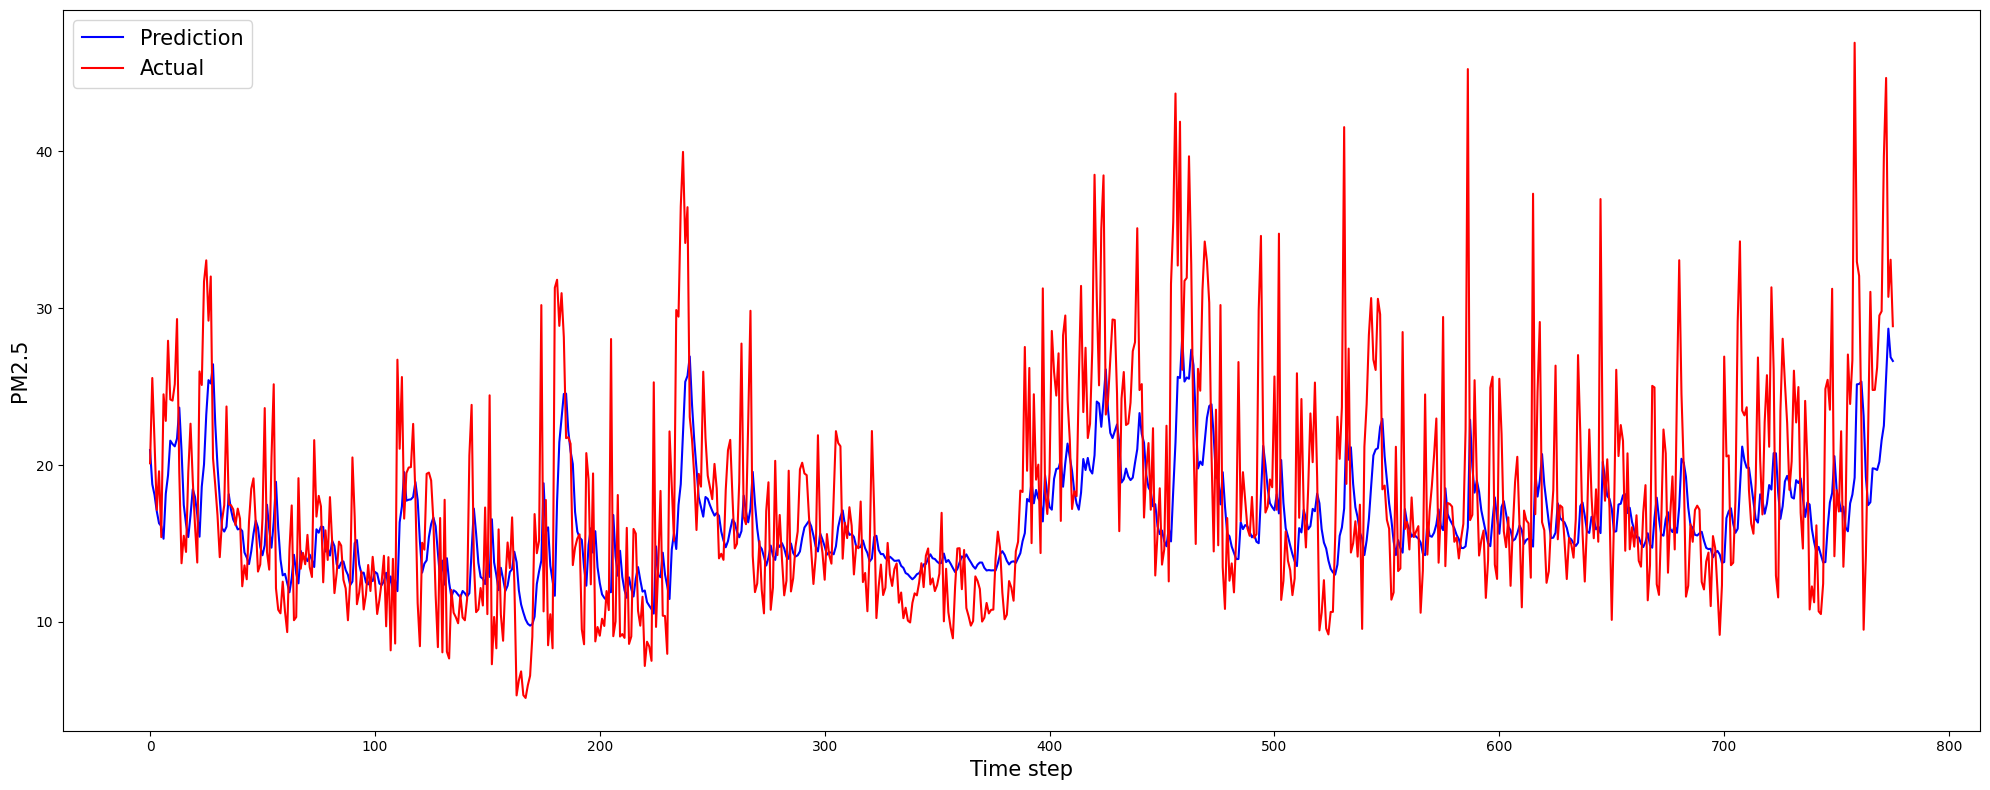

dim_reduction_method dim_after_reduction prediction       mae        mse  \
0                 None                 N/A       LSTM  4.403112  32.664239   
1         LSTM-Seq2Seq                  12       LSTM  4.166520  31.095105   
2          GRU-Seq2Seq                  15       LSTM  4.006453  30.004037   
3      CNNLSTM-Seq2Seq                  11       LSTM  4.250362  34.925667   

       rmse        r2      mape  
0  5.715264 -0.778659  0.242072  
1  5.576299 -1.058266  0.238840  
2  5.477594 -0.777665  0.234683  
3  5.909794 -2.429872  0.258726

In [37]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, CNNLSTMSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_metrics, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults, metric_to_choose="mae")

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
for metric, value in best_metrics.items():
    evaluation_board[metric] += [value]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [38]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022.csv"))
df_cnnlstms2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.237627      -0.163246       0.500466      -0.395938   
2018-01-02       0.237627      -0.163246       0.500466      -0.395938   
2018-01-03       0.237627      -0.163246       0.500466      -0.395938   
2018-01-04       0.238034      -0.162093       0.508309      -0.399685   
2018-01-05       0.243838      -0.162185       0.522715      -0.407985   
...                   ...            ...            ...            ...   
2022-12-27       0.185268       0.168573       0.790619      -0.275605   
2022-12-28       0.179870       0.173857       0.781585      -0.283573   
2022-12-29       0.174487       0.174965       0.772970      -0.281264   
2022-12-30       0.177405       0.184293       0.775496      -0.286309   
2022-12-31       0.171739       0.193143       0.780093      -0.297353   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01      -0.193574      -0.531015       0.138450       1.117234   
2018-01-02      -0.193574      -0.531015       0.138450       1.117234   
2018-01-03      -0.193574      -0.531015       0.138450       1.117234   
2018-01-04      -0.199209      -0.532717       0.135783       1.123263   
2018-01-05      -0.209671      -0.534421       0.134472       1.138533   
...                   ...            ...            ...            ...   
2022-12-27       0.205359       0.158914      -0.029478       0.414428   
2022-12-28       0.208311       0.167130      -0.036693       0.419275   
2022-12-29       0.204771       0.171147      -0.039692       0.414952   
2022-12-30       0.193677       0.168877      -0.046095       0.425035   
2022-12-31       0.189017       0.171925      -0.052161       0.438435   

            aod_feature_9  aod_feature_10  aod_feature_11  station  
time                                                                
2018-01-01      -0.183965        0.119242        0.102142      201  
2018-01-02      -0.183965        0.119242        0.102142      201  
2018-01-03      -0.183965        0.119242        0.102142      201  
2018-01-04      -0.184121        0.120447        0.102329      201  
2018-01-05      -0.186436        0.121053        0.106857      201  
...                   ...             ...             ...      ...  
2022-12-27      -0.204655        0.279770       -0.023901      216  
2022-12-28      -0.201976        0.280802       -0.021538      216  
2022-12-29      -0.202857        0.278482       -0.025389      216  
2022-12-30      -0.201696        0.278530       -0.019819      216  
2022-12-31      -0.203178        0.281676       -0.015281      216  

[3889 rows x 12 columns]

In [39]:
# Prepare the reduced data with additional pm25_3km and predicted pm25 values
df_cnnlstms2s_reduced_augmented = augmentReducedData(df_cnnlstms2s_reduced, y_aod_scaled, aod_pm25_3km_column, aod_label_scaler)
df_cnnlstms2s_reduced_augmented.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022_with_raw_pm25_3km_and_prediced_pm25.csv"))
df_cnnlstms2s_reduced_augmented

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2018-01-01       0.237627      -0.163246       0.500466      -0.395938   
2018-01-02       0.237627      -0.163246       0.500466      -0.395938   
2018-01-03       0.237627      -0.163246       0.500466      -0.395938   
2018-01-04       0.238034      -0.162093       0.508309      -0.399685   
2018-01-05       0.243838      -0.162185       0.522715      -0.407985   
...                   ...            ...            ...            ...   
2022-12-27       0.185268       0.168573       0.790619      -0.275605   
2022-12-28       0.179870       0.173857       0.781585      -0.283573   
2022-12-29       0.174487       0.174965       0.772970      -0.281264   
2022-12-30       0.177405       0.184293       0.775496      -0.286309   
2022-12-31       0.171739       0.193143       0.780093      -0.297353   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2018-01-01      -0.193574      -0.531015       0.138450       1.117234   
2018-01-02      -0.193574      -0.531015       0.138450       1.117234   
2018-01-03      -0.193574      -0.531015       0.138450       1.117234   
2018-01-04      -0.199209      -0.532717       0.135783       1.123263   
2018-01-05      -0.209671      -0.534421       0.134472       1.138533   
...                   ...            ...            ...            ...   
2022-12-27       0.205359       0.158914      -0.029478       0.414428   
2022-12-28       0.208311       0.167130      -0.036693       0.419275   
2022-12-29       0.204771       0.171147      -0.039692       0.414952   
2022-12-30       0.193677       0.168877      -0.046095       0.425035   
2022-12-31       0.189017       0.171925      -0.052161       0.438435   

            aod_feature_9  aod_feature_10  aod_feature_11  station   pm25_3km  \
time                                                                            
2018-01-01      -0.183965        0.119242        0.102142      201  34.919998   
2018-01-02      -0.183965        0.119242        0.102142      201  51.830002   
2018-01-03      -0.183965        0.119242        0.102142      201  38.240002   
2018-01-04      -0.184121        0.120447        0.102329      201  40.259998   
2018-01-05      -0.186436        0.121053        0.106857      201  21.690001   
...                   ...             ...             ...      ...        ...   
2022-12-27      -0.204655        0.279770       -0.023901      216  34.439411   
2022-12-28      -0.201976        0.280802       -0.021538      216  29.838476   
2022-12-29      -0.202857        0.278482       -0.025389      216  28.450829   
2022-12-30      -0.201696        0.278530       -0.019819      216  19.854403   
2022-12-31      -0.203178        0.281676       -0.015281      216  27.658358   

            hiep_predicted_pm25  
time                             
2018-01-01            25.331467  
2018-01-02            25.331467  
2018-01-03            27.816353  
2018-01-04            38.601238  
2018-01-05            38.896721  
...                         ...  
2022-12-27            26.303757  
2022-12-28            29.969603  
2022-12-29            33.330566  
2022-12-30            30.901659  
2022-12-31            30.651270  

[3889 rows x 14 columns]

#### Compare MAE with pm25_3km

On test data:
MAE between actual and pm25_3km: 6.785086281801943
MAE between actual and predicted pm25: 4.250362332957493
MSE between actual and pm25_3km: 87.2793385941348
MSE between actual and predicted pm25: 34.925667036015106


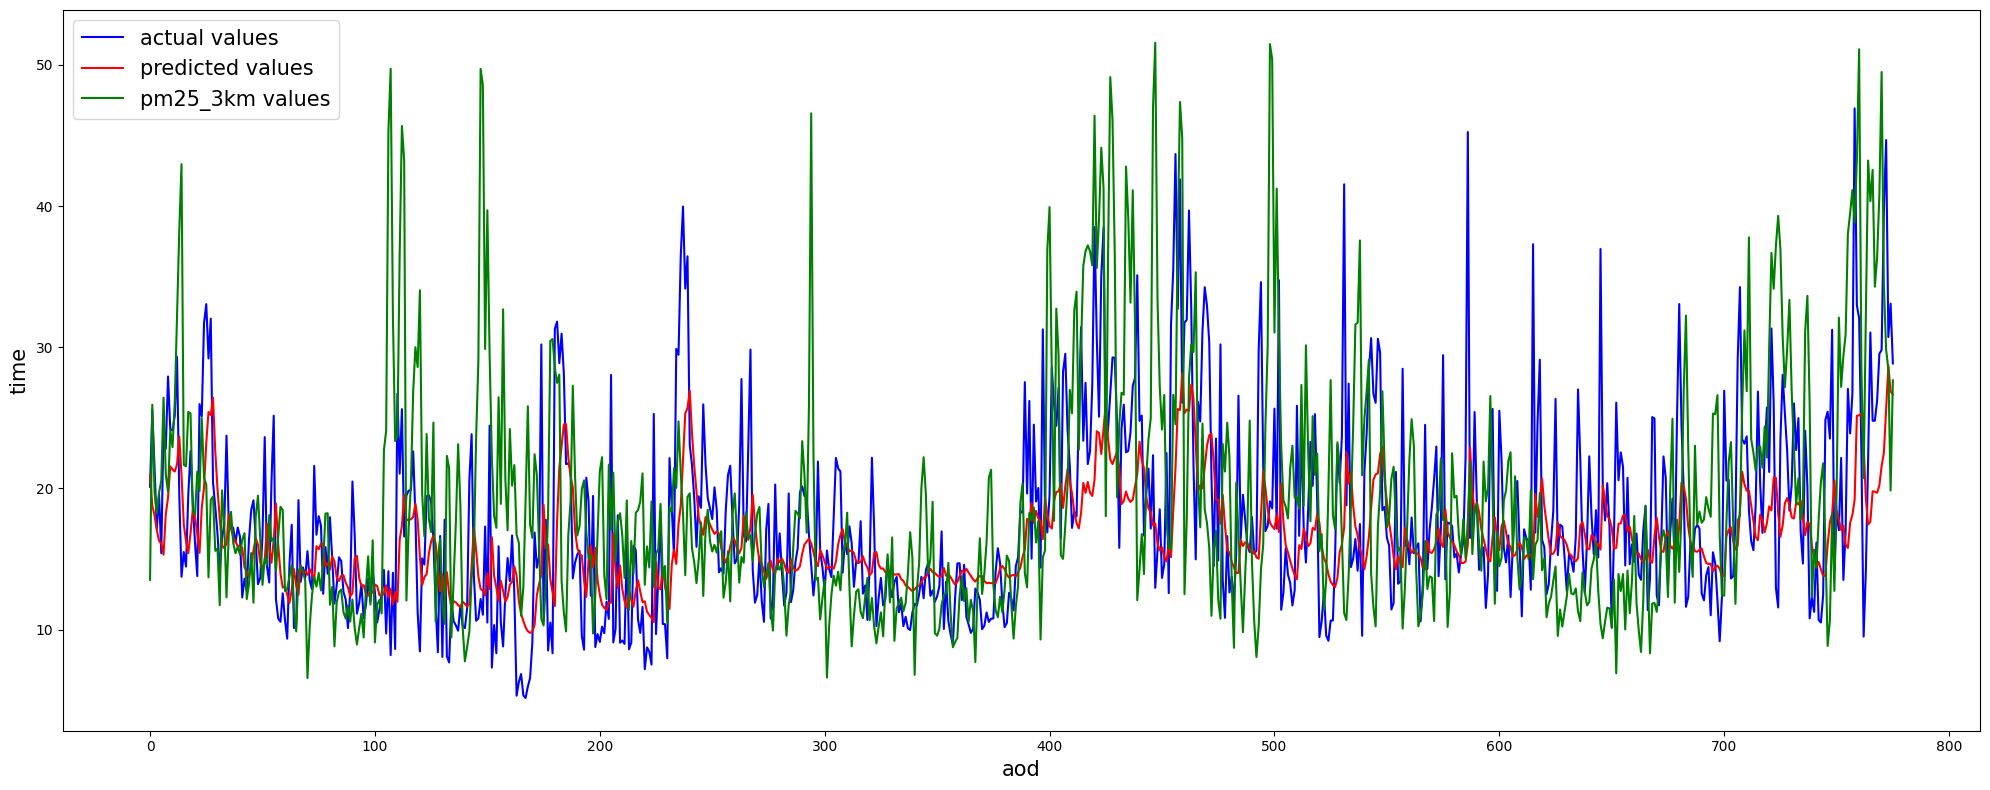

On entire data:
MAE between actual and pm25_3km: 7.875957292759844
MAE between actual and predicted pm25: 5.685650825500488


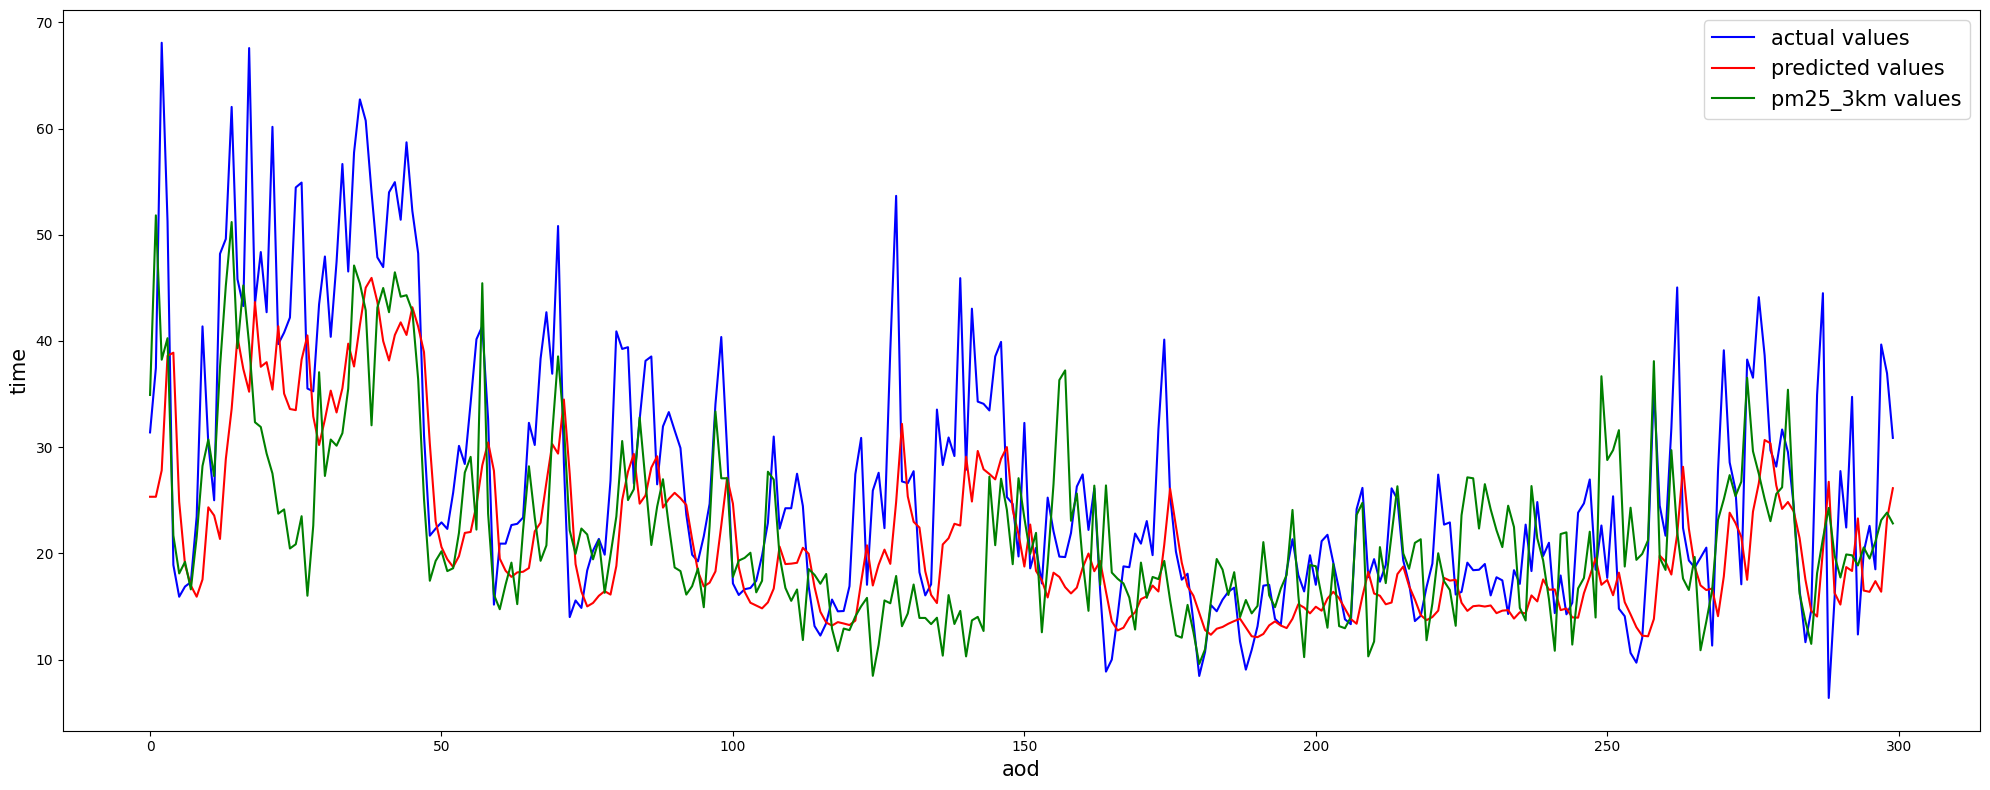

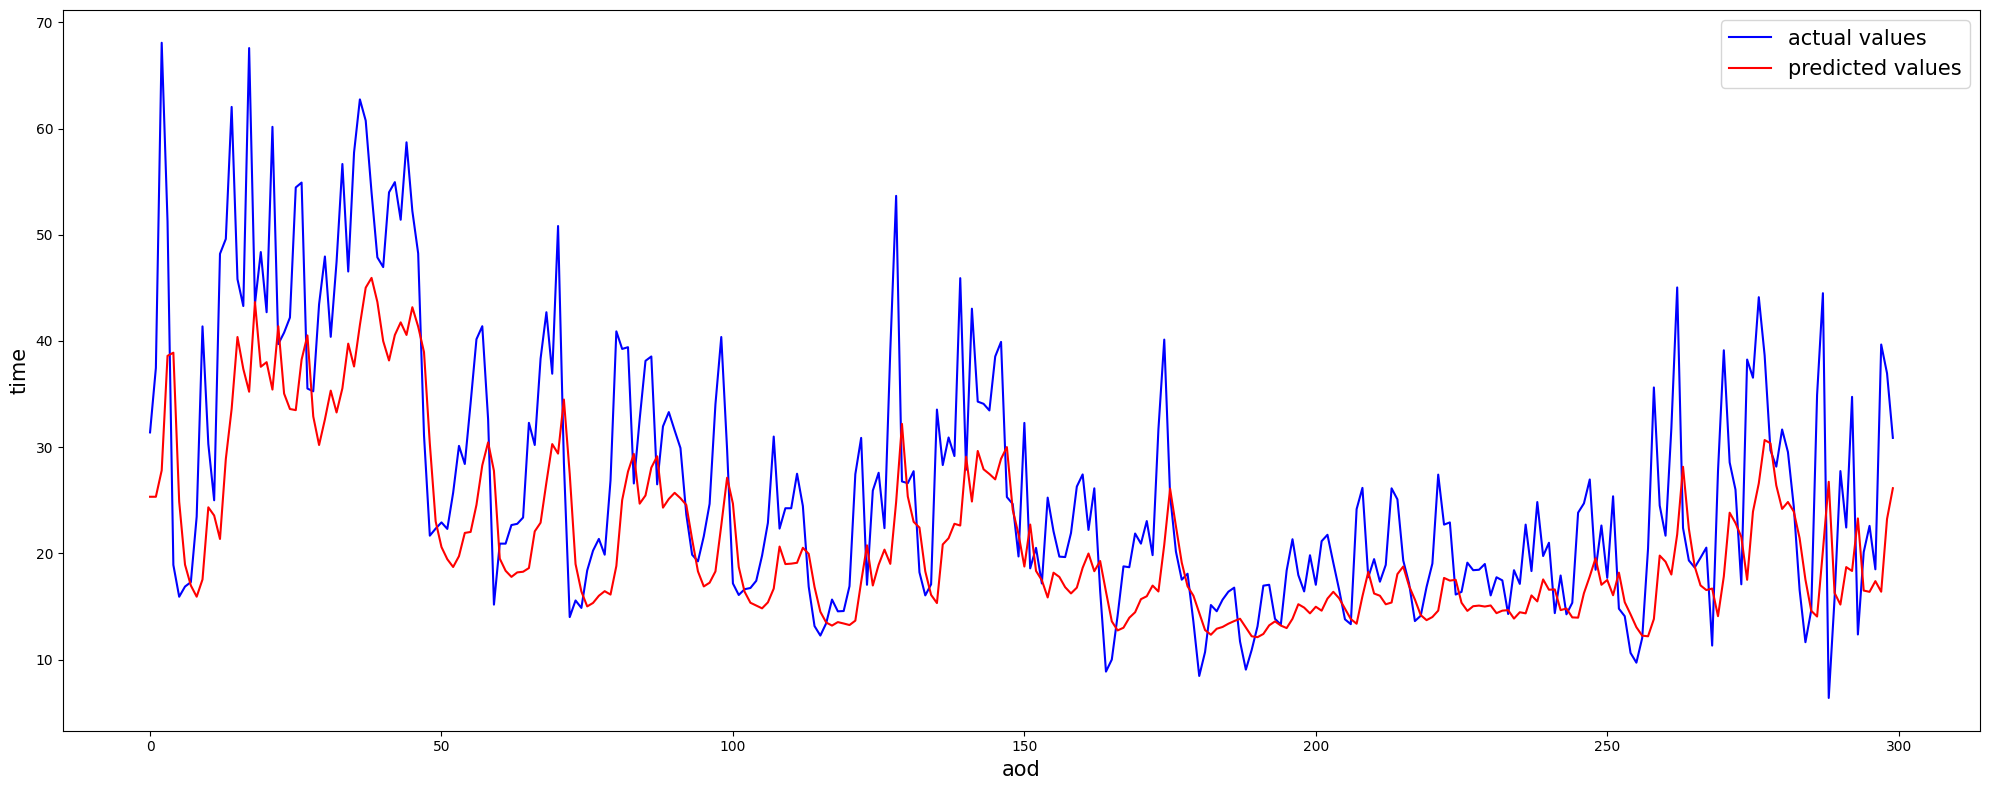

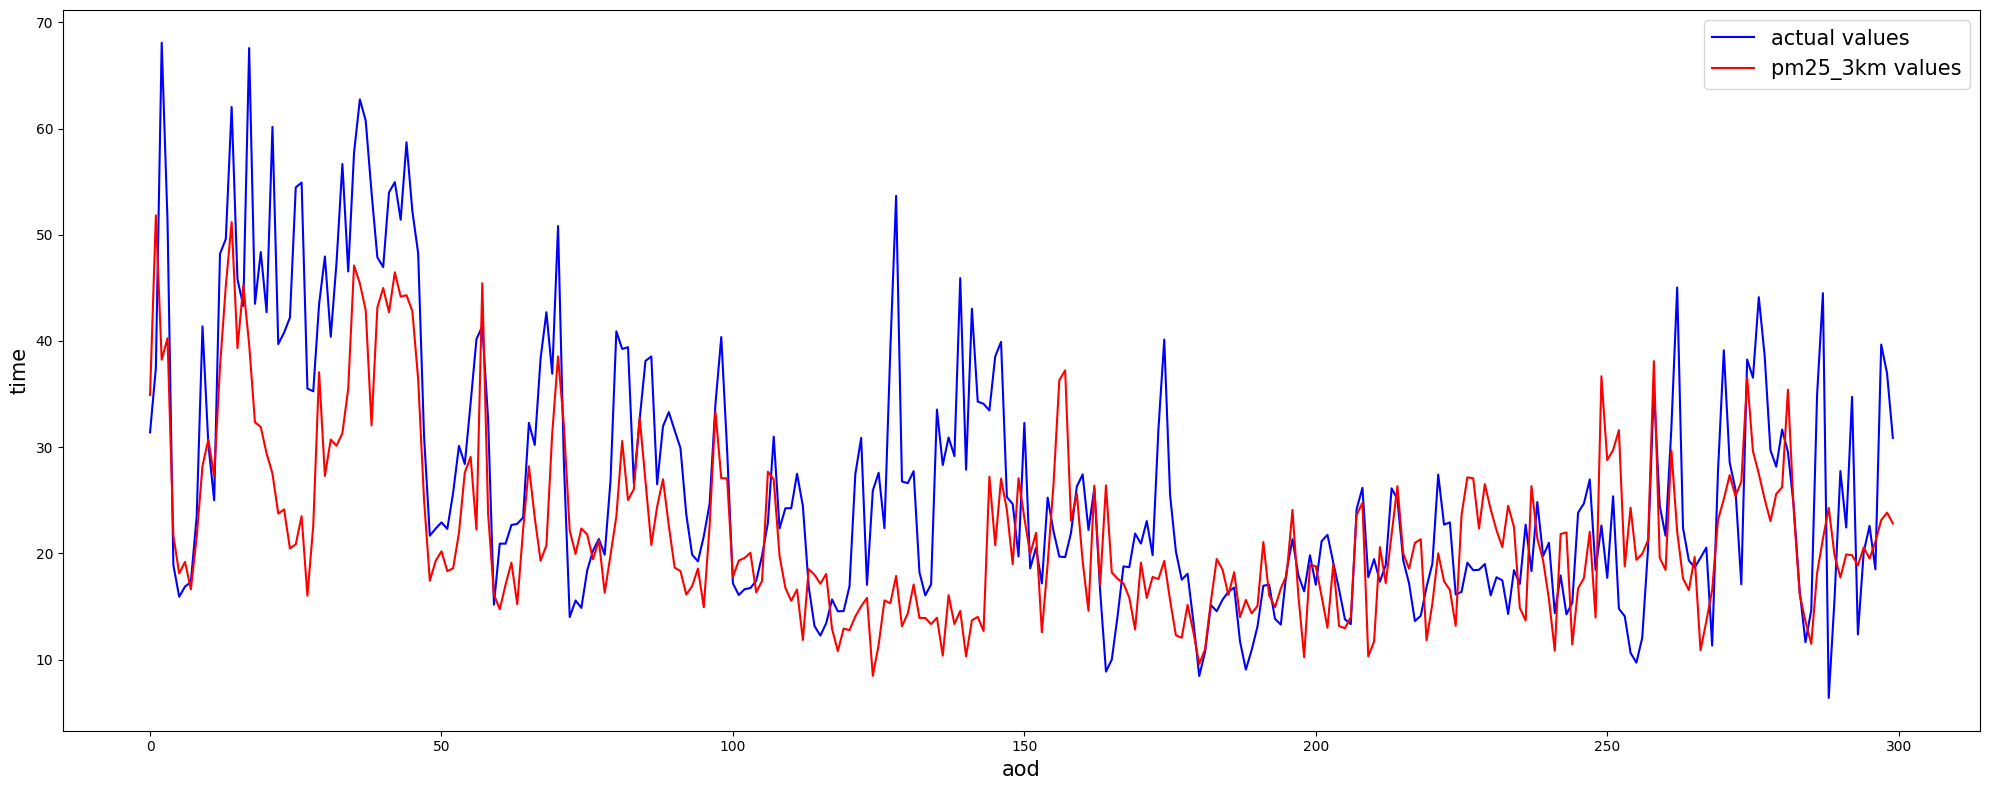

In [40]:
# Compare test set only
all_days_inv_y_pred, all_days_inv_y_test = best_evaluation_data
y_pred = all_days_inv_y_pred.reshape(-1, 1)
y_test = all_days_inv_y_test.reshape(-1, 1)
test_len = y_test.shape[0]
aod_pm25_3km_column_test = aod_pm25_3km_column.tail(test_len)
print("On test data:")
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_test, aod_pm25_3km_column_test)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE between actual and pm25_3km: {mean_squared_error(y_test, aod_pm25_3km_column_test)}")
print(f"MSE between actual and predicted pm25: {mean_squared_error(y_test, y_pred)}")
plot_3_data(data1=y_test,
           datalabel1="actual values",
           data2=y_pred,
           datalabel2="predicted values",
           data3=aod_pm25_3km_column_test,
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")

# Compare entire dataset
print("On entire data:")
y_pred_all = df_cnnlstms2s_reduced_augmented["hiep_predicted_pm25"]
print(f"MAE between actual and pm25_3km: {mean_absolute_error(y_aod, aod_pm25_3km_column)}")
print(f"MAE between actual and predicted pm25: {mean_absolute_error(y_aod, y_pred_all)}")
plot_3_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           data3=aod_pm25_3km_column.head(300),
           datalabel3="pm25_3km values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=y_pred_all.head(300),
           datalabel2="predicted values",
           ylabel="time",
           xlabel="aod")
plot_2_data(data1=y_aod.head(300),
           datalabel1="actual values",
           data2=aod_pm25_3km_column.head(300),
           datalabel2="pm25_3km values",
           ylabel="time",
           xlabel="aod")